In [1]:
COLAB = False
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    DRIVE_PATH = F'/content/gdrive/My Drive/evaluation-pipeline/' # Path to data on Google Drive
    REPO_PATH = F'/content/evaluation-pipeline/'
else:
    DRIVE_PATH = F'' # Local path
    REPO_PATH = ''


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
if COLAB:
    !git clone -b development https://github.com/lovis-heindrich/evaluation-pipeline.git

In [3]:
if COLAB:
    %cd /content/evaluation-pipeline
    !git pull

In [4]:
import sys
import pickle
import pandas as pd
import numpy as np
# Import local files from github
sys.path.append(REPO_PATH+"src")
from utils import load_results, plot_accuracy
import utils
import analysis
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind_from_stats

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns

# OOD Pipeline

#### Standard OOD pipeline

In [5]:
ood_base_raw = load_results(DRIVE_PATH + 'Results/Ood_results_raw_final.p')
ood_transform_raw = load_results(DRIVE_PATH + 'Results/Ood_results_transform_raw_final.p')
ood_transform_raw.Measure.unique()

array(['None', 'Noise', 'Grey', 'Snow', 'Rain', 'Fog', 'Perspective',
       'Blur', 'Rotate', 'Crop', 'Reflection'], dtype=object)

In [33]:
ood_transform_no_none = ood_transform_raw[(ood_transform_raw["Measure"] != "None")]
ood_transform_no_none.Measure.unique()
ood_transform_no_none.groupby('Classifier').agg({'ROC': ['mean', 'std']})

ROC          
                mean       std
Classifier                    
Baseline    0.725464  0.128227
MC Dropout  0.832727  0.137226

In [34]:
abs(0.725464 - 	0.832727)

0.107263

[(0.7, 1.05), Text(0, 0.5, 'AUROC'), Text(0.5, 0, 'OOD data set')]

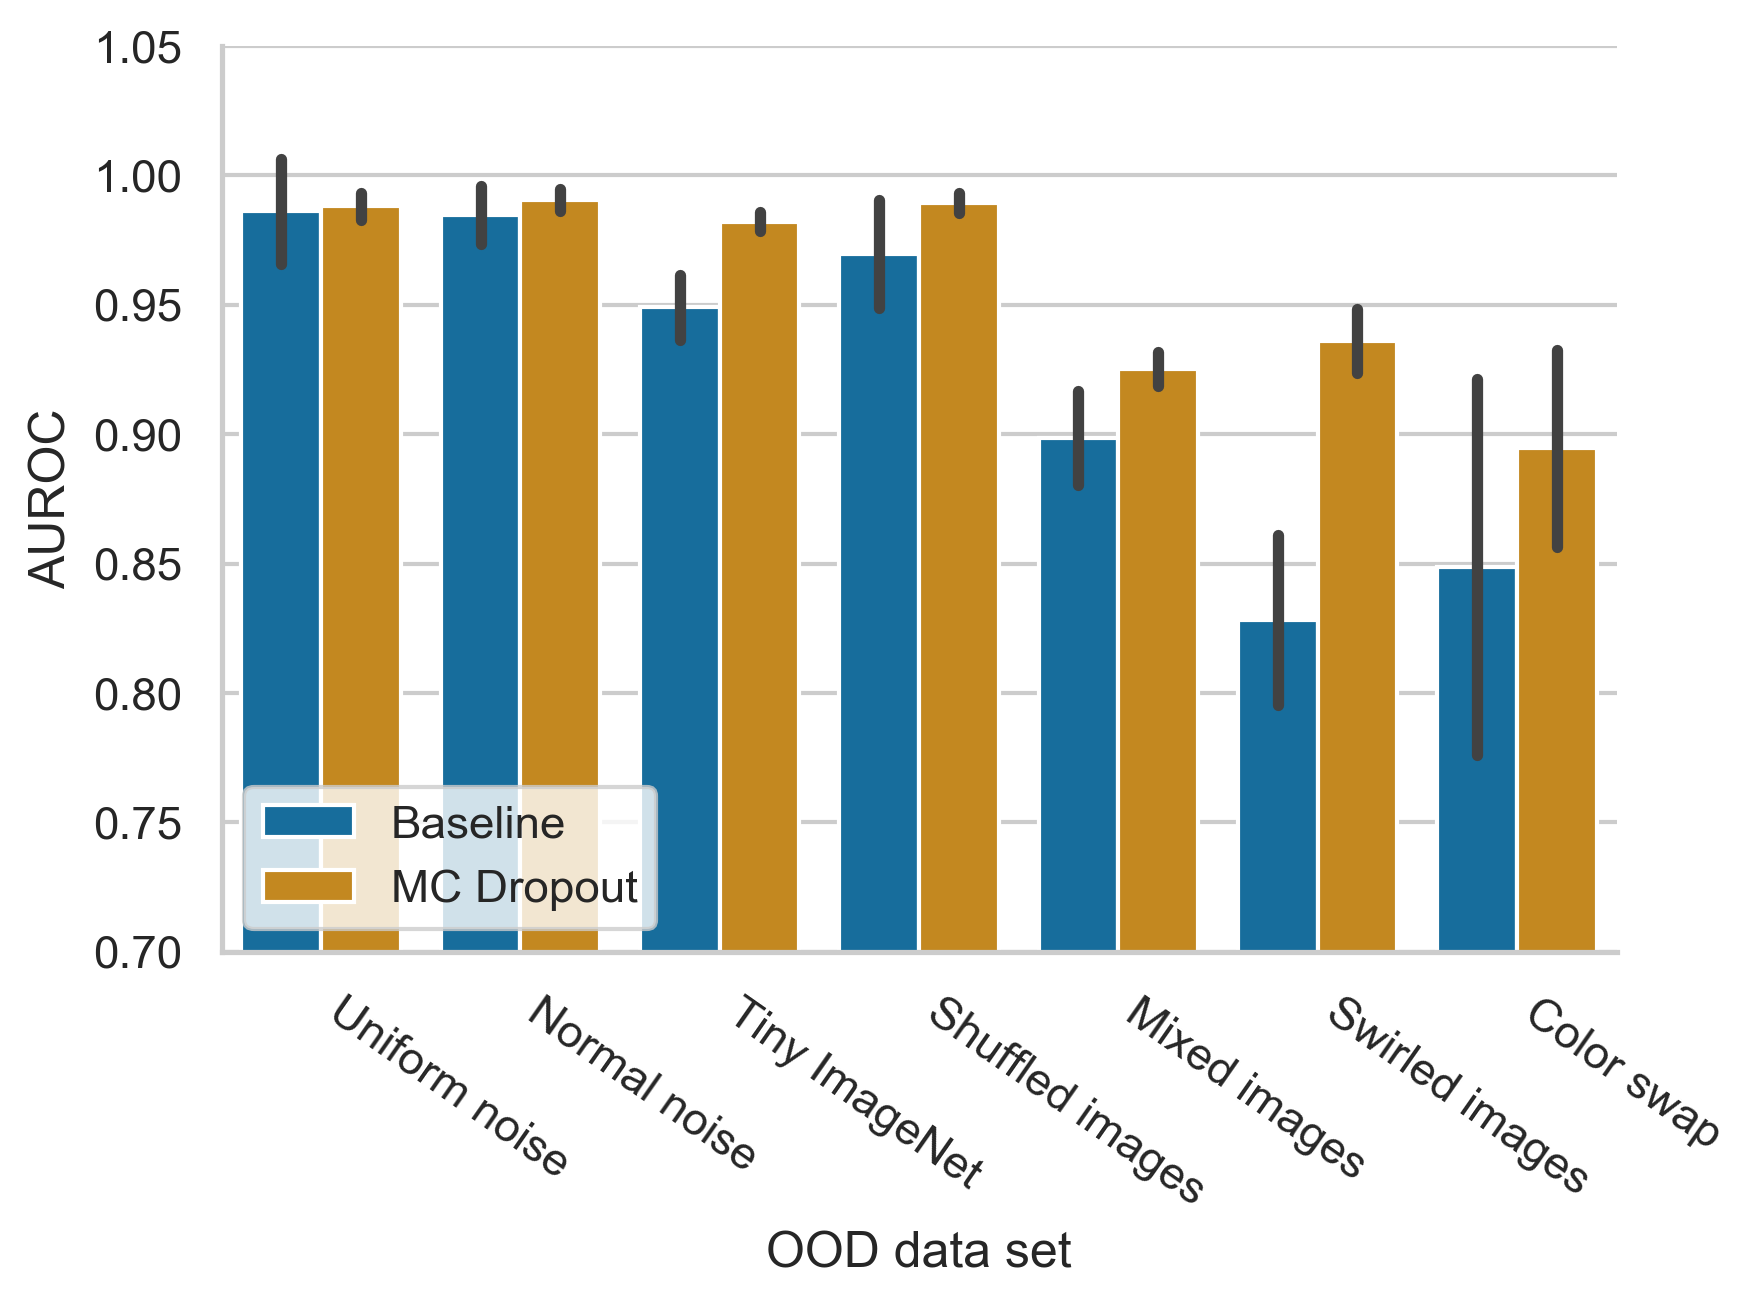

In [61]:
sns.set(font_scale=1.1)
sns.set(style="whitegrid")

labels = ['Uniform noise', 'Normal noise', 'Tiny ImageNet', 'Shuffled images', 'Mixed images', 'Swirled images', 'Color swap']
ax = sns.barplot(x="Measure", y="ROC", data=ood_base_raw, hue="Classifier", order=labels, ci="sd", palette="colorblind")
#ax.set_xticklabels(["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"])
sns.despine()
plt.legend(loc='lower left')
ax.set_xticklabels(labels, rotation=-35, ha='left')
ax.set(ylim=(0.7, 1.05), ylabel="AUROC", xlabel="OOD data set")

[(0.3, 1.05), Text(0, 0.5, 'AUROC'), Text(0.5, 0, 'OOD data transformation')]

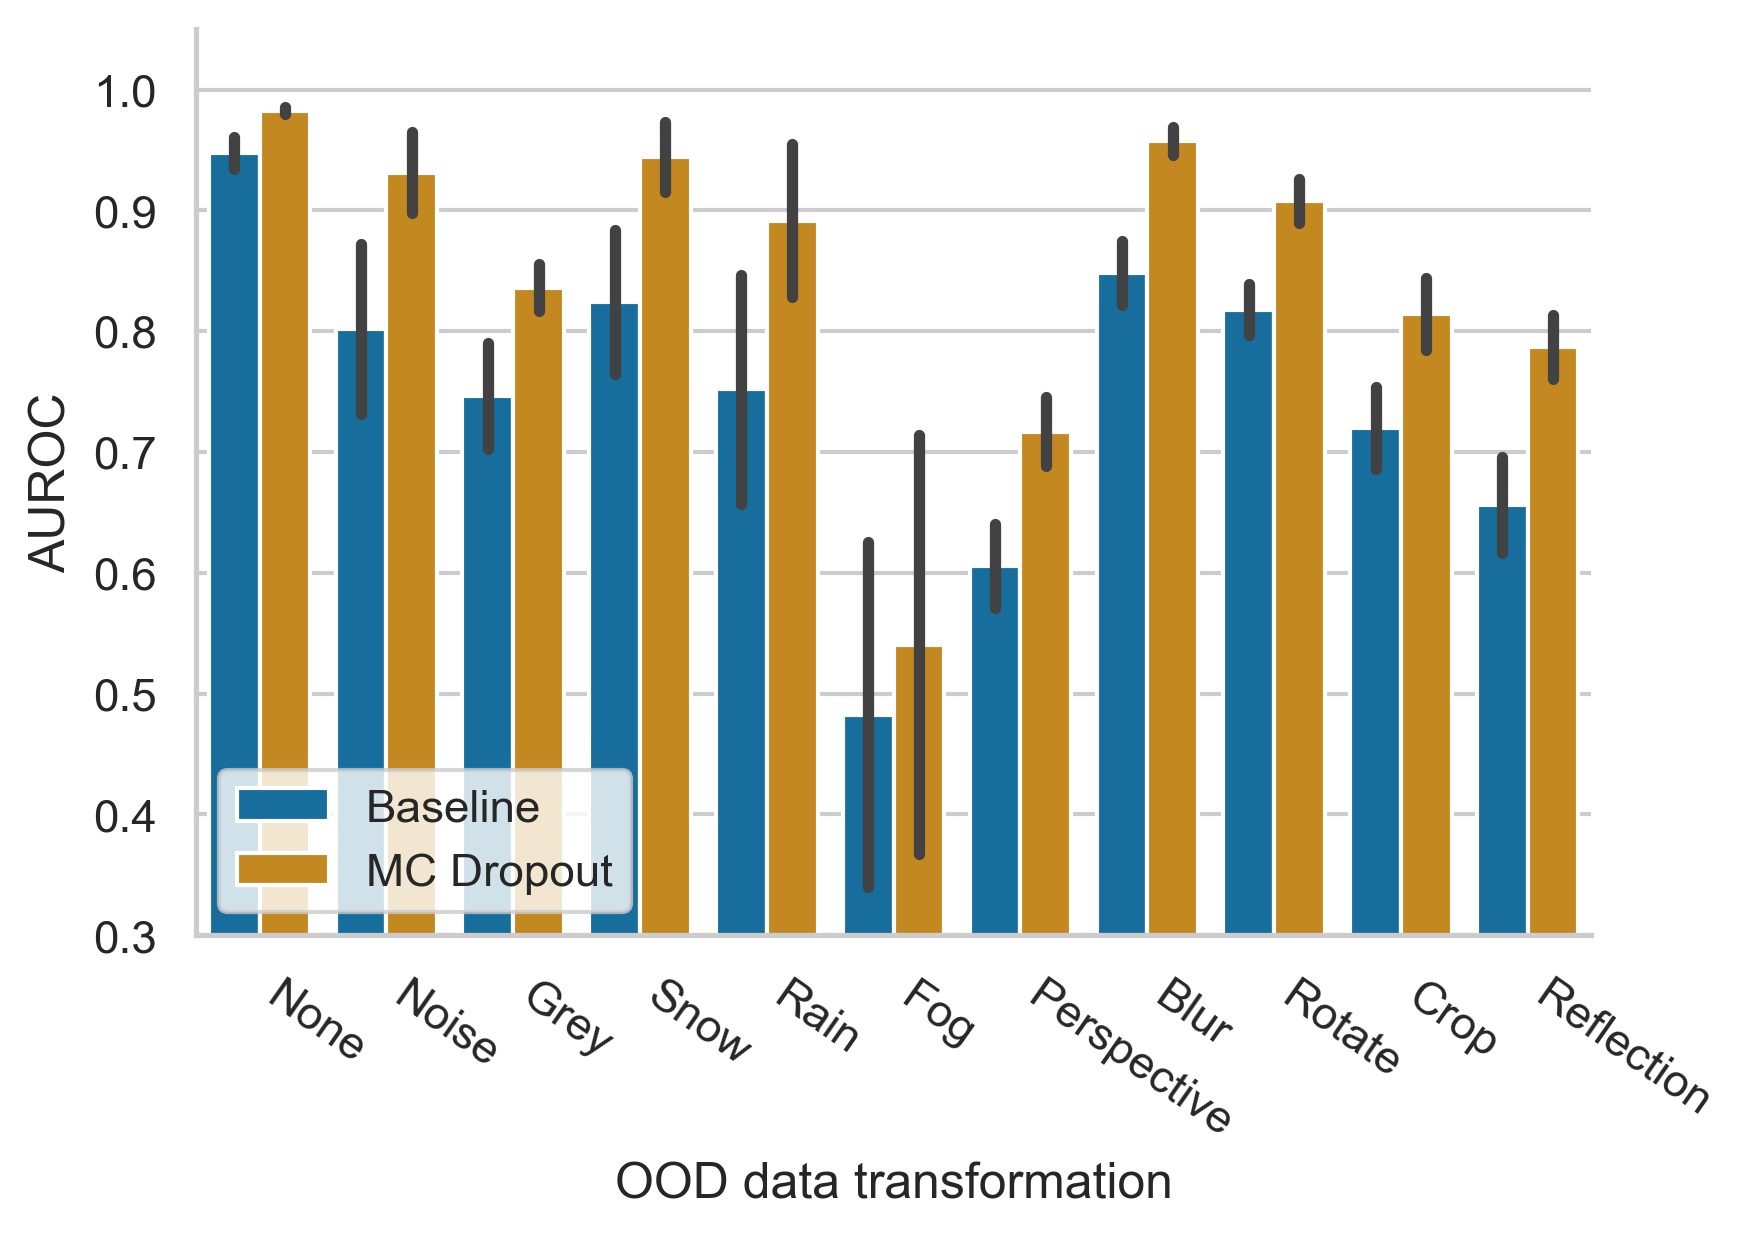

In [60]:
labels = ['None', 'Noise', 'Grey', 'Snow', 'Rain', 'Fog', 'Perspective', 'Blur', 'Rotate', 'Crop', 'Reflection']
ax = sns.barplot(x="Measure", y="ROC", data=ood_transform_raw, hue="Classifier", order=labels, ci="sd", palette="colorblind")
#ax.set_xticklabels(["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"])
sns.despine()
plt.legend(loc='lower left')
ax.set_xticklabels(labels, rotation=-35, ha='left')
ax.set(ylim=(0.3, 1.05), ylabel="AUROC", xlabel="OOD data transformation")

In [50]:
lee_gan_raw = load_results(DRIVE_PATH + 'Results/Ood_results_lee_gan_raw_final.p')
lee_wgan_raw = load_results(DRIVE_PATH + 'Results/Ood_results_lee_wgan_raw_final.p')
sricharan_gan_raw = load_results(DRIVE_PATH + 'Results/Ood_results_sricharan_gan_raw_final.p')
sricharan_wgan_raw = load_results(DRIVE_PATH + 'Results/Ood_results_sricharan_wgan_raw_final.p')
sricharan_wgan_002_raw = load_results(DRIVE_PATH + 'Results/Ood_results_sricharan_002_wgan_raw_final.p')
sricharan_wgan_2e_raw = load_results(DRIVE_PATH + 'Results/Ood_results_sricharan_2e_wgan_raw_final.p')

combined_gan_raw = pd.concat([lee_gan_raw, lee_wgan_raw, sricharan_gan_raw, sricharan_wgan_raw, sricharan_wgan_002_raw, sricharan_wgan_2e_raw], axis = 0)
combined_gan_raw["GAN"] = combined_gan_raw["Measure"].str[:-2]
combined_gan_raw["Measure"] = combined_gan_raw["Measure"].str[-1:]
#combined_gan_raw.to_csv(DRIVE_PATH + 'Results/Ood_results_gan_combined_raw_final.csv')

In [7]:
combined_gan_raw.head()


ROC Measure Classifier                  GAN
0  0.875475       0   Baseline  Lee Gan conditional
1  0.910689       0   Baseline  Lee Gan conditional
2  0.859769       0   Baseline  Lee Gan conditional
3  0.894704       0   Baseline  Lee Gan conditional
4  0.885496       0   Baseline  Lee Gan conditional

[(0, 1.05), Text(0, 0.5, 'AUROC'), Text(0.5, 0, '')]

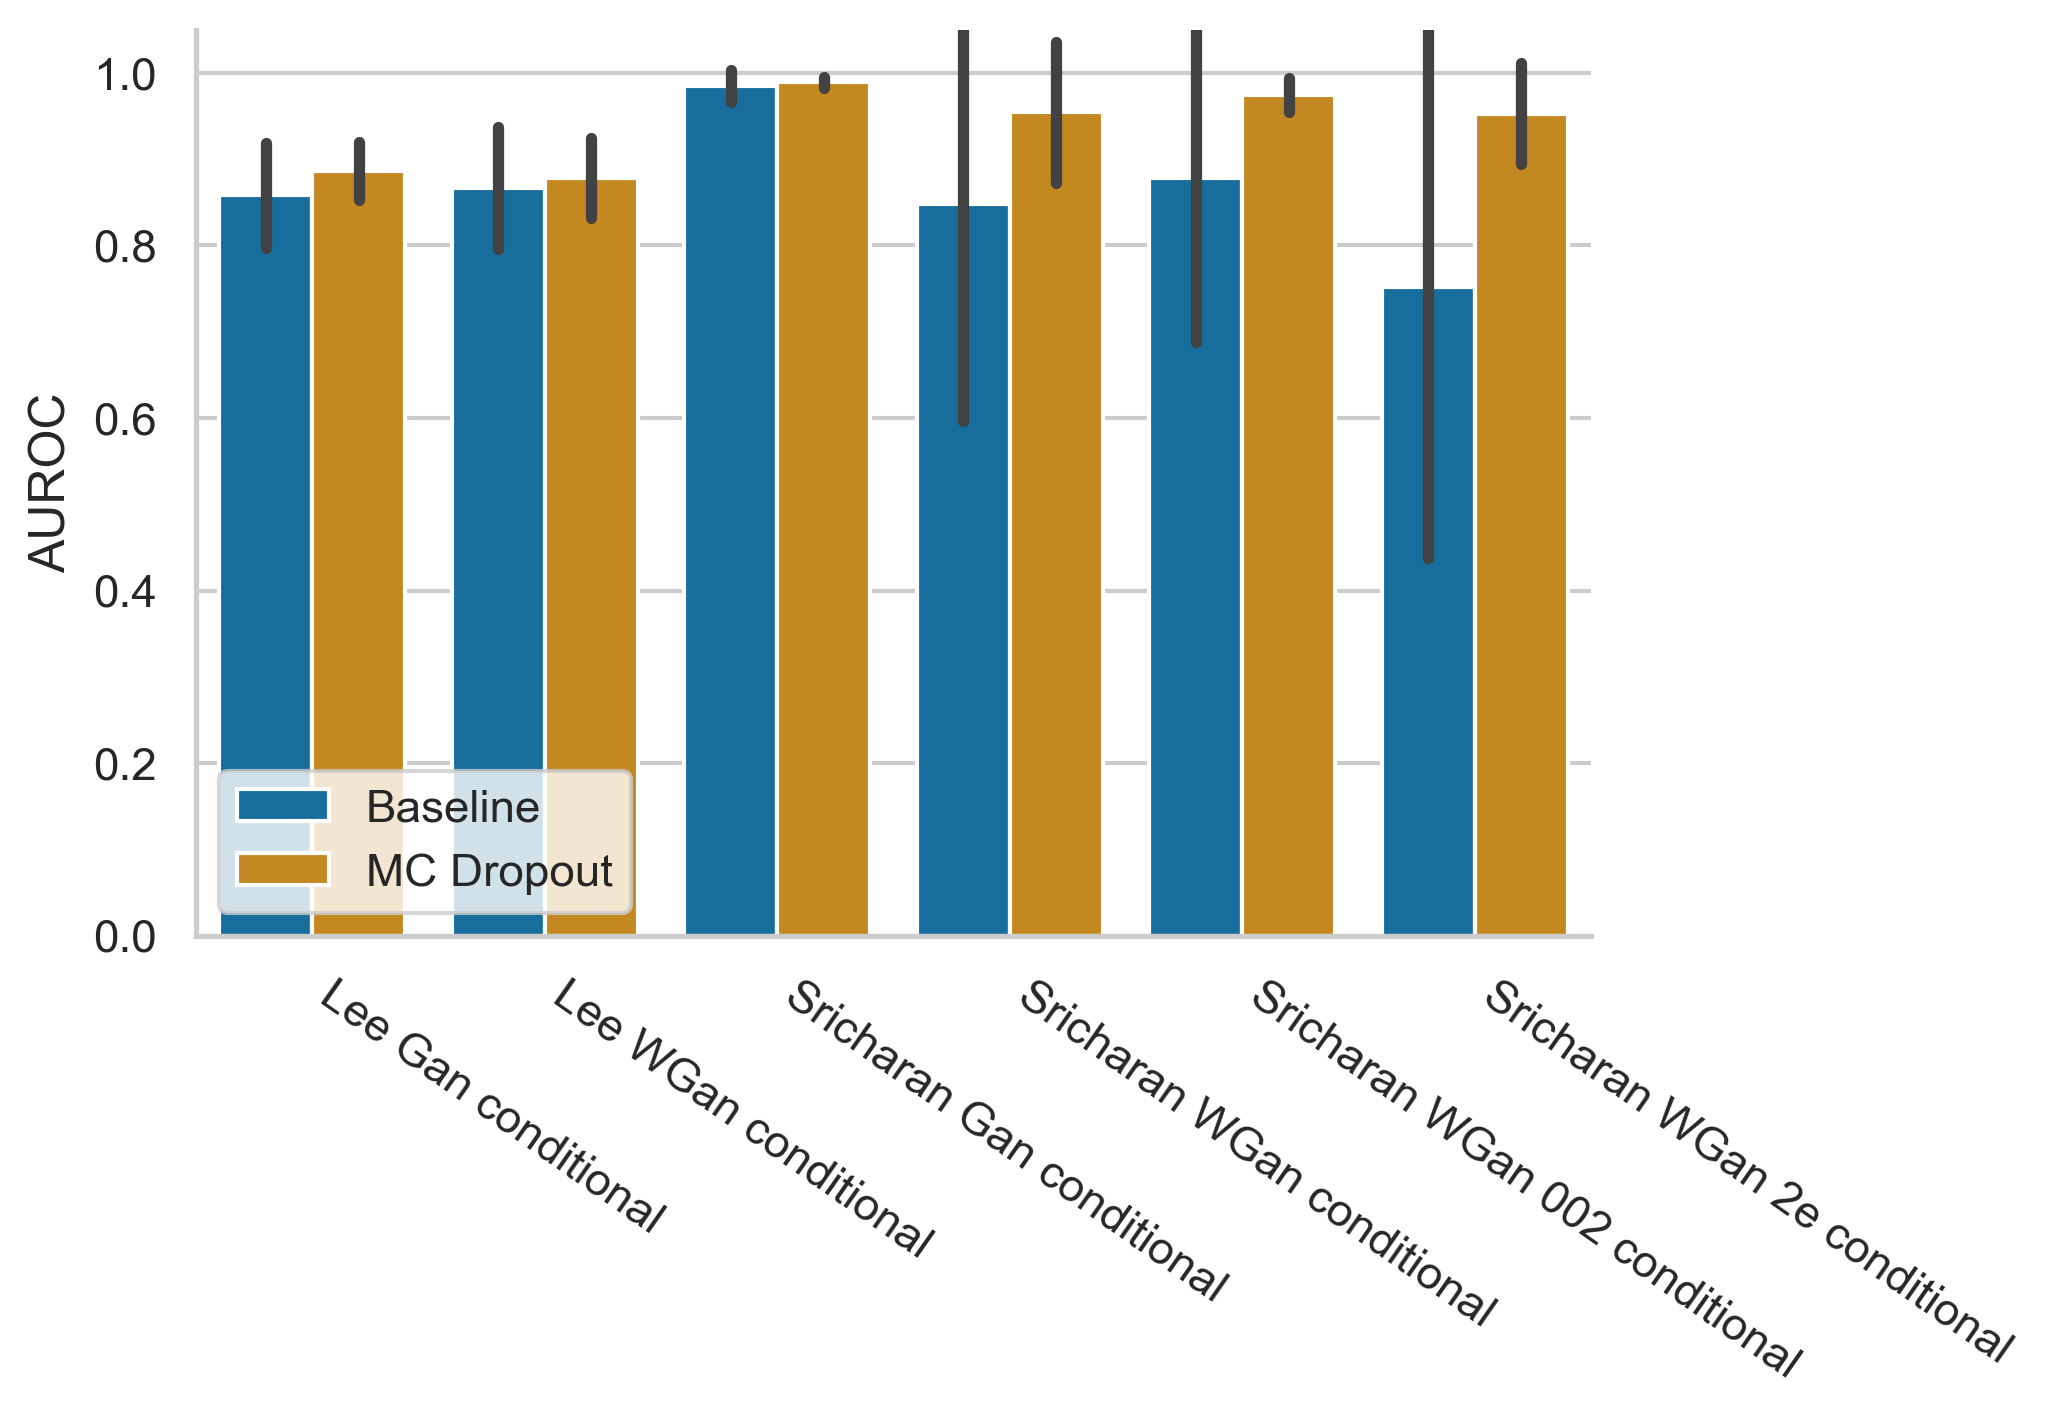

In [68]:
labels = ['Lee Gan conditional', 'Lee WGan conditional',
       'Sricharan Gan conditional', 'Sricharan WGan conditional',
       'Sricharan WGan 002 conditional', 'Sricharan WGan 2e conditional']
ax = sns.barplot(x="GAN", y="ROC", data=combined_gan_raw, hue="Classifier", order=labels, ci="sd", palette="colorblind")
#ax.set_xticklabels(["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"])
sns.despine()
plt.legend(loc='lower left')
ax.set_xticklabels(labels, rotation=-35, ha='left')
ax.set(ylim=(0, 1.05), ylabel="AUROC", xlabel="")

<Figure size 1800x1200 with 0 Axes>

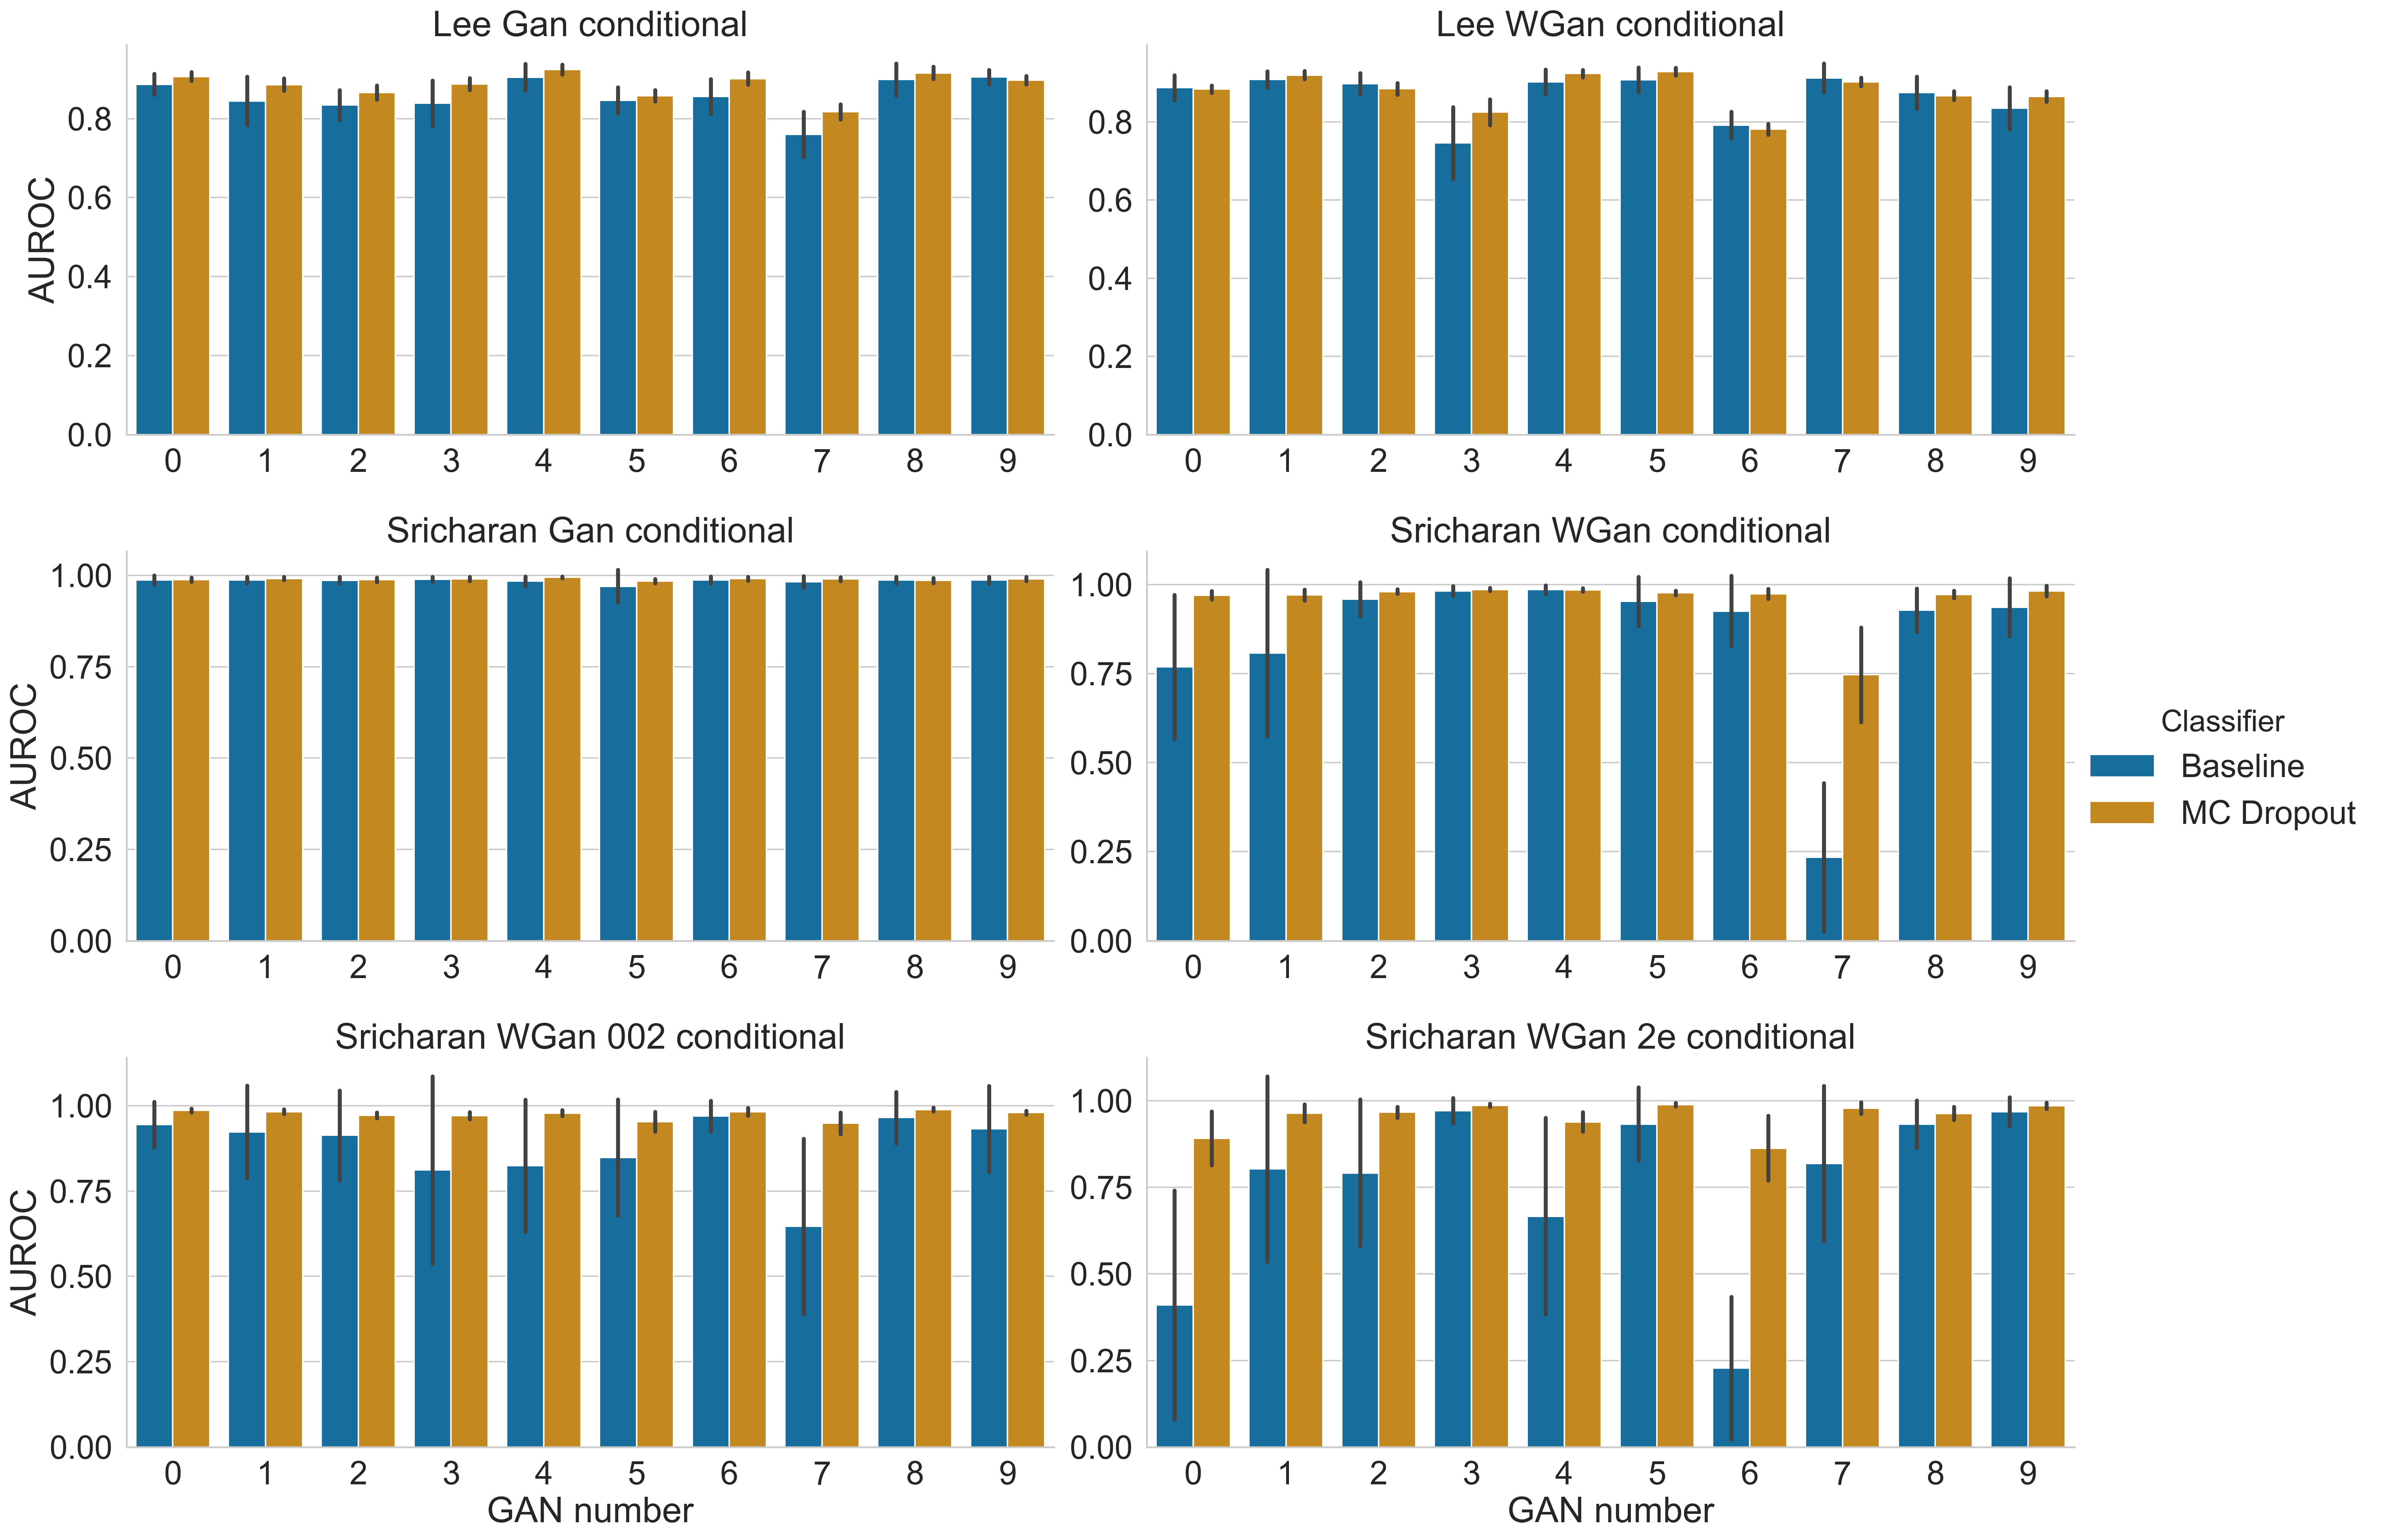

In [14]:
plt.tight_layout()
sns.set(style="whitegrid", font_scale=2)
#sns.set(font_scale=2)
#sns.set(style="whitegrid")
g = sns.catplot(x="Measure", y="ROC", data=combined_gan_raw, hue="Classifier", col="GAN", palette = sns.color_palette("colorblind"),
                kind="bar",
                height=5, aspect=2, col_wrap=2, ci="sd", sharex=False, sharey=False, legend=True);
plt.subplots_adjust(hspace=0.3, wspace=0.1)
(g.set_axis_labels("GAN number", "AUROC")
  .set_titles("{col_name}"))
#  .set(ylim=(0, 0.05))
#  .despine(left=True))
  #.set(yticks=(0.7, 0.8, 0.9, 1)))  
#plt.legend("lower left")

In [27]:
#combined_gan_raw.groupby(['GAN', 'Measure']).agg({'ROC': ['mean', 'std']})

In [46]:
labels = ['Lee Gan conditional', 'Lee WGan conditional',
       'Sricharan Gan conditional', 'Sricharan WGan conditional',
       'Sricharan WGan 002 conditional', 'Sricharan WGan 2e conditional']

lee_gan_min = combined_gan_raw[(combined_gan_raw["GAN"] == labels[0]) & (combined_gan_raw["Measure"] == "7")]
lee_wgan_min = combined_gan_raw[(combined_gan_raw["GAN"] == labels[1]) & (combined_gan_raw["Measure"] == "3")]
sricharan_gan_min = combined_gan_raw[(combined_gan_raw["GAN"] == labels[2]) & (combined_gan_raw["Measure"] == "5")]
sricharan_wgan_min = combined_gan_raw[(combined_gan_raw["GAN"] == labels[3]) & (combined_gan_raw["Measure"] == "7")]
sricharan_wgan_002_min = combined_gan_raw[(combined_gan_raw["GAN"] == labels[4]) & (combined_gan_raw["Measure"] == "7")]
sricharan_wgan_2e_min = combined_gan_raw[(combined_gan_raw["GAN"] == labels[5]) & (combined_gan_raw["Measure"] == "6")]

combined_gan_min = pd.concat([lee_gan_min, lee_wgan_min, sricharan_gan_min, sricharan_wgan_min, sricharan_wgan_002_min, sricharan_wgan_2e_min], axis = 0)

[(0, 1.05), Text(0, 0.5, 'AUROC'), Text(0.5, 0, '')]

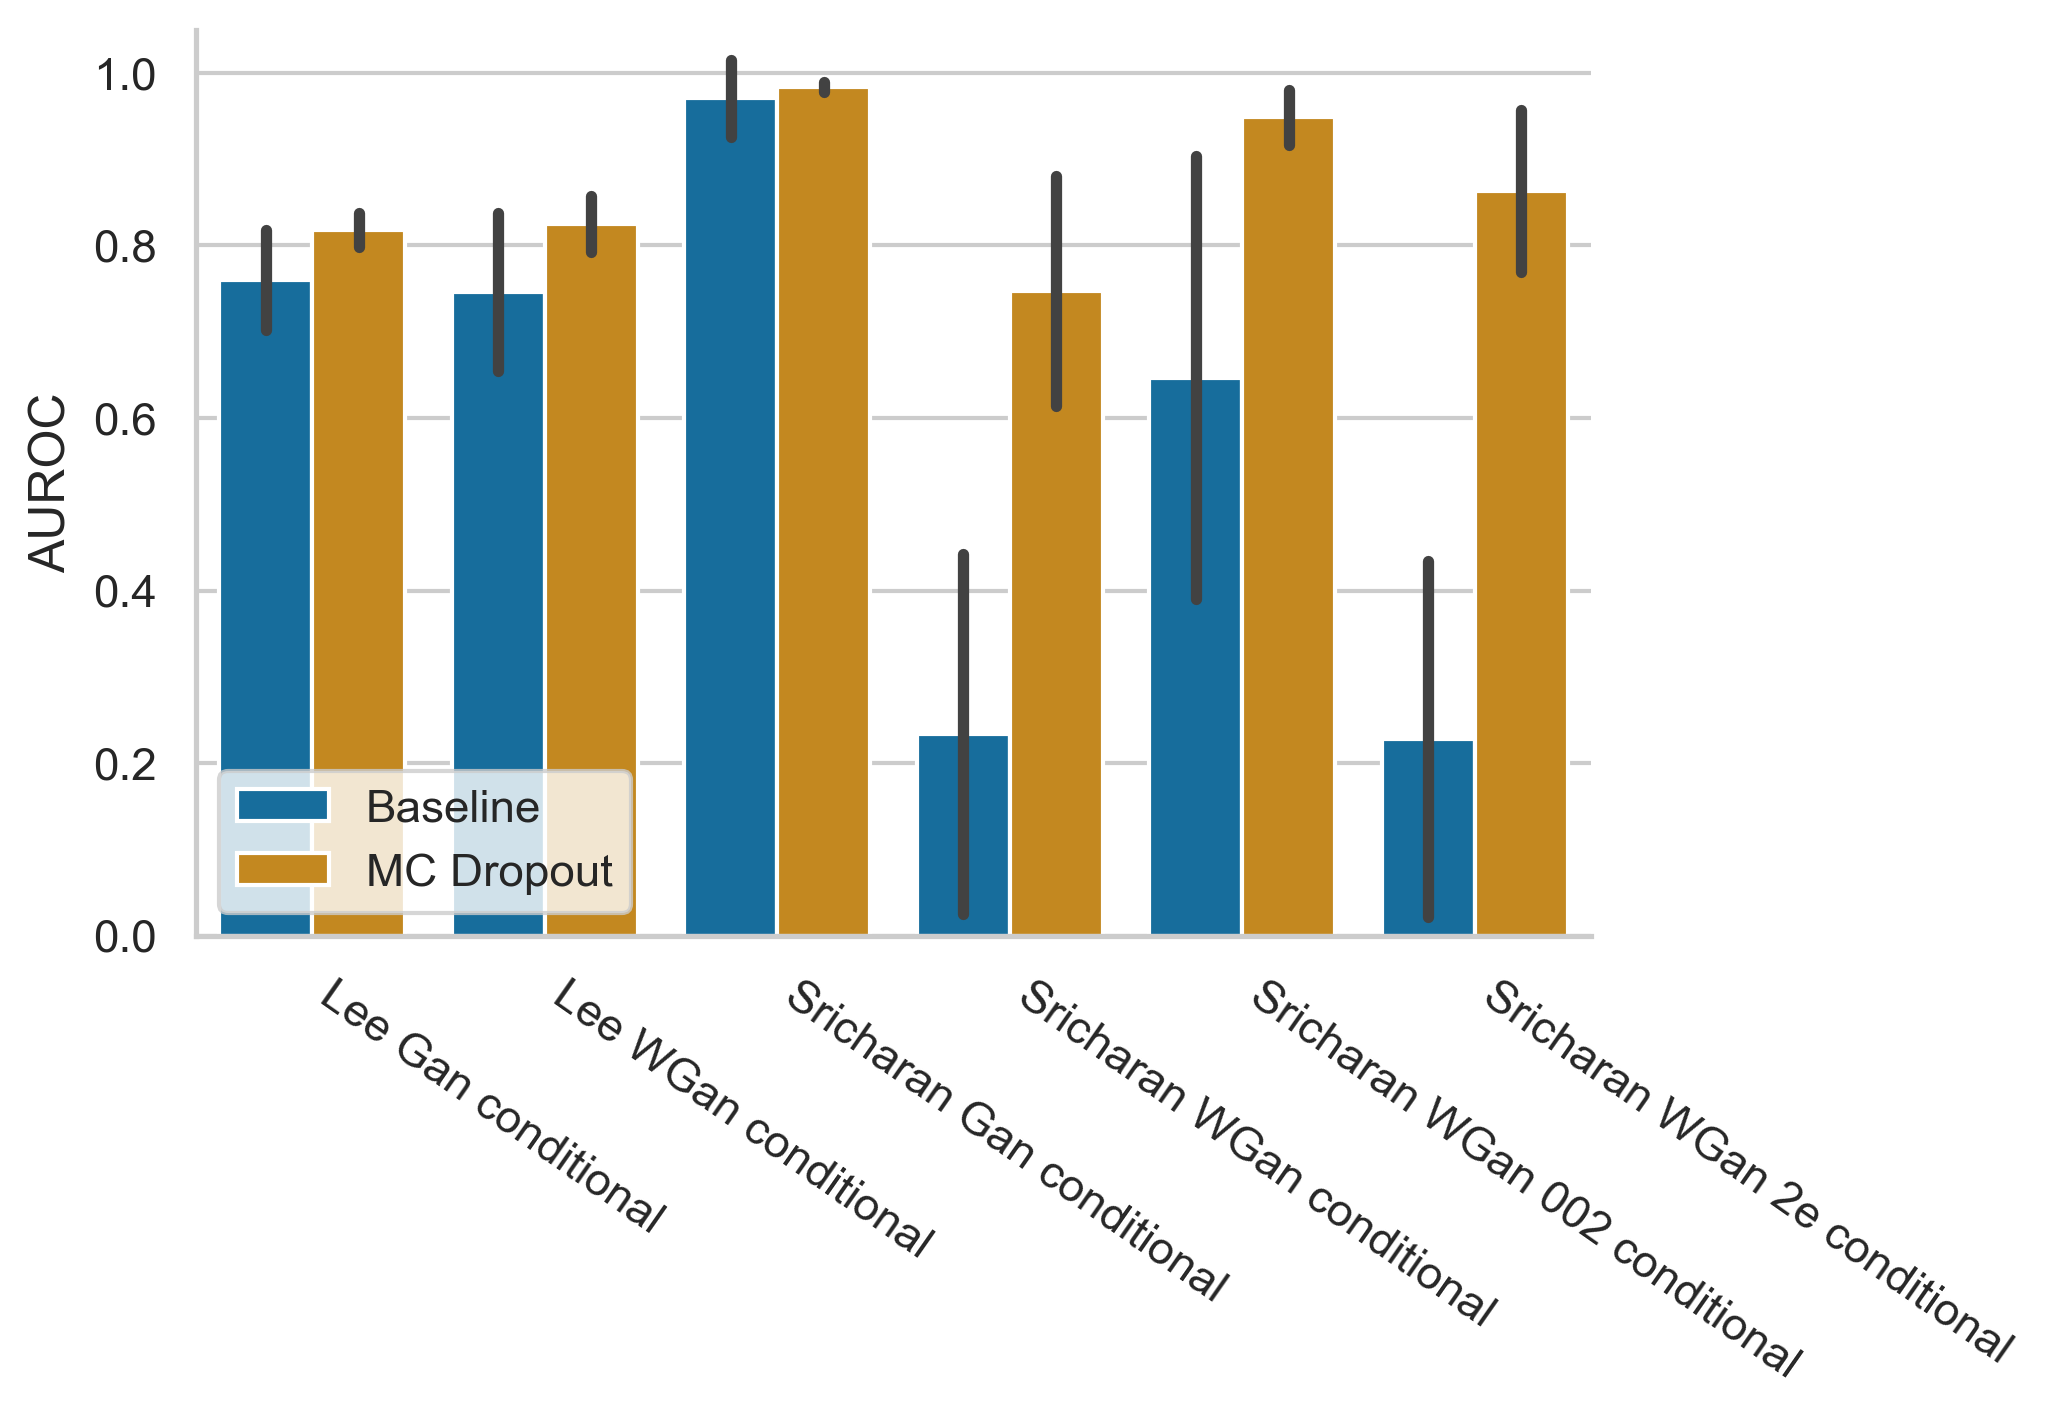

In [67]:
sns.set(font_scale=1.1)
sns.set(style="whitegrid")
labels = ['Lee Gan conditional', 'Lee WGan conditional',
       'Sricharan Gan conditional', 'Sricharan WGan conditional',
       'Sricharan WGan 002 conditional', 'Sricharan WGan 2e conditional']
ax = sns.barplot(x="GAN", y="ROC", data=combined_gan_min, hue="Classifier", order=labels, ci="sd", palette="colorblind")
#ax.set_xticklabels(["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"])
sns.despine()
plt.legend(loc='lower left')
ax.set_xticklabels(labels, rotation=-35, ha='left')
ax.set(ylim=(0, 1.05), ylabel="AUROC", xlabel="")

In [47]:
combined_gan_raw.groupby(['GAN', 'Classifier']).agg({'ROC': ['mean', 'std']})

In [64]:
print(combined_gan_min.pivot_table(index="GAN",columns="Classifier", values="ROC", 
                             aggfunc=[np.mean, np.std]).swaplevel(i=-2, j=-1, axis=1).round(4).to_latex())
#combined_gan_raw.reindex(pd.MultiIndex.from_product([["Baseline", "MC Dropout"], ["mean", "std"]]), axis=1) 
#combined_gan_raw.reindex([("Baseline", "mean"), ("Baseline", "std"), 
#                                  ("MC Dropout", "mean"), ("MC Dropout", "std")], axis=0) 

\begin{tabular}{lrrrr}
\toprule
Classifier & Baseline & MC Dropout & Baseline & MC Dropout \\
{} &     mean &       mean &      std &        std \\
GAN                            &          &            &          &            \\
\midrule
Lee Gan conditional            &   0.7601 &     0.8177 &   0.0592 &     0.0198 \\
Lee WGan conditional           &   0.7462 &     0.8250 &   0.0942 &     0.0335 \\
Sricharan Gan conditional      &   0.9703 &     0.9839 &   0.0459 &     0.0060 \\
Sricharan WGan 002 conditional &   0.6469 &     0.9486 &   0.2632 &     0.0326 \\
Sricharan WGan 2e conditional  &   0.2278 &     0.8631 &   0.2116 &     0.0960 \\
Sricharan WGan conditional     &   0.2340 &     0.7467 &   0.2141 &     0.1367 \\
\bottomrule
\end{tabular}



In [65]:
combined_gan_min.to_csv(DRIVE_PATH + 'Results/Ood_results_gan_combined_min.csv')

In [16]:
print(combined_gan_raw.groupby('GAN').agg({'ROC': 'mean'}).to_latex())

\begin{tabular}{lr}
\toprule
{} &       ROC \\
GAN                            &           \\
\midrule
Lee Gan conditional            &  0.872124 \\
Lee WGan conditional           &  0.872457 \\
Sricharan Gan conditional      &  0.987106 \\
Sricharan WGan 002 conditional &  0.926050 \\
Sricharan WGan 2e conditional  &  0.852530 \\
Sricharan WGan conditional     &  0.901209 \\
\bottomrule
\end{tabular}



In [21]:
ood_path = DRIVE_PATH + 'Results/Ood_results_final.p'
ood_baseline, ood_mc = load_results(ood_path)

In [22]:
ood_baseline

ROC           PR IN          PR OUT         MEAN REAL  \
                   mean     std    mean     std    mean     std      mean   
Uniform noise    0.9862  0.0208  0.9919  0.0120  0.9634  0.0475     0.982   
Normal noise     0.9846  0.0115  0.9905  0.0071  0.9614  0.0274     0.982   
Tiny ImageNet    0.9490  0.0128  0.9468  0.0137  0.9401  0.0141     0.982   
Shuffled images  0.9697  0.0213  0.9739  0.0244  0.9583  0.0200     0.982   
Mixed images     0.8985  0.0187  0.8887  0.0223  0.8869  0.0176     0.982   
Swirled images   0.8283  0.0337  0.8080  0.0406  0.8251  0.0335     0.982   
Color swap       0.8487  0.0745  0.8222  0.0948  0.8496  0.0630     0.982   

                        MEAN FAKE          
                    std      mean     std  
Uniform noise    0.0032    0.5321  0.1740  
Normal noise     0.0032    0.6121  0.1394  
Tiny ImageNet    0.0032    0.6897  0.0263  
Shuffled images  0.0032    0.6263  0.0775  
Mixed images     0.0032    0.7979  0.0124  
Swirled images   0.0032    0.8476  0.0324  
Color swap       0.0032    0.8141  0.0519

In [23]:
ood_mc

ROC           PR IN          PR OUT         MEAN REAL  \
                   mean     std    mean     std    mean     std      mean   
Uniform noise    0.9880  0.0053  0.9932  0.0028  0.9627  0.0190    0.9046   
Normal noise     0.9906  0.0045  0.9943  0.0025  0.9738  0.0147    0.9044   
Tiny ImageNet    0.9821  0.0036  0.9870  0.0029  0.9688  0.0065    0.9045   
Shuffled images  0.9893  0.0040  0.9930  0.0024  0.9799  0.0094    0.9044   
Mixed images     0.9252  0.0067  0.9323  0.0074  0.8858  0.0070    0.9045   
Swirled images   0.9359  0.0128  0.9432  0.0157  0.9090  0.0129    0.9043   
Color swap       0.8946  0.0391  0.8815  0.0468  0.8712  0.0333    0.9043   

                        MEAN FAKE          
                    std      mean     std  
Uniform noise    0.0075    0.3393  0.0672  
Normal noise     0.0075    0.3100  0.0618  
Tiny ImageNet    0.0074    0.3758  0.0258  
Shuffled images  0.0075    0.3162  0.0502  
Mixed images     0.0076    0.6044  0.0100  
Swirled images   0.0076    0.5455  0.0261  
Color swap       0.0075    0.6043  0.0533

In [24]:
def combine_ood_df(baseline, mc):
    roc_b = baseline.loc[:,"ROC"]
    roc_mc = mc.loc[:,"ROC"]
    roc_mc.columns = ["mean_mc", "std_mc"]
    roc = pd.concat([roc_b, roc_mc], axis=1)
    index = pd.MultiIndex.from_tuples([('Baseline', 'mean'), ('Baseline', 'std'), ('MC Dropout', 'mean'), ('MC Dropout', 'std')])
    roc.columns = index
    #roc = roc.reindex([('Baseline', 'mean'), ('Baseline', 'std'), ('MC Dropout', 'mean'), ('MC Dropout', 'std')], axis=1)
    return roc

ood_df = combine_ood_df(ood_baseline, ood_mc)

In [25]:
ood_df

Baseline         MC Dropout        
                    mean     std       mean     std
Uniform noise     0.9862  0.0208     0.9880  0.0053
Normal noise      0.9846  0.0115     0.9906  0.0045
Tiny ImageNet     0.9490  0.0128     0.9821  0.0036
Shuffled images   0.9697  0.0213     0.9893  0.0040
Mixed images      0.8985  0.0187     0.9252  0.0067
Swirled images    0.8283  0.0337     0.9359  0.0128
Color swap        0.8487  0.0745     0.8946  0.0391

In [30]:
baseline, mc = ood_df.loc[:,("Baseline", "mean")], ood_df.loc[:,("MC Dropout", "mean")]
#baseline, mc = gan_res.loc[:,("Baseline", "std")], gan_res.loc[:,("MC Dropout", "std")]
res = pd.concat([baseline, mc], axis=1)
print(res.to_latex())

\begin{tabular}{lrr}
\toprule
{} & Baseline & MC Dropout \\
{} &     mean &       mean \\
\midrule
Uniform noise   &   0.9862 &     0.9880 \\
Normal noise    &   0.9846 &     0.9906 \\
Tiny ImageNet   &   0.9490 &     0.9821 \\
Shuffled images &   0.9697 &     0.9893 \\
Mixed images    &   0.8985 &     0.9252 \\
Swirled images  &   0.8283 &     0.9359 \\
Color swap      &   0.8487 &     0.8946 \\
\bottomrule
\end{tabular}



In [18]:
def t_test_for_df(df, mean="mean", sd="std"):
    for rowname in df.index:
        row = df.loc[rowname]
        mean1 = row[("Baseline", mean)]
        sd1 = row[("Baseline", sd)]
        mean2 = row[("MC Dropout", mean)]
        sd2 = row[("MC Dropout", sd)]
        print(rowname, ttest_ind_from_stats(mean1=mean1, std1=sd1, nobs1=20, mean2=mean2, std2=sd2, nobs2=20))

In [19]:
t_test_for_df(ood_df)

Uniform noise Ttest_indResult(statistic=-0.3750284863184743, pvalue=0.7097243756490867)
Normal noise Ttest_indResult(statistic=-2.1728579050204466, pvalue=0.03609414175138246)
Tiny ImageNet Ttest_indResult(statistic=-11.132734740638977, pvalue=1.593182910773832e-13)
Shuffled images Ttest_indResult(statistic=-4.044505331572823, pvalue=0.00024740115914291907)
Mixed images Ttest_indResult(statistic=-6.011166050715098, pvalue=5.495459051807336e-07)
Swirled images Ttest_indResult(statistic=-13.348550667172972, pvalue=6.355214029671719e-16)
Color swap Ttest_indResult(statistic=-2.4397194400005366, pvalue=0.019476004411690527)


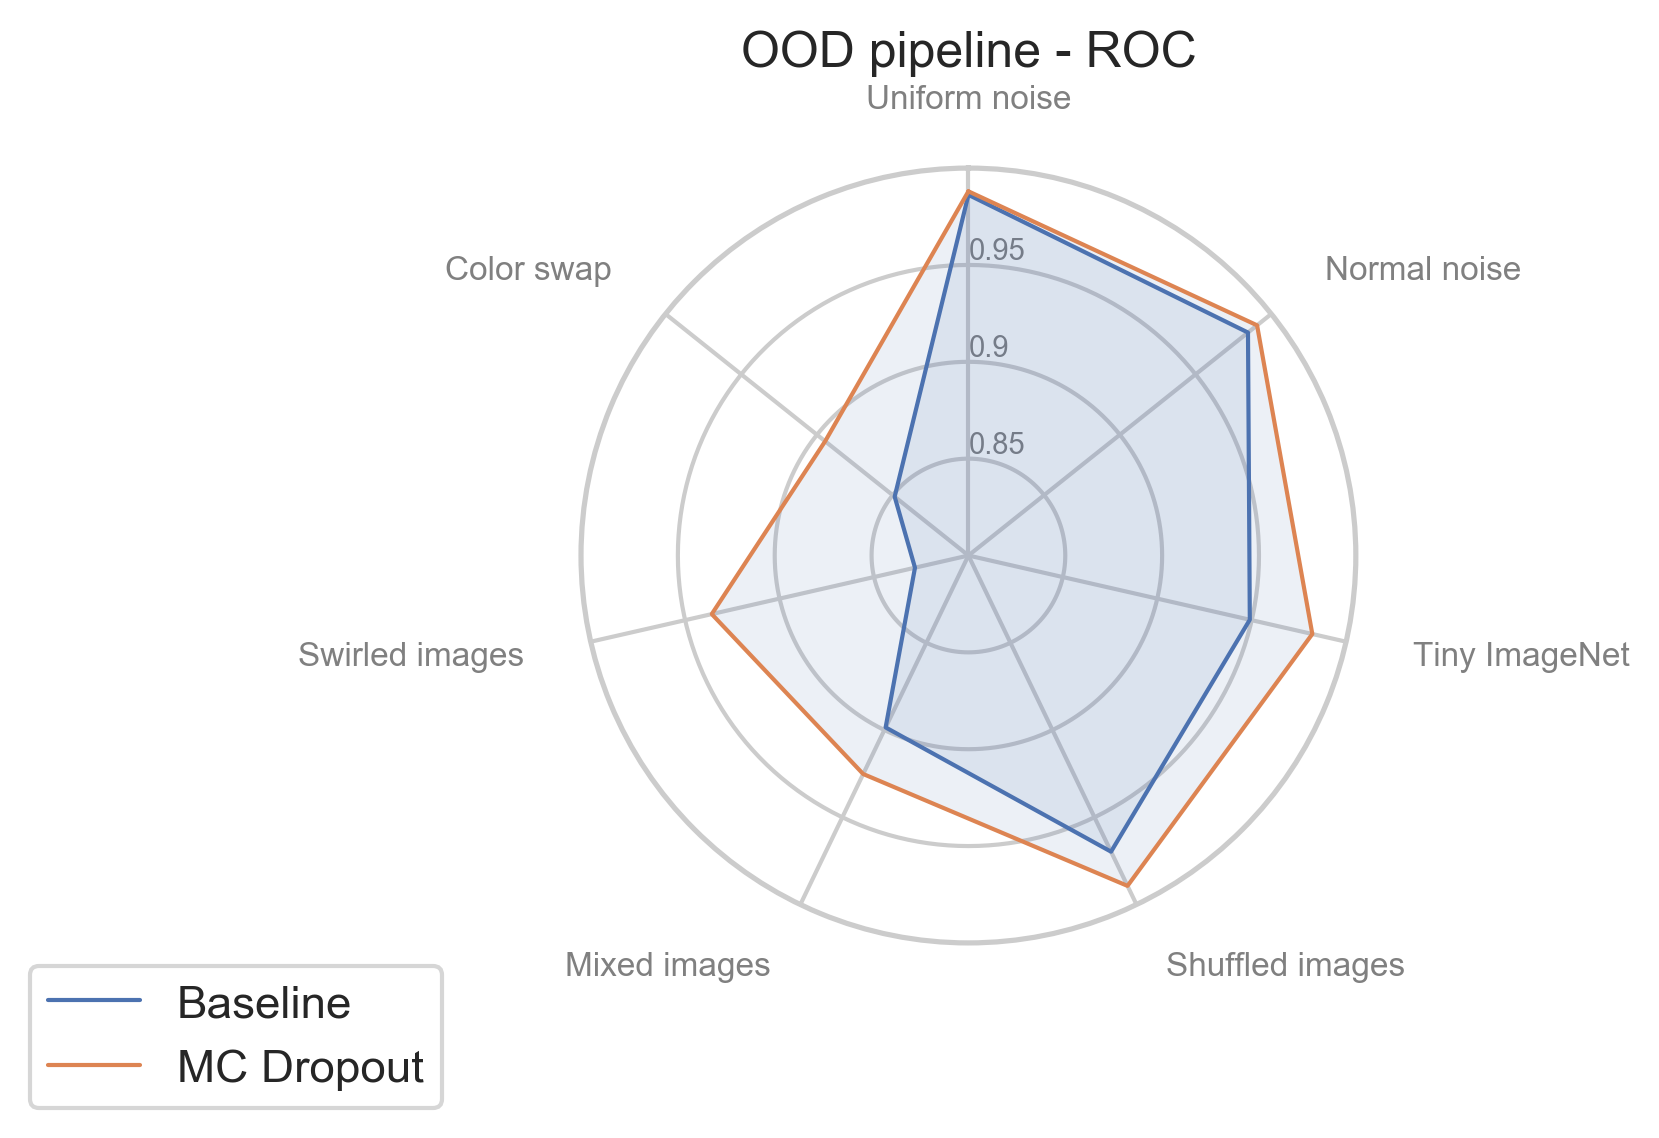

<Figure size 6000x3000 with 0 Axes>

In [27]:
# Plotting
dfs = [ood_baseline, ood_mc]
analysis.make_radar_plot(("ROC", "mean"), dfs, ["Baseline", "MC Dropout"], title="OOD pipeline - ROC", filename=DRIVE_PATH+"Results/ood_results.png")

#### OOD test with image transformations on Tiny ImageNet

In [31]:
ood_path = DRIVE_PATH + 'Results/Ood_results_transform_final.p'
ood_baseline_transform, ood_mc_transform = load_results(ood_path)

In [32]:
ood_baseline_transform

ROC           PR IN          PR OUT         MEAN REAL          \
               mean     std    mean     std    mean     std      mean     std   
None         0.9478  0.0135  0.9446  0.0157  0.9377  0.0146    0.9814  0.0029   
Noise        0.8018  0.0721  0.8224  0.0653  0.7520  0.0859    0.8349  0.0345   
Grey         0.7466  0.0451  0.8026  0.0487  0.6291  0.0349    0.8289  0.0300   
Snow         0.8243  0.0614  0.8362  0.0600  0.7881  0.0687    0.9089  0.0240   
Rain         0.7519  0.0974  0.7848  0.0877  0.7046  0.0958    0.8921  0.0304   
Fog          0.4825  0.1465  0.5797  0.1001  0.4801  0.0971    0.5602  0.0578   
Perspective  0.6054  0.0357  0.6256  0.0345  0.5647  0.0305    0.7567  0.0162   
Blur         0.8483  0.0273  0.8387  0.0290  0.8306  0.0427    0.9155  0.0140   
Rotate       0.8178  0.0216  0.8303  0.0222  0.7778  0.0256    0.8997  0.0073   
Crop         0.7200  0.0351  0.7362  0.0360  0.6712  0.0376    0.8357  0.0173   
Reflection   0.6560  0.0407  0.6770  0.0419  0.6258  0.0401    0.8783  0.0104   

            MEAN FAKE          
                 mean     std  
None           0.6851  0.0244  
Noise          0.5957  0.0596  
Grey           0.6593  0.0455  
Snow           0.6917  0.0481  
Rain           0.7435  0.0583  
Fog            0.5447  0.1269  
Perspective    0.6829  0.0293  
Blur           0.6584  0.0299  
Rotate         0.6797  0.0273  
Crop           0.6812  0.0265  
Reflection     0.7956  0.0310

In [33]:
ood_mc_transform

ROC           PR IN          PR OUT         MEAN REAL          \
               mean     std    mean     std    mean     std      mean     std   
None         0.9827  0.0031  0.9872  0.0024  0.9707  0.0057    0.9037  0.0102   
Noise        0.9312  0.0346  0.9441  0.0288  0.9034  0.0453    0.6534  0.0330   
Grey         0.8362  0.0196  0.8918  0.0139  0.7131  0.0327    0.7117  0.0199   
Snow         0.9443  0.0296  0.9544  0.0245  0.9225  0.0391    0.7158  0.0337   
Rain         0.8916  0.0653  0.9156  0.0502  0.8422  0.0899    0.6403  0.0410   
Fog          0.5406  0.1779  0.6397  0.1415  0.5101  0.1387    0.3061  0.0245   
Perspective  0.7170  0.0292  0.7457  0.0296  0.6741  0.0303    0.5490  0.0151   
Blur         0.9575  0.0116  0.9621  0.0106  0.9460  0.0149    0.7901  0.0172   
Rotate       0.9079  0.0188  0.9253  0.0146  0.8822  0.0241    0.7578  0.0140   
Crop         0.8141  0.0308  0.8390  0.0280  0.7672  0.0406    0.6179  0.0146   
Reflection   0.7870  0.0272  0.8059  0.0250  0.7632  0.0348    0.6676  0.0163   

            MEAN FAKE          
                 mean     std  
None           0.3712  0.0185  
Noise          0.3117  0.0428  
Grey           0.3715  0.0299  
Snow           0.3331  0.0428  
Rain           0.3344  0.0548  
Fog            0.2715  0.0579  
Perspective    0.3861  0.0143  
Blur           0.3565  0.0226  
Rotate         0.3807  0.0238  
Crop           0.3662  0.0199  
Reflection     0.4480  0.0192

In [35]:
ood_transformed_df = combine_ood_df(ood_baseline_transform, ood_mc_transform)

baseline, mc = ood_transformed_df.loc[:,("Baseline", "mean")], ood_transformed_df.loc[:,("MC Dropout", "mean")]
#baseline, mc = gan_res.loc[:,("Baseline", "std")], gan_res.loc[:,("MC Dropout", "std")]
res = pd.concat([baseline, mc], axis=1)
print(res.to_latex())

\begin{tabular}{lrr}
\toprule
{} & Baseline & MC Dropout \\
{} &     mean &       mean \\
\midrule
None        &   0.9478 &     0.9827 \\
Noise       &   0.8018 &     0.9312 \\
Grey        &   0.7466 &     0.8362 \\
Snow        &   0.8243 &     0.9443 \\
Rain        &   0.7519 &     0.8916 \\
Fog         &   0.4825 &     0.5406 \\
Perspective &   0.6054 &     0.7170 \\
Blur        &   0.8483 &     0.9575 \\
Rotate      &   0.8178 &     0.9079 \\
Crop        &   0.7200 &     0.8141 \\
Reflection  &   0.6560 &     0.7870 \\
\bottomrule
\end{tabular}



In [53]:
t_test_for_df(ood_transformed_df)

None Ttest_indResult(statistic=-11.268035452297697, pvalue=1.117152827924565e-13)
Noise Ttest_indResult(statistic=-7.236184739052211, pvalue=1.1809525823642785e-08)
Grey Ttest_indResult(statistic=-8.14853608288671, pvalue=7.27996314481498e-10)
Snow Ttest_indResult(statistic=-7.873195445898639, pvalue=1.6731166988072789e-09)
Rain Ttest_indResult(statistic=-5.327784274280819, pvalue=4.74978372616497e-06)
Fog Ttest_indResult(statistic=-1.1274577624441522, pvalue=0.266617951303067)
Perspective Ttest_indResult(statistic=-10.821368244841347, pvalue=3.638454485056076e-13)
Blur Ttest_indResult(statistic=-16.46392264897115, pvalue=6.93785828229288e-19)
Rotate Ttest_indResult(statistic=-14.071255946163417, pvalue=1.1907095905988123e-16)
Crop Ttest_indResult(statistic=-9.011801941479504, pvalue=5.6671265344263456e-11)
Reflection Ttest_indResult(statistic=-11.96776302512294, pvalue=1.849654632218441e-14)


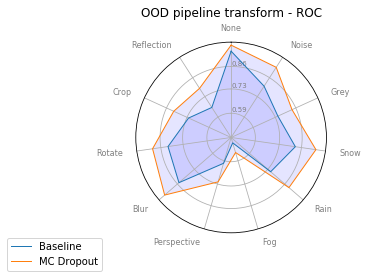

<Figure size 1440x720 with 0 Axes>

In [54]:
# Plotting
dfs = [ood_baseline_transform, ood_mc_transform]
analysis.make_radar_plot(("ROC", "mean"), dfs, ["Baseline", "MC Dropout"], title="OOD pipeline transform - ROC", filename=DRIVE_PATH+"Results/ood_results_transform.png")

In [36]:
def print_gan_res(res):
    _baseline, _mc = res
    baseline, mc = _baseline["ROC", "mean"].describe(), _mc["ROC", "mean"].describe()
    data = {'Baseline':[round(baseline["mean"], 4), round(baseline["std"], 4),round(baseline["min"], 4),round(baseline["max"], 4)],
            'MC Dropout':[round(mc["mean"], 4),round(mc["std"], 4),round(mc["min"], 4),round(mc["max"], 4)]} 
    df = pd.DataFrame(data, index =['mean', 'std', 'min', 'max'])
    return df

In [37]:
def load_gan_res(path, name):
    print(name)
    ood_path = DRIVE_PATH + path + "_final.p"
    ood_res = load_results(ood_path)
    analysis.make_radar_plot(("ROC", "mean"), list(ood_res), ["Baseline", "MC Dropout"], title=name, filename=DRIVE_PATH+path+".png")
    #print(ood_res)
    return print_gan_res(ood_res), ood_res

In [38]:
#https://handbook-5-1.cochrane.org/chapter_7/table_7_7_a_formulae_for_combining_groups.htm
import math
def combine_sd(n1, m1, sd1, n2, m2, sd2):
    den_sd = (n1-1)*sd1*sd1 + (n2-1)*sd2*sd2
    den_mean = ((n1*n2)/(n1+n2))*(m1*m1+m2*m2-2*m1*m2)
    div = n1+n2-1
    sd = math.sqrt((den_sd+den_mean)/div)
    mean = (n1*m1+n2*m2)/(n1+n2)
    n = n1+n2
    return n, mean, sd

def combine_n_sd(ns, means, sds):
    n, mean, sd = ns[0], means[0], sds[0]
    for new_n, new_mean, new_sd in list(zip(ns, means, sds))[1:]:
        n, mean, sd = combine_sd(n, mean, sd, new_n, new_mean, new_sd)
    return n, mean, sd

def gan_ttest(path, name):
    
    ood_path = DRIVE_PATH + path + ".p"
    ood_res = load_results(ood_path)
    baseline, mc = ood_res
    
    baseline_means = list(baseline.loc[:,("ROC", "mean")])
    baseline_sds = list(baseline.loc[:,("ROC", "std")])
    mc_means = list(mc.loc[:,("ROC", "mean")])
    mc_sds = list(mc.loc[:,("ROC", "std")])
    
    baseline_stat = combine_n_sd([10]*10, baseline_means, baseline_sds)
    mc_stat = combine_n_sd([10]*10, mc_means, mc_sds)
    print("Baseline", baseline_stat)
    print("MC", mc_stat)
    print(ttest_ind_from_stats(mean1=baseline_stat[1], std1=baseline_stat[2], nobs1=100, mean2=mc_stat[1], std2=mc_stat[2], nobs2=100))

#### Lee GAN

Lee GAN
Baseline (100, 0.8528500000000001, 0.06880501508618482)
MC (100, 0.8655200000000001, 0.055555184140172305)
Ttest_indResult(statistic=-1.4327127187363928, pvalue=0.15351690239882843)


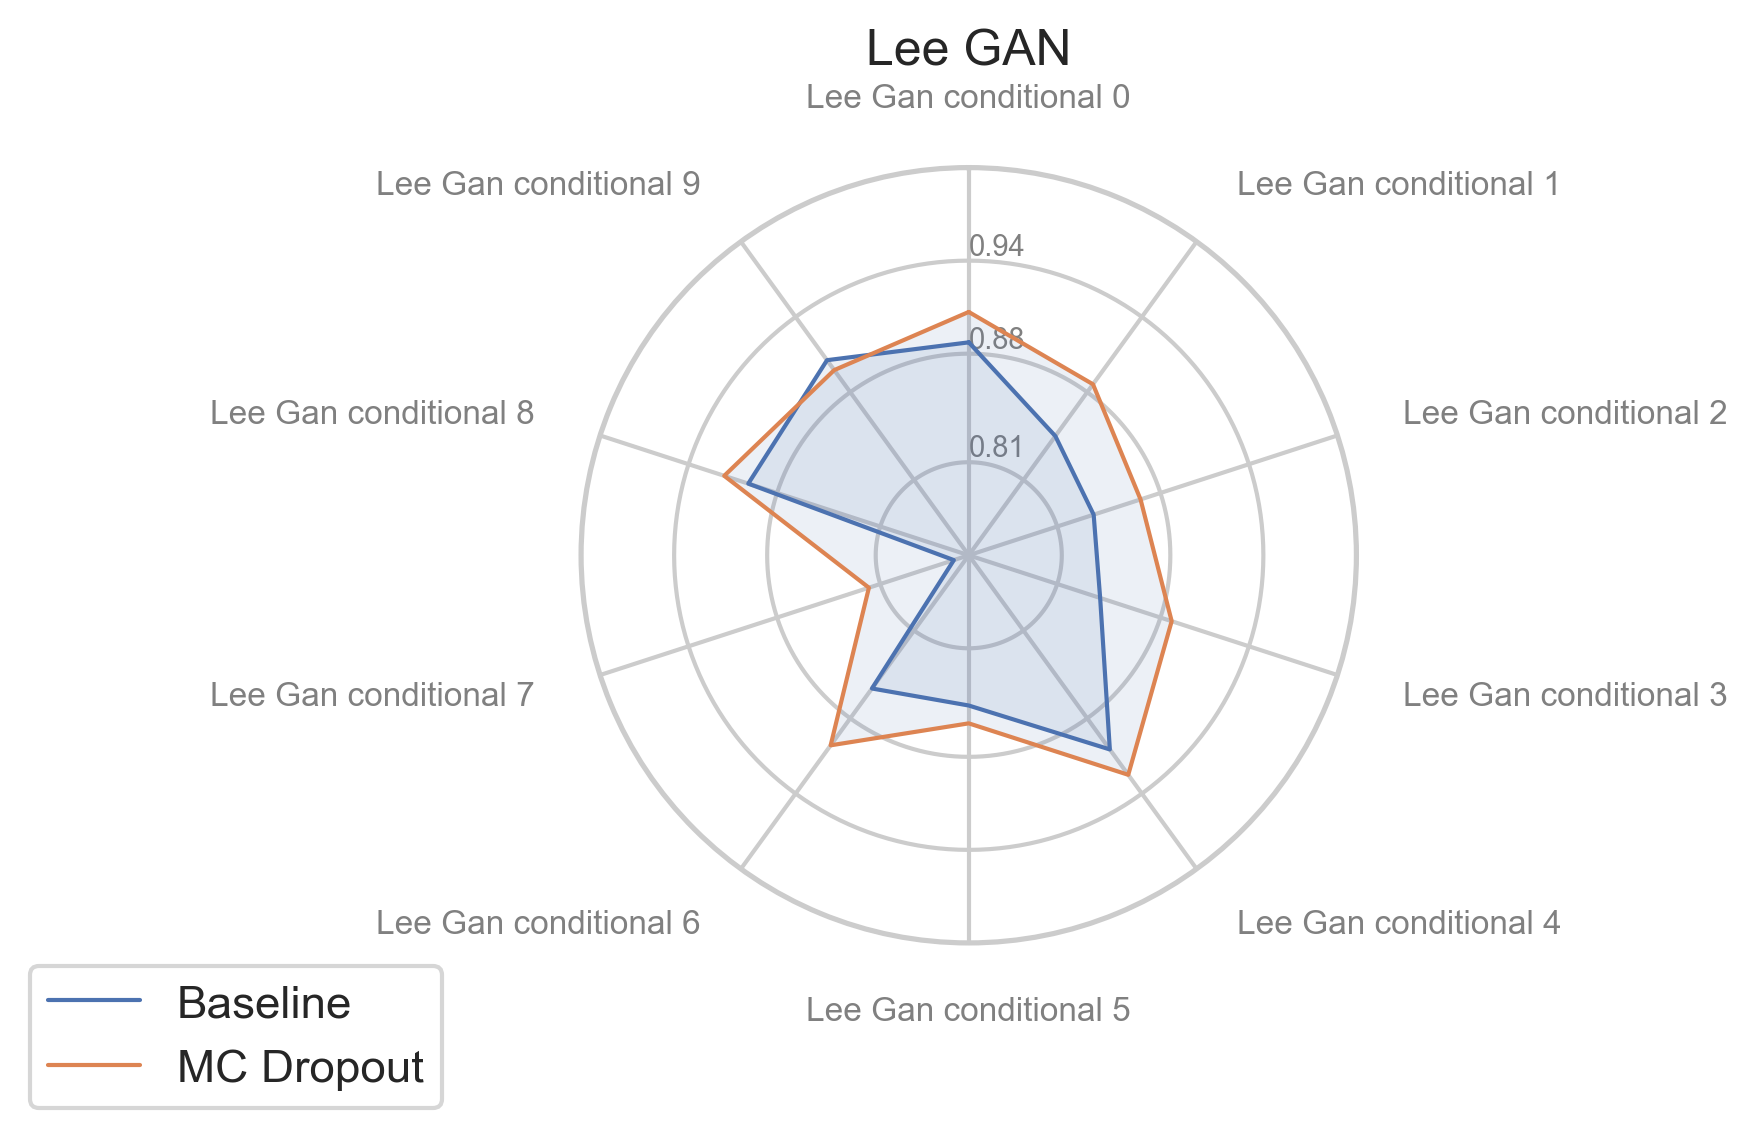

<Figure size 6000x3000 with 0 Axes>

In [39]:
lee = load_gan_res('Results/Ood_results_lee_gan', "Lee GAN")
gan_ttest('Results/Ood_results_lee_gan', "Lee GAN")

In [40]:
# lee gan 7 t-test
mean1, sd1, mean2, sd2 = 0.7270, 0.0744, 0.7683, 0.0706
ttest_ind_from_stats(mean1=mean1, std1=sd1, nobs1=10, mean2=mean2, std2=sd2, nobs2=10)

Ttest_indResult(statistic=-1.2733504948367755, pvalue=0.21909302650657003)

Lee WGAN
Baseline (100, 0.86979, 0.055586663613830446)
MC (100, 0.8723400000000001, 0.050706068212151595)
Ttest_indResult(statistic=-0.3389177177994698, pvalue=0.7350308758575266)


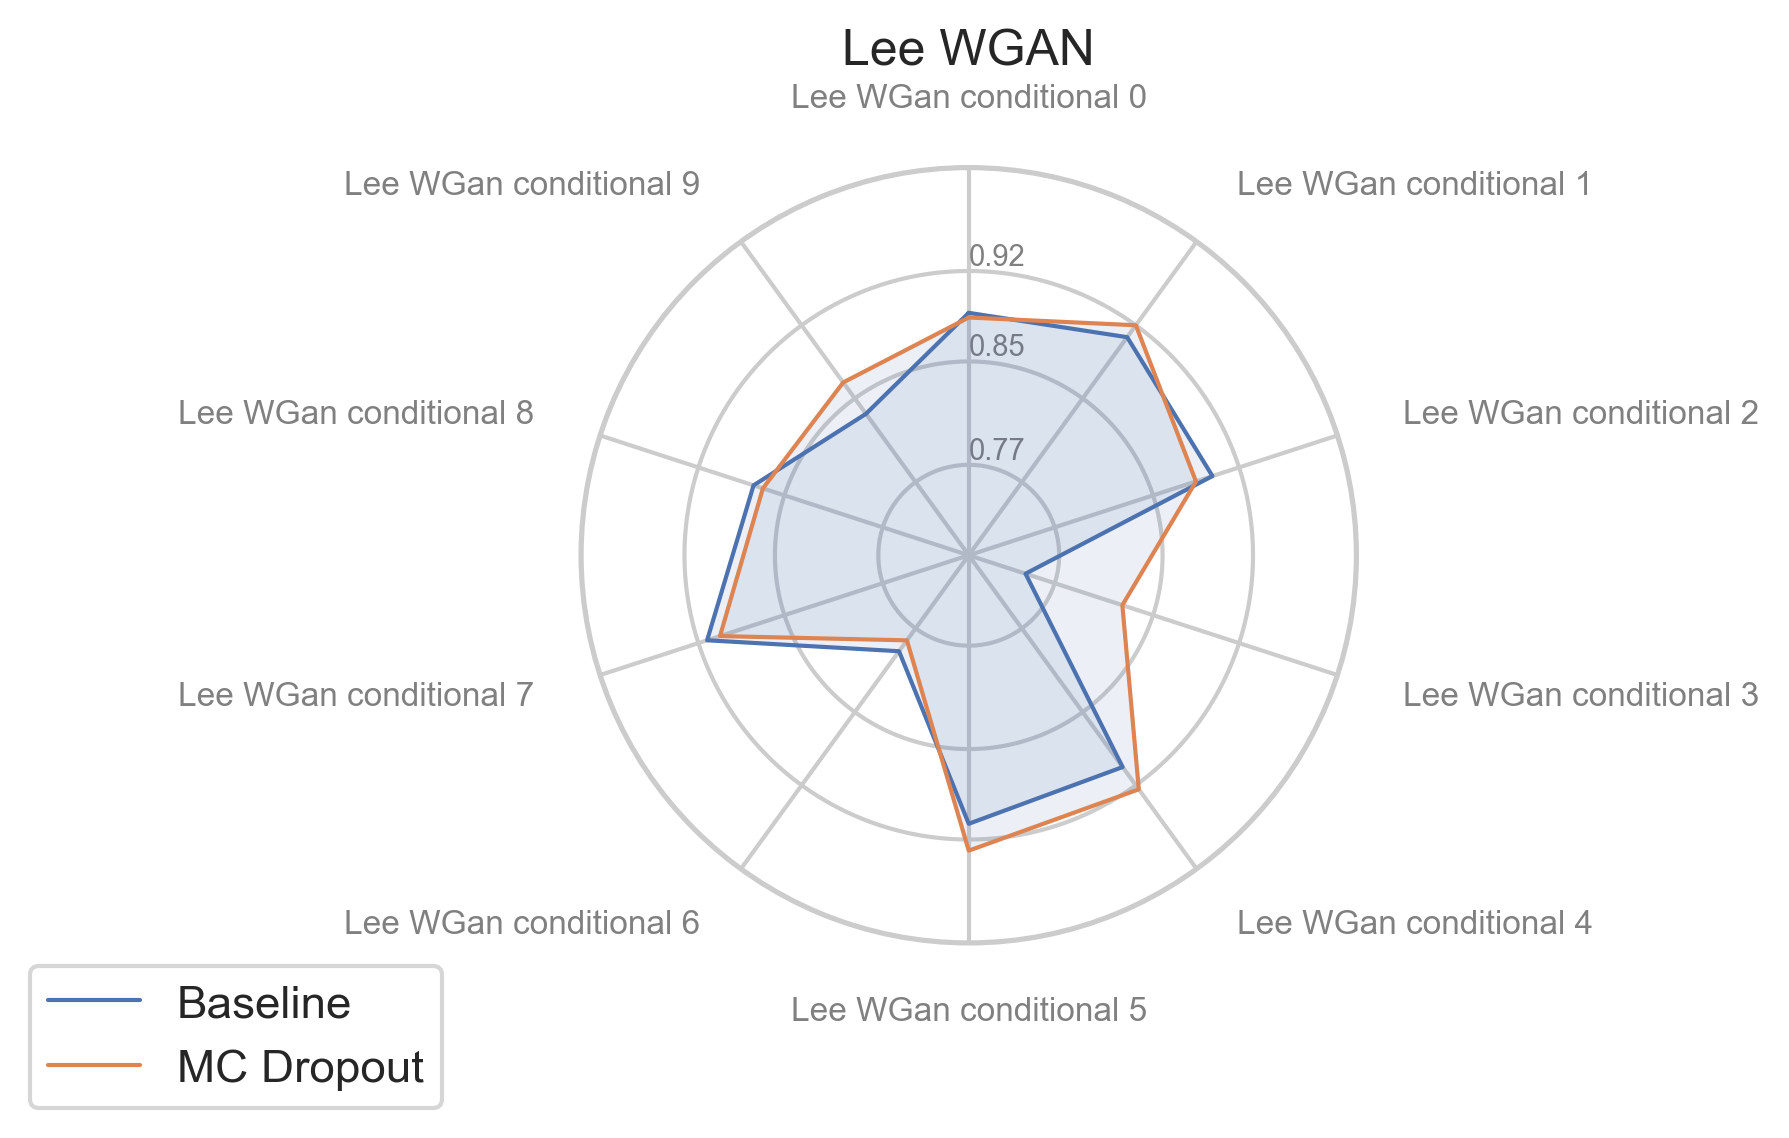

<Figure size 6000x3000 with 0 Axes>

In [41]:
lee_wgan = load_gan_res('Results/Ood_results_lee_wgan', "Lee WGAN")
gan_ttest('Results/Ood_results_lee_wgan', "Lee WGAN")

In [42]:
# lee wgan 3 t-test
mean1, sd1, mean2, sd2 = 0.7741,  0.0649, 0.7950, 0.0573
ttest_ind_from_stats(mean1=mean1, std1=sd1, nobs1=10, mean2=mean2, std2=sd2, nobs2=10)

Ttest_indResult(statistic=-0.7633993327342942, pvalue=0.45511535135533443)

Sricharan GAN
Baseline (100, 0.9821099999999998, 0.01808169452146714)
MC (100, 0.9831, 0.013614612619080745)
Ttest_indResult(statistic=-0.43739191142668987, pvalue=0.6623038490303774)


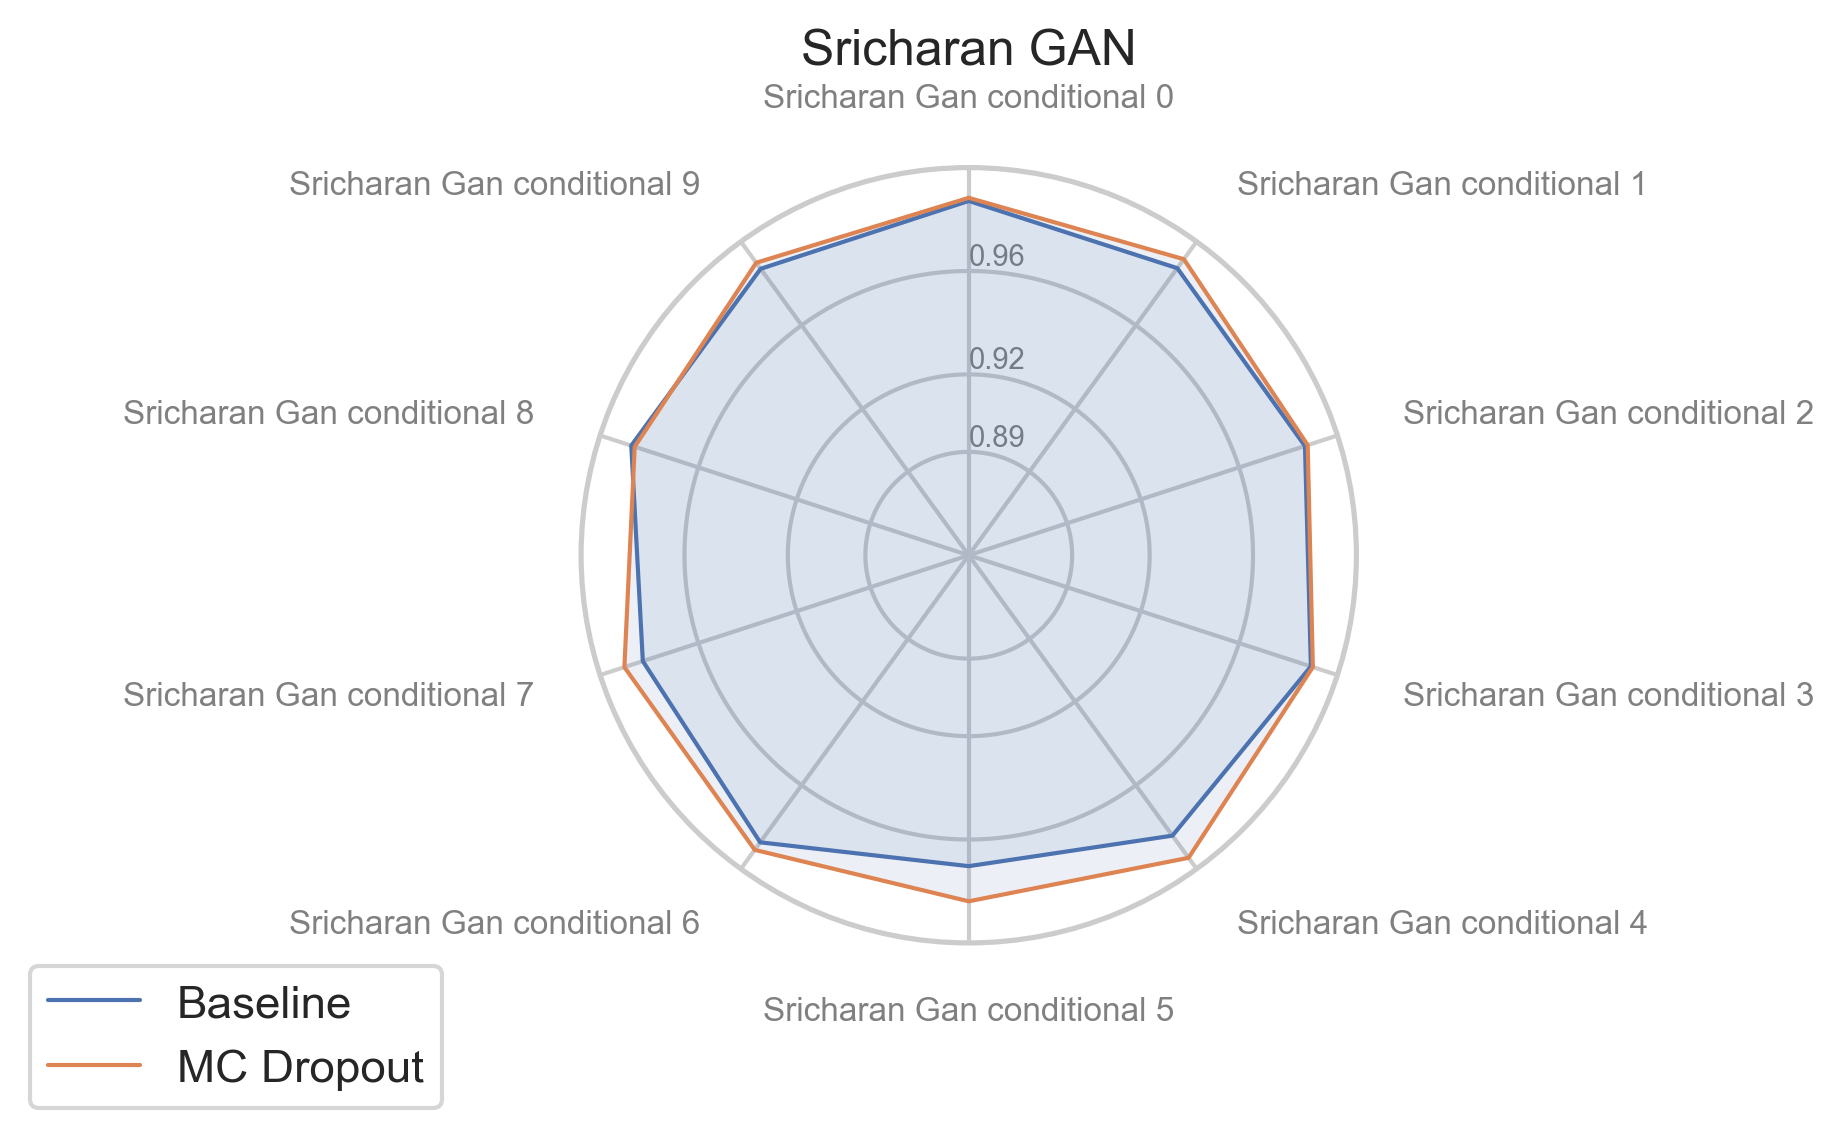

<Figure size 6000x3000 with 0 Axes>

In [43]:
sricharan = load_gan_res('Results/Ood_results_sricharan_gan', "Sricharan GAN")
gan_ttest('Results/Ood_results_sricharan_gan', "Sricharan GAN")

In [44]:
# Sricharan GAN 5 t-test
mean1, sd1, mean2, sd2 = 0.9671,  0.0252, 0.9722,  0.0189
ttest_ind_from_stats(mean1=mean1, std1=sd1, nobs1=10, mean2=mean2, std2=sd2, nobs2=10)

Ttest_indResult(statistic=-0.5119878116463084, pvalue=0.6148839020872618)

Sricharan WGAN 005
Baseline (100, 0.84967, 0.2243291266659483)
MC (100, 0.8990400000000001, 0.17539172204416065)
Ttest_indResult(statistic=-1.733766825910481, pvalue=0.08451605797542164)


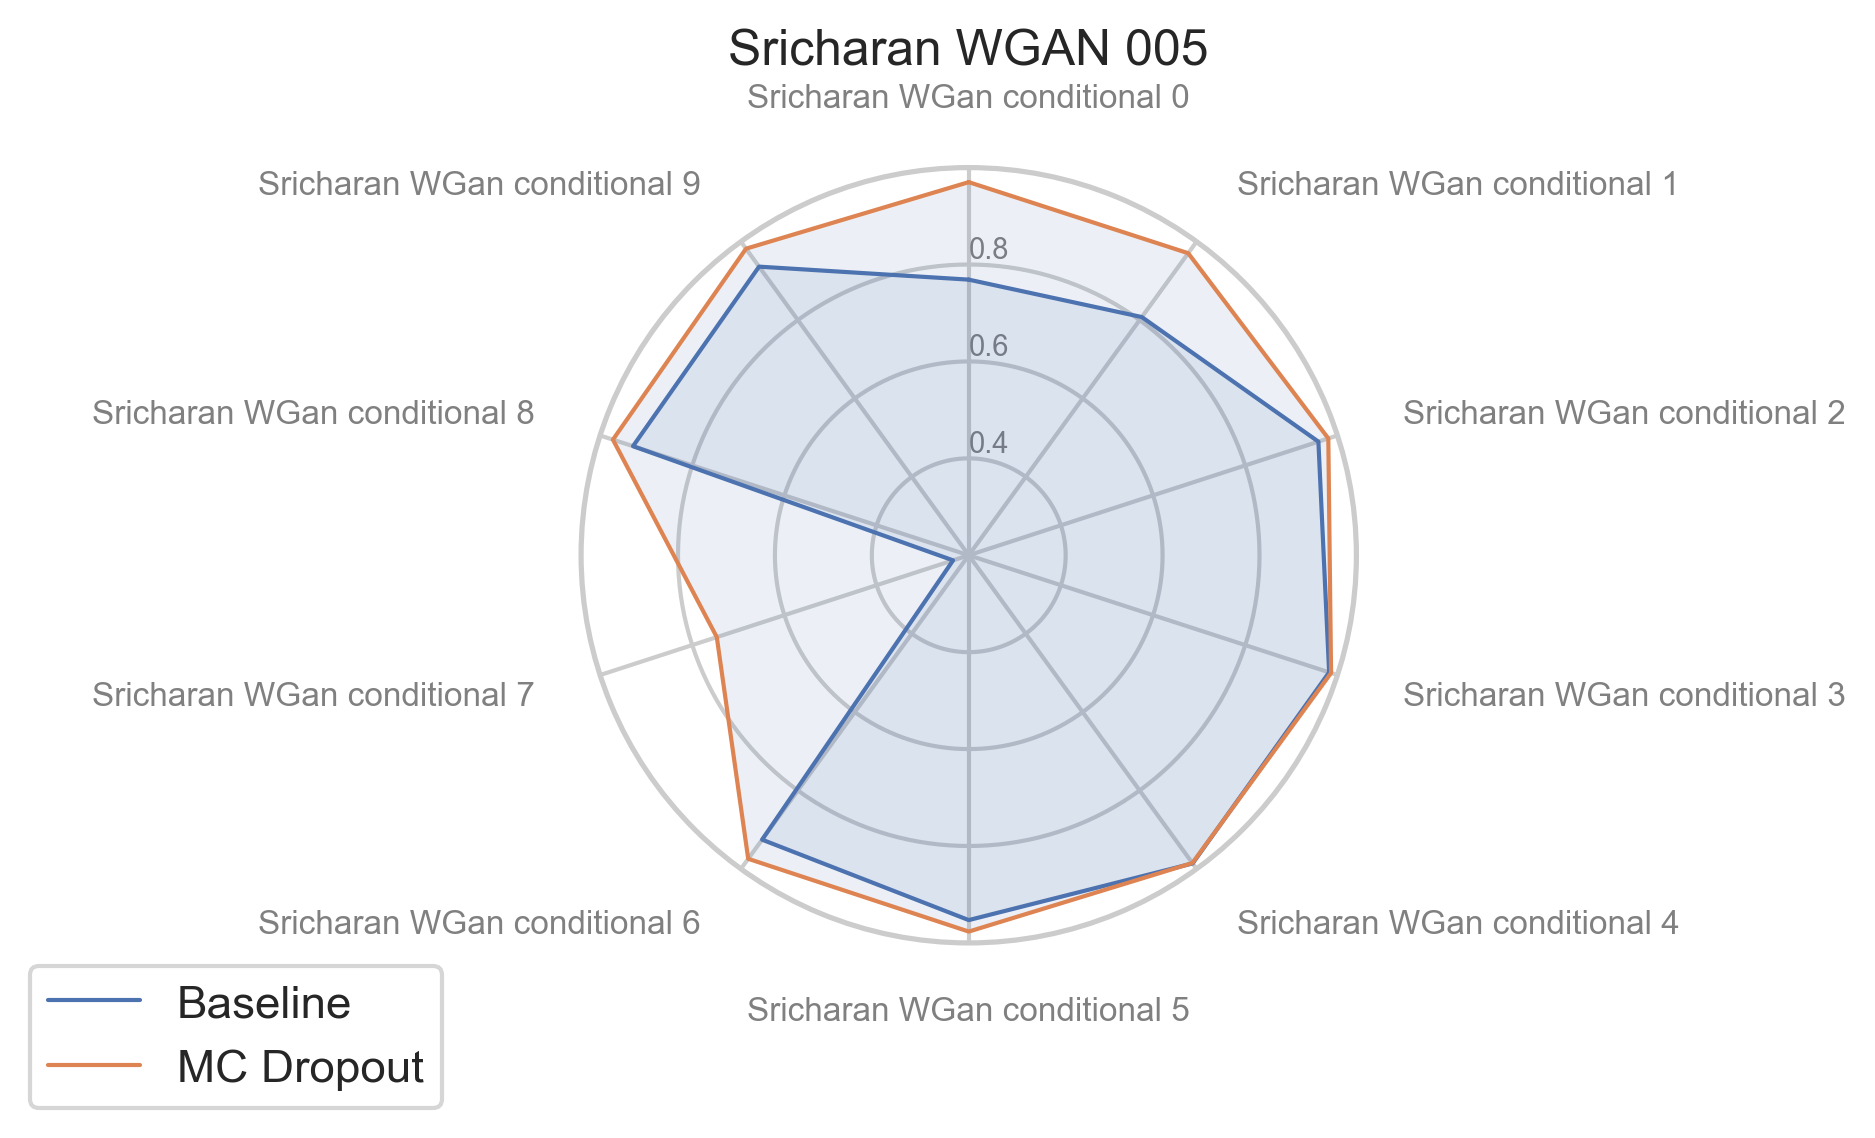

<Figure size 6000x3000 with 0 Axes>

In [45]:
sricharan_wgan_005 = load_gan_res('Results/Ood_results_sricharan_wgan', "Sricharan WGAN 005")
gan_ttest('Results/Ood_results_sricharan_wgan', "Sricharan WGAN 005")

In [46]:
# sricharan wgan 7 t-test
mean1, sd1, mean2, sd2 =0.3634,  0.3016, 0.5414,  0.2917
ttest_ind_from_stats(mean1=mean1, std1=sd1, nobs1=10, mean2=mean2, std2=sd2, nobs2=10)

Ttest_indResult(statistic=-1.3415294133574551, pvalue=0.1964299121750024)

Sricharan WGAN 002
Baseline (100, 0.8613199999999999, 0.1888583010587247)
MC (100, 0.9157499999999998, 0.14266178163542598)
Ttest_indResult(statistic=-2.299679931119407, pvalue=0.022509074314336658)


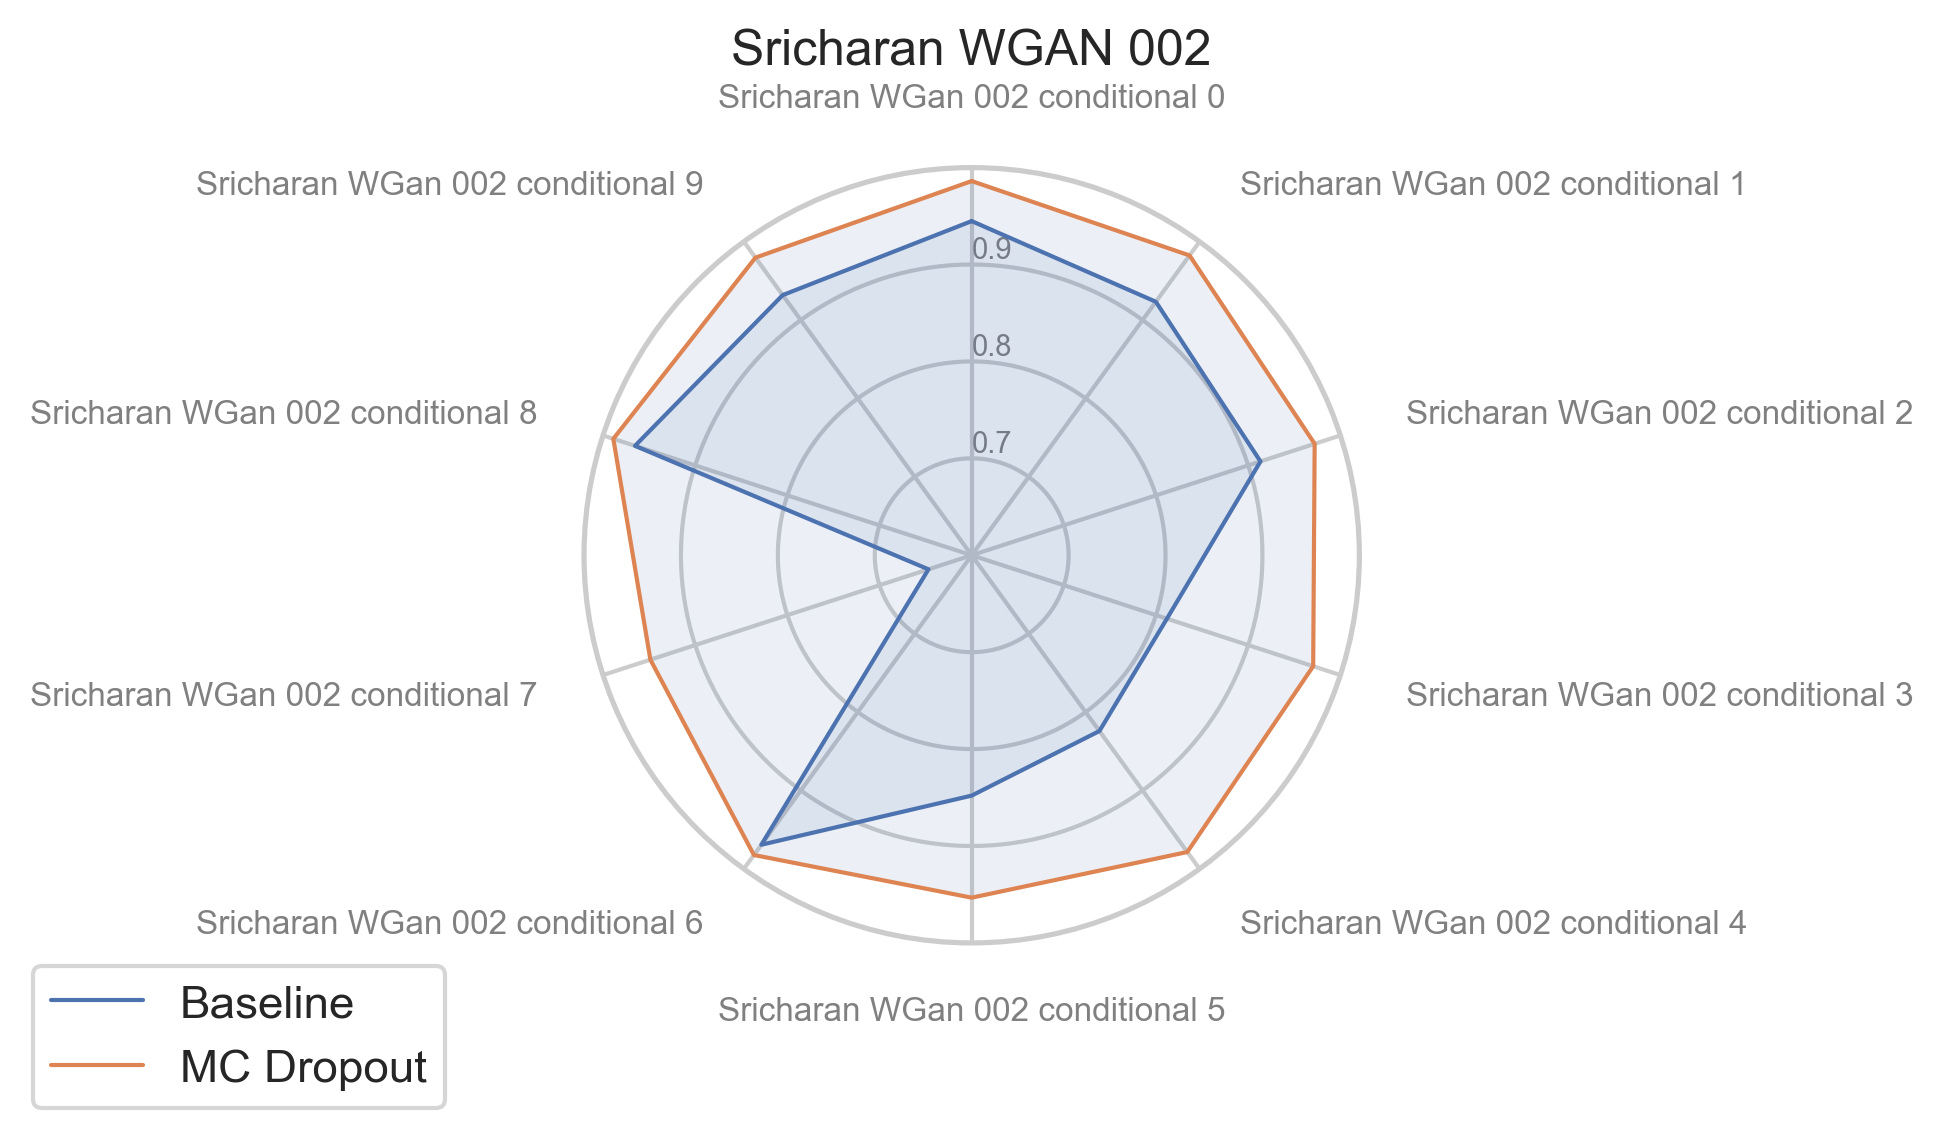

<Figure size 6000x3000 with 0 Axes>

In [47]:
sricharan_wgan_002 = load_gan_res('Results/Ood_results_sricharan_002_wgan', "Sricharan WGAN 002")
gan_ttest('Results/Ood_results_sricharan_002_wgan', "Sricharan WGAN 002")


In [48]:
# sricharan 002 wgan 7 t-test
mean1, sd1, mean2, sd2 =0.7305,  0.2719, 0.8378,  0.2196
ttest_ind_from_stats(mean1=mean1, std1=sd1, nobs1=10, mean2=mean2, std2=sd2, nobs2=10)

Ttest_indResult(statistic=-0.9708369215002268, pvalue=0.34449543118315973)

Sricharan WGAN 2 epoch


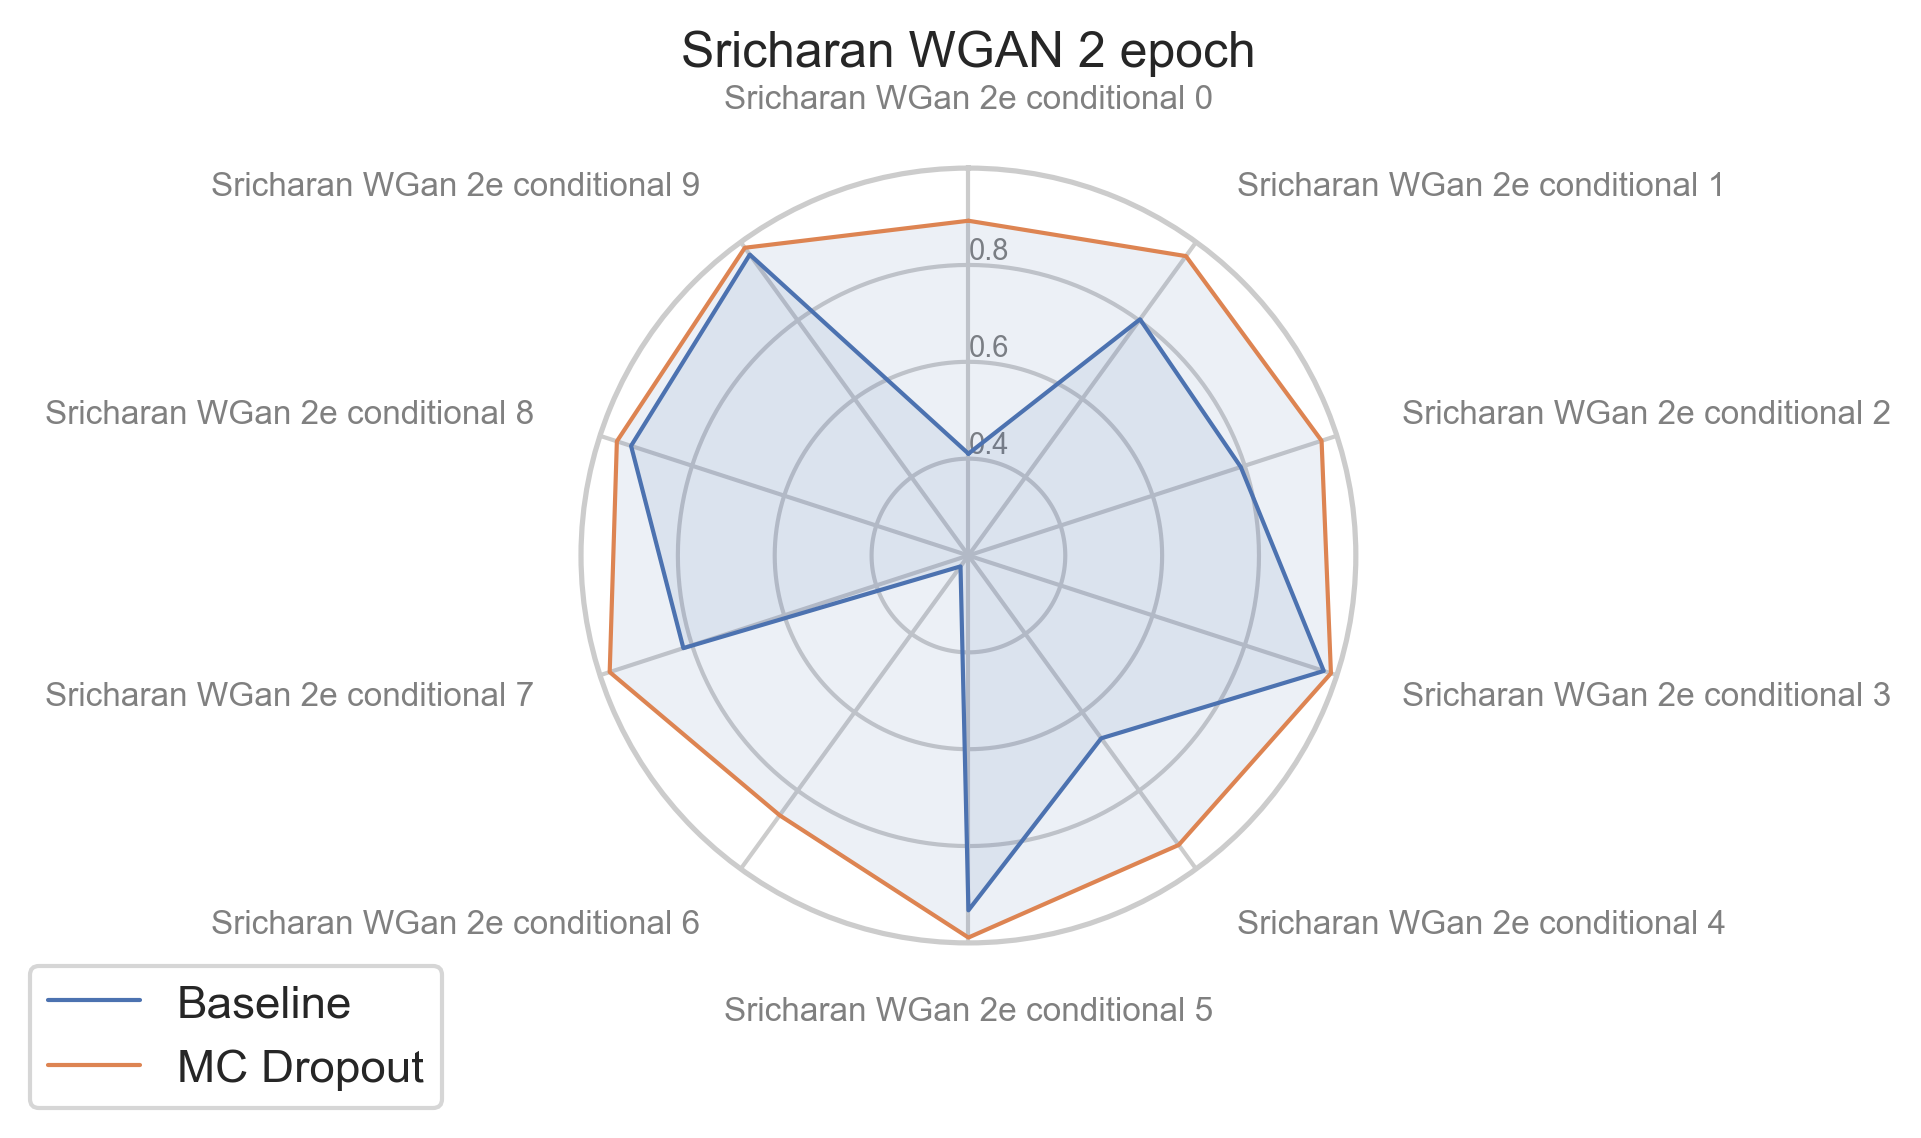

<Figure size 6000x3000 with 0 Axes>

In [49]:
sricharan_wgan_2e = load_gan_res('Results/Ood_results_sricharan_2e_wgan', "Sricharan WGAN 2 epoch")

In [77]:
# sricharan 2e wgan 6 t-test
mean1, sd1, mean2, sd2 =0.2156,  0.1933, 0.5557,  0.3725
ttest_ind_from_stats(mean1=mean1, std1=sd1, nobs1=10, mean2=mean2, std2=sd2, nobs2=10)

Ttest_indResult(statistic=-2.5627184052666, pvalue=0.019571954387588623)

In [78]:
lee

(      Baseline  MC Dropout
 mean    0.8529      0.8655
 std     0.0558      0.0428
 min     0.7270      0.7683
 max     0.9202      0.9197,
 (                          ROC           PR IN          PR OUT          \
                           mean     std    mean     std    mean     std   
  Lee Gan conditional 0  0.8986  0.0293  0.8896  0.0343  0.8736  0.0317   
  Lee Gan conditional 1  0.8401  0.0617  0.8578  0.0486  0.7986  0.0574   
  Lee Gan conditional 2  0.8098  0.0411  0.7715  0.0540  0.8143  0.0297   
  Lee Gan conditional 3  0.8456  0.0549  0.8414  0.0607  0.8344  0.0423   
  Lee Gan conditional 4  0.9202  0.0322  0.9241  0.0348  0.8885  0.0365   
  Lee Gan conditional 5  0.8550  0.0192  0.8252  0.0359  0.8479  0.0156   
  Lee Gan conditional 6  0.8650  0.0375  0.8670  0.0481  0.8396  0.0257   
  Lee Gan conditional 7  0.7270  0.0744  0.7302  0.0744  0.7131  0.0620   
  Lee Gan conditional 8  0.8567  0.0553  0.8663  0.0613  0.8234  0.0487   
  Lee Gan conditional 9  0.9105  0

In [147]:
gans = [lee, lee_wgan, sricharan, sricharan_wgan_005, sricharan_wgan_002, sricharan_wgan_2e]
names = ["Lee GAN", "Lee WGAN", "Sricharan GAN", "Sricharan WGAN 005", "Sricharan WGAN 002", "Sricharan WGAN 2 epoch"]

frames=[]
for name, gan in zip(names,gans):
    named = pd.DataFrame(gan[0].T.stack()).T
    named.index = [name]
    frames.append(named)
gan_res = pd.concat(frames)
gan_res

Baseline                         MC Dropout          \
                           mean     std     min     max       mean     std   
Lee GAN                  0.8579  0.0445  0.7601  0.9055     0.8863  0.0317   
Lee WGAN                 0.8666  0.0572  0.7462  0.9129     0.8783  0.0466   
Sricharan GAN            0.9849  0.0055  0.9703  0.9892     0.9893  0.0030   
Sricharan WGAN 005       0.8480  0.2274  0.2340  0.9861     0.9544  0.0732   
Sricharan WGAN 002       0.8779  0.0990  0.6469  0.9692     0.9742  0.0135   
Sricharan WGAN 2 epoch   0.7523  0.2511  0.2278  0.9715     0.9528  0.0431   

                                        
                           min     max  
Lee GAN                 0.8177  0.9250  
Lee WGAN                0.7814  0.9286  
Sricharan GAN           0.9839  0.9947  
Sricharan WGAN 005      0.7467  0.9862  
Sricharan WGAN 002      0.9486  0.9888  
Sricharan WGAN 2 epoch  0.8631  0.9889

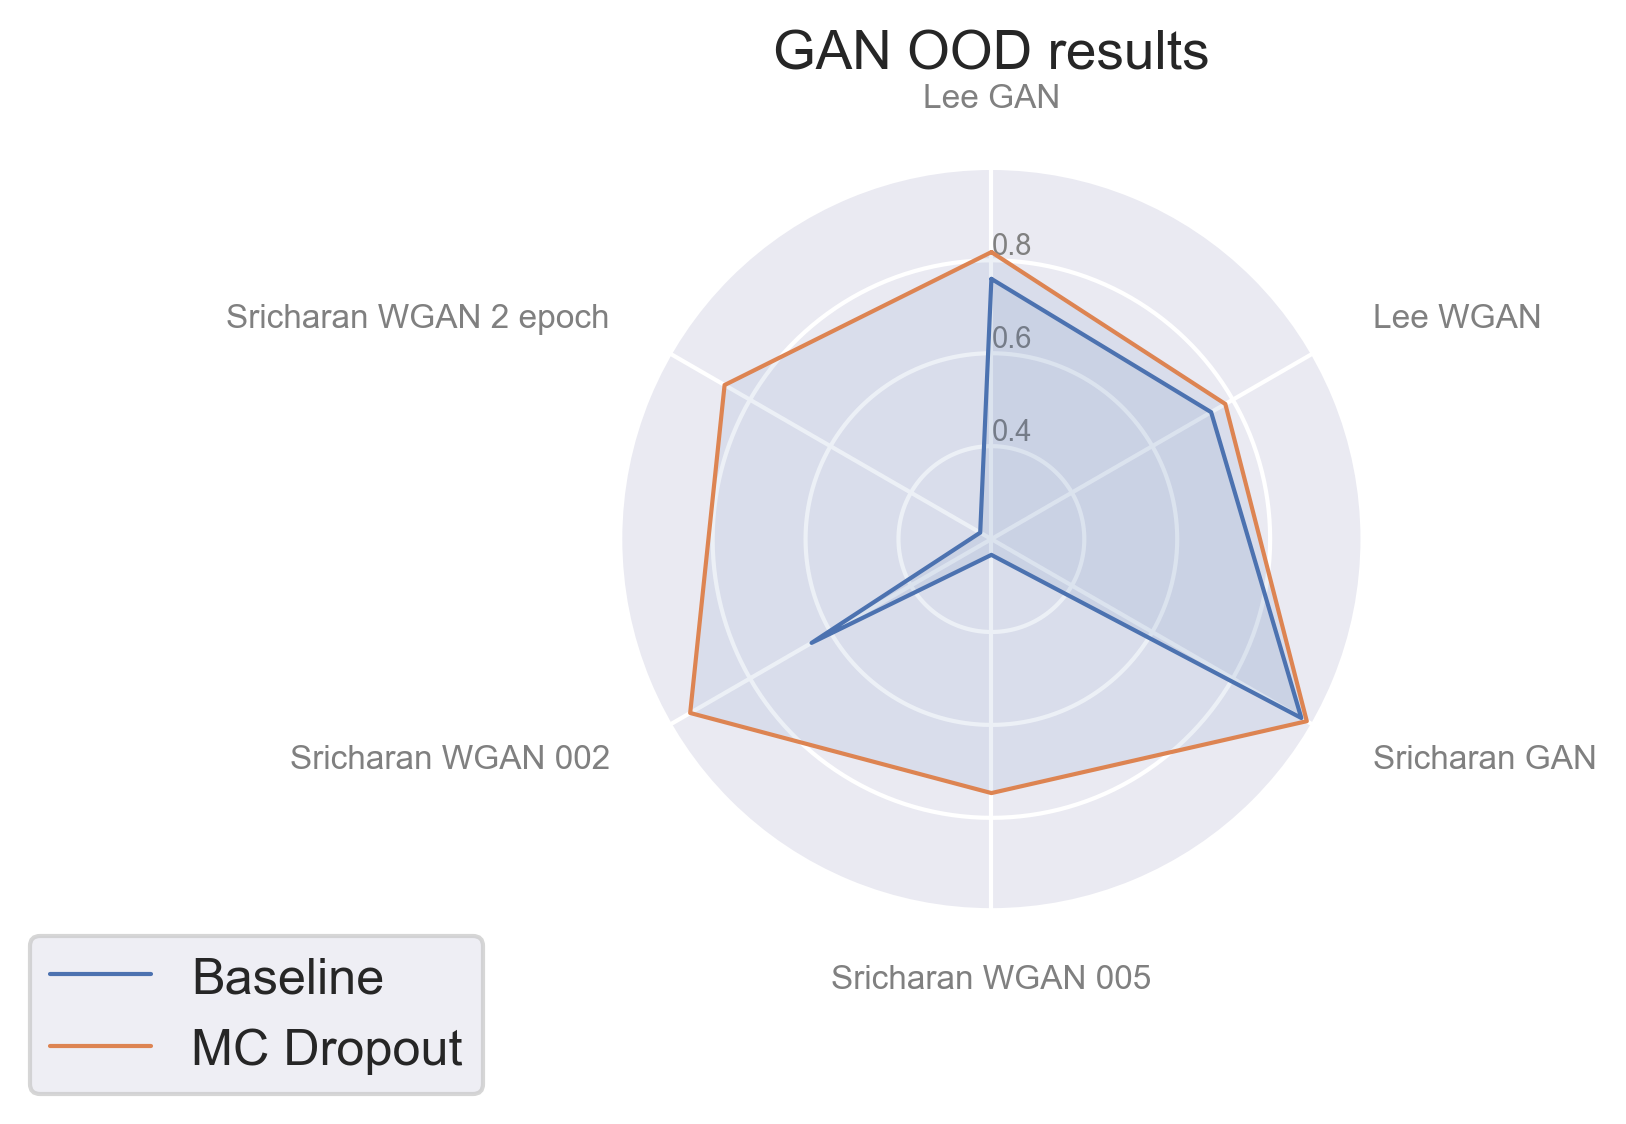

<Figure size 6000x3000 with 0 Axes>

In [148]:
gan_res_baseline = gan_res["Baseline"]
gan_res_mc = gan_res["MC Dropout"]
ood_res_l = (gan_res_baseline, gan_res_mc)

analysis.make_radar_plot(("min"), list(ood_res_l), ["Baseline", "MC Dropout"], title="GAN OOD results", filename=DRIVE_PATH+'Results/Ood_results_gan_combined'+".png")


In [52]:
t_test_for_df(gan_res)

Lee GAN Ttest_indResult(statistic=-0.5665866275448233, pvalue=0.5779922250199199)
Lee WGAN Ttest_indResult(statistic=-0.11517289187033085, pvalue=0.9095831762016637)
Sricharan GAN Ttest_indResult(statistic=-0.43798187405723304, pvalue=0.6666100771355965)
Sricharan WGAN 005 Ttest_indResult(statistic=-0.7102067796270399, pvalue=0.4866761297288025)
Sricharan WGAN 002 Ttest_indResult(statistic=-1.8699381232373278, pvalue=0.07784714297904938)
Sricharan WGAN 2 epoch Ttest_indResult(statistic=-1.004961761772958, pvalue=0.32823470441690006)


In [173]:

gan_res
#baseline, mc = gan_res.loc[:,("Baseline", ("mean", "min"))], gan_res.loc[:,("MC Dropout", ("mean", "min"))]
baseline, mc = gan_res.loc[:,("Baseline", "std")], gan_res.loc[:,("MC Dropout", "std")]
res = pd.concat([baseline, mc], axis=1)
print(res.to_latex())
#res

\begin{tabular}{lrr}
\toprule
{} & Baseline & MC Dropout \\
{} &      std &        std \\
\midrule
Lee GAN                &   0.0445 &     0.0317 \\
Lee WGAN               &   0.0572 &     0.0466 \\
Sricharan GAN          &   0.0055 &     0.0030 \\
Sricharan WGAN 005     &   0.2274 &     0.0732 \\
Sricharan WGAN 002     &   0.0990 &     0.0135 \\
Sricharan WGAN 2 epoch &   0.2511 &     0.0431 \\
\bottomrule
\end{tabular}



In [57]:
#ood_df
baseline, mc = ood_df.loc[:,("Baseline", "std")], ood_df.loc[:,("MC Dropout", "std")]
res = pd.concat([baseline, mc], axis=1, keys=["Baseline", 'MC Dropout'])
print(res.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Baseline &  MC Dropout \\
\midrule
Uniform noise   &    0.0261 &      0.0190 \\
Normal noise    &    0.0070 &      0.0062 \\
Tiny ImageNet   &    0.0103 &      0.0184 \\
Shuffled images &    0.0182 &      0.0186 \\
Mixed images    &    0.0164 &      0.0168 \\
Swirled images  &    0.0372 &      0.0595 \\
Color swap      &    0.0534 &      0.0445 \\
\bottomrule
\end{tabular}



#### OOD Joint GAN training

In [52]:
def ood_joint_eval(path):
    joint_res_path = DRIVE_PATH + path
    joint_res = load_results(joint_res_path)
    joint_res = pd.concat(joint_res)
    print(joint_res["ROC", "mean"].describe())
    plt.figure()
    n = len(joint_res.index)
    print(n)
    plt.style.use('seaborn-darkgrid')
    x = range(1, n+1)
    plt.xticks(ticks=x)
    plt.plot(x, list(joint_res["ROC", "mean"]), lw=2, label="ROC over training batches")
    plt.xlim([0, n])
    plt.ylim([0, 1.05])
    plt.xlabel("Batches * 5")
    plt.ylabel("ROC")
    plt.title("ROC")
    plt.legend(loc="lower left")
    plt.show()

count    160.000000
mean       0.977657
std        0.024019
min        0.740500
25%        0.975200
50%        0.983600
75%        0.988925
max        0.995900
Name: (ROC, mean), dtype: float64
160


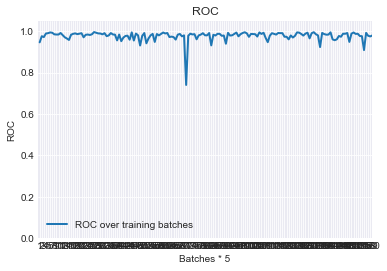

In [53]:
ood_joint_eval("Results/gan_combined_training_results.p")

count    32.000000
mean      0.974316
std       0.023032
min       0.883800
25%       0.964100
50%       0.980200
75%       0.989475
max       0.994400
Name: (ROC, mean), dtype: float64
32


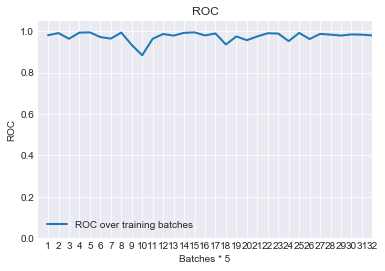

In [54]:
ood_joint_eval("Results/gan_combined_training_results_2.p")

count    32.000000
mean      0.982916
std       0.011839
min       0.941500
25%       0.980075
50%       0.986550
75%       0.990675
max       0.996000
Name: (ROC, mean), dtype: float64
32


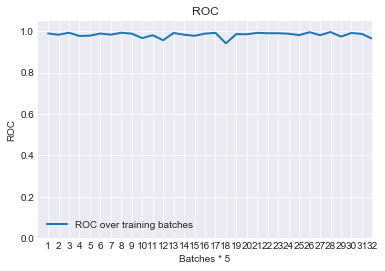

In [55]:
ood_joint_eval("Results/gan_combined_training_results_3.p")

count    32.000000
mean      0.985016
std       0.008496
min       0.962000
25%       0.981900
50%       0.987300
75%       0.989525
max       0.997700
Name: (ROC, mean), dtype: float64
32


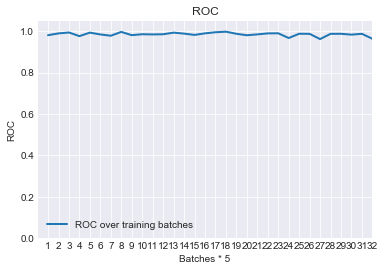

In [56]:
ood_joint_eval("Results/gan_combined_training_results_4.p")

In [46]:
joint_res_path = DRIVE_PATH+ "Results/gan_combined_training_results.p"
joint_res = load_results(joint_res_path)
pd.set_option('display.max_rows', 500)
joint_res = pd.concat(joint_res)
joint_res

ROC           PR IN          PR OUT         MEAN REAL  \
                     mean     std    mean     std    mean     std      mean   
Epoch:0, Batch:6   0.9463  0.0767  0.9709  0.0421  0.8759  0.1282    0.9844   
Epoch:0, Batch:11  0.9758  0.0313  0.9875  0.0160  0.9264  0.0777    0.9845   
Epoch:0, Batch:16  0.9718  0.0320  0.9855  0.0165  0.9163  0.0844    0.9831   
Epoch:0, Batch:21  0.9890  0.0089  0.9944  0.0045  0.9549  0.0293    0.9859   
Epoch:0, Batch:26  0.9905  0.0102  0.9950  0.0053  0.9631  0.0343    0.9852   
Epoch:0, Batch:31  0.9941  0.0032  0.9969  0.0016  0.9732  0.0132    0.9866   
Epoch:0, Batch:36  0.9926  0.0047  0.9962  0.0024  0.9685  0.0171    0.9854   
Epoch:0, Batch:41  0.9850  0.0108  0.9924  0.0055  0.9426  0.0348    0.9848   
Epoch:0, Batch:46  0.9840  0.0245  0.9918  0.0125  0.9478  0.0674    0.9845   
Epoch:0, Batch:51  0.9840  0.0077  0.9918  0.0038  0.9378  0.0254    0.9847   
Epoch:0, Batch:56  0.9914  0.0139  0.9956  0.0070  0.9682  0.0457    0.9835   
Epoch:0, Batch:61  0.9811  0.0106  0.9903  0.0054  0.9299  0.0334    0.9842   
Epoch:0, Batch:66  0.9708  0.0518  0.9849  0.0270  0.9227  0.1078    0.9841   
Epoch:0, Batch:71  0.9649  0.0274  0.9819  0.0142  0.8924  0.0667    0.9841   
Epoch:0, Batch:76  0.9577  0.0556  0.9780  0.0290  0.8954  0.1235    0.9837   
Epoch:0, Batch:81  0.9830  0.0173  0.9913  0.0088  0.9381  0.0485    0.9868   
Epoch:1, Batch:6   0.9874  0.0045  0.9936  0.0022  0.9476  0.0172    0.9850   
Epoch:1, Batch:11  0.9895  0.0108  0.9946  0.0055  0.9590  0.0380    0.9845   
Epoch:1, Batch:16  0.9858  0.0087  0.9926  0.0045  0.9449  0.0299    0.9845   
Epoch:1, Batch:21  0.9879  0.0132  0.9938  0.0068  0.9534  0.0418    0.9843   
Epoch:1, Batch:26  0.9904  0.0040  0.9951  0.0021  0.9578  0.0148    0.9852   
Epoch:1, Batch:31  0.9706  0.0192  0.9850  0.0098  0.9017  0.0489    0.9848   
Epoch:1, Batch:36  0.9827  0.0223  0.9910  0.0118  0.9404  0.0576    0.9869   
Epoch:1, Batch:41  0.9840  0.0083  0.9919  0.0042  0.9376  0.0287    0.9843   
Epoch:1, Batch:46  0.9818  0.0150  0.9907  0.0077  0.9353  0.0499    0.9863   
Epoch:1, Batch:51  0.9853  0.0097  0.9925  0.0050  0.9416  0.0279    0.9833   
Epoch:1, Batch:56  0.9959  0.0031  0.9979  0.0015  0.9797  0.0144    0.9859   
Epoch:1, Batch:61  0.9926  0.0056  0.9962  0.0028  0.9670  0.0221    0.9850   
Epoch:1, Batch:66  0.9894  0.0097  0.9946  0.0049  0.9564  0.0330    0.9857   
Epoch:1, Batch:71  0.9889  0.0071  0.9942  0.0038  0.9546  0.0224    0.9847   
Epoch:1, Batch:76  0.9849  0.0045  0.9922  0.0023  0.9401  0.0146    0.9843   
Epoch:1, Batch:81  0.9906  0.0061  0.9951  0.0032  0.9613  0.0214    0.9863   
Epoch:2, Batch:6   0.9762  0.0190  0.9878  0.0098  0.9186  0.0526    0.9836   
Epoch:2, Batch:11  0.9796  0.0162  0.9894  0.0083  0.9287  0.0452    0.9842   
Epoch:2, Batch:16  0.9910  0.0072  0.9954  0.0036  0.9610  0.0268    0.9840   
Epoch:2, Batch:21  0.9843  0.0094  0.9918  0.0048  0.9426  0.0346    0.9851   
Epoch:2, Batch:26  0.9833  0.0146  0.9913  0.0077  0.9400  0.0446    0.9843   
Epoch:2, Batch:31  0.9557  0.0394  0.9766  0.0214  0.8755  0.0798    0.9847   
Epoch:2, Batch:36  0.9839  0.0057  0.9915  0.0030  0.9393  0.0183    0.9836   
Epoch:2, Batch:41  0.9519  0.0311  0.9749  0.0164  0.8656  0.0785    0.9853   
Epoch:2, Batch:46  0.9692  0.0132  0.9835  0.0074  0.9014  0.0312    0.9849   
Epoch:2, Batch:51  0.9770  0.0316  0.9880  0.0164  0.9311  0.0797    0.9866   
Epoch:2, Batch:56  0.9784  0.0392  0.9886  0.0208  0.9402  0.0917    0.9855   
Epoch:2, Batch:61  0.9590  0.0311  0.9788  0.0159  0.8800  0.0742    0.9854   
Epoch:2, Batch:66  0.9945  0.0007  0.9971  0.0004  0.9775  0.0070    0.9859   
Epoch:2, Batch:71  0.9550  0.0407  0.9754  0.0228  0.8799  0.0871    0.9859   
Epoch:2, Batch:76  0.9885  0.0096  0.9939  0.0050  0.9576  0.0345    0.9847   
Epoch:2, Batch:81  0.9802  0.0192  0.9892  0.0103  0.9366  0.0502    0.9857   
Epoch:3, Batch:6   0.9310  0.0788  0.9629  0.0428  0.8479  0.1425    0.9

# Classification Pipeline

In [5]:
noise_res, noise_df = load_results(DRIVE_PATH + 'Results/Classification_noise_results_final2.p')
grey_res, grey_df = load_results(DRIVE_PATH + 'Results/Classification_grey_results_final2.p')
snow_res, snow_df = load_results(DRIVE_PATH + 'Results/Classification_snow_results_final2.p')
rain_res, rain_df = load_results(DRIVE_PATH + 'Results/Classification_rain_results_final2.p')
fog_res, fog_df = load_results(DRIVE_PATH + 'Results/Classification_fog_results_final2.p')
perspective_res, perspective_df = load_results(DRIVE_PATH + 'Results/Classification_perspective_results_final2.p')
blur_res, blur_df = load_results(DRIVE_PATH + 'Results/Classification_blur_results_final2.p')
rotation_res, rotation_df = load_results(DRIVE_PATH + 'Results/Classification_rotation_results_final2.p')
crop_res, crop_df = load_results(DRIVE_PATH + 'Results/Classification_crop_results_final2.p')
reflection_res, reflection_df = load_results(DRIVE_PATH + 'Results/Classification_reflection_results_final2.p')

In [6]:
# Export dfs for ANOVA in matlab
dfs = [noise_df, grey_df, snow_df, rain_df, fog_df, perspective_df, blur_df, rotation_df, crop_df, reflection_df]

df = pd.concat(dfs, axis=0)
df.to_csv(DRIVE_PATH + 'Results/Classification_raw_results.csv')

In [7]:
df.head()

Measure  Accuracy Classifier Transformation       ROC     Brier
0  Level 1  0.990513   Baseline          Noise  0.986678  0.001246
1  Level 1  0.962054   Baseline          Noise  0.964984  0.003984
2  Level 1  0.992746   Baseline          Noise  0.992909  0.001024
3  Level 1  0.987723   Baseline          Noise  0.972856  0.001830
4  Level 1  0.986607   Baseline          Noise  0.979237  0.001871

In [8]:
base_res, base_df = load_results(DRIVE_PATH + 'Results/Classification_base_results_final_big.p')
classification_res = (noise_res, grey_res, snow_res, rain_res, fog_res, perspective_res, blur_res, rotation_res, crop_res, reflection_res)
base_df.head()

Measure  Accuracy Classifier Transformation       ROC     Brier
0  Level 1  0.988281   Baseline   No transform  0.972762  0.001516
1  Level 1  0.987723   Baseline   No transform  0.981715  0.001506
2  Level 1  0.992188   Baseline   No transform  0.986944  0.001006
3  Level 1  0.990513   Baseline   No transform  0.992179  0.001103
4  Level 1  0.992188   Baseline   No transform  0.987546  0.001105

In [9]:
df["Transform"] = "Yes"
base_df["Transform"] = "No"
combined_df = pd.concat([df, base_df], axis=0)
combined_df

Measure  Accuracy  Classifier Transformation       ROC     Brier  \
0    Level 1  0.990513    Baseline          Noise  0.986678  0.001246   
1    Level 1  0.962054    Baseline          Noise  0.964984  0.003984   
2    Level 1  0.992746    Baseline          Noise  0.992909  0.001024   
3    Level 1  0.987723    Baseline          Noise  0.972856  0.001830   
4    Level 1  0.986607    Baseline          Noise  0.979237  0.001871   
..       ...       ...         ...            ...       ...       ...   
995  Level 5  0.983259  MC Dropout   No transform  0.992660  0.002950   
996  Level 5  0.987723  MC Dropout   No transform  0.992784  0.002331   
997  Level 5  0.984933  MC Dropout   No transform  0.991019  0.002662   
998  Level 5  0.986607  MC Dropout   No transform  0.992129  0.002541   
999  Level 5  0.987723  MC Dropout   No transform  0.989394  0.002350   

    Transform  
0         Yes  
1         Yes  
2         Yes  
3         Yes  
4         Yes  
..        ...  
995        No  
996        No  
997        No  
998        No  
999        No  

[4000 rows x 7 columns]

In [15]:
def get_summary(df, measure):
    print(df.groupby('Classifier').agg({'Accuracy': measure, 'ROC': measure, 'Brier': measure}).round(4).T.to_latex())
    
get_summary(base_df, "std")

\begin{tabular}{lrr}
\toprule
Classifier &  Baseline &  MC Dropout \\
\midrule
Accuracy &    0.0030 &      0.0019 \\
ROC      &    0.0070 &      0.0022 \\
Brier    &    0.0003 &      0.0003 \\
\bottomrule
\end{tabular}



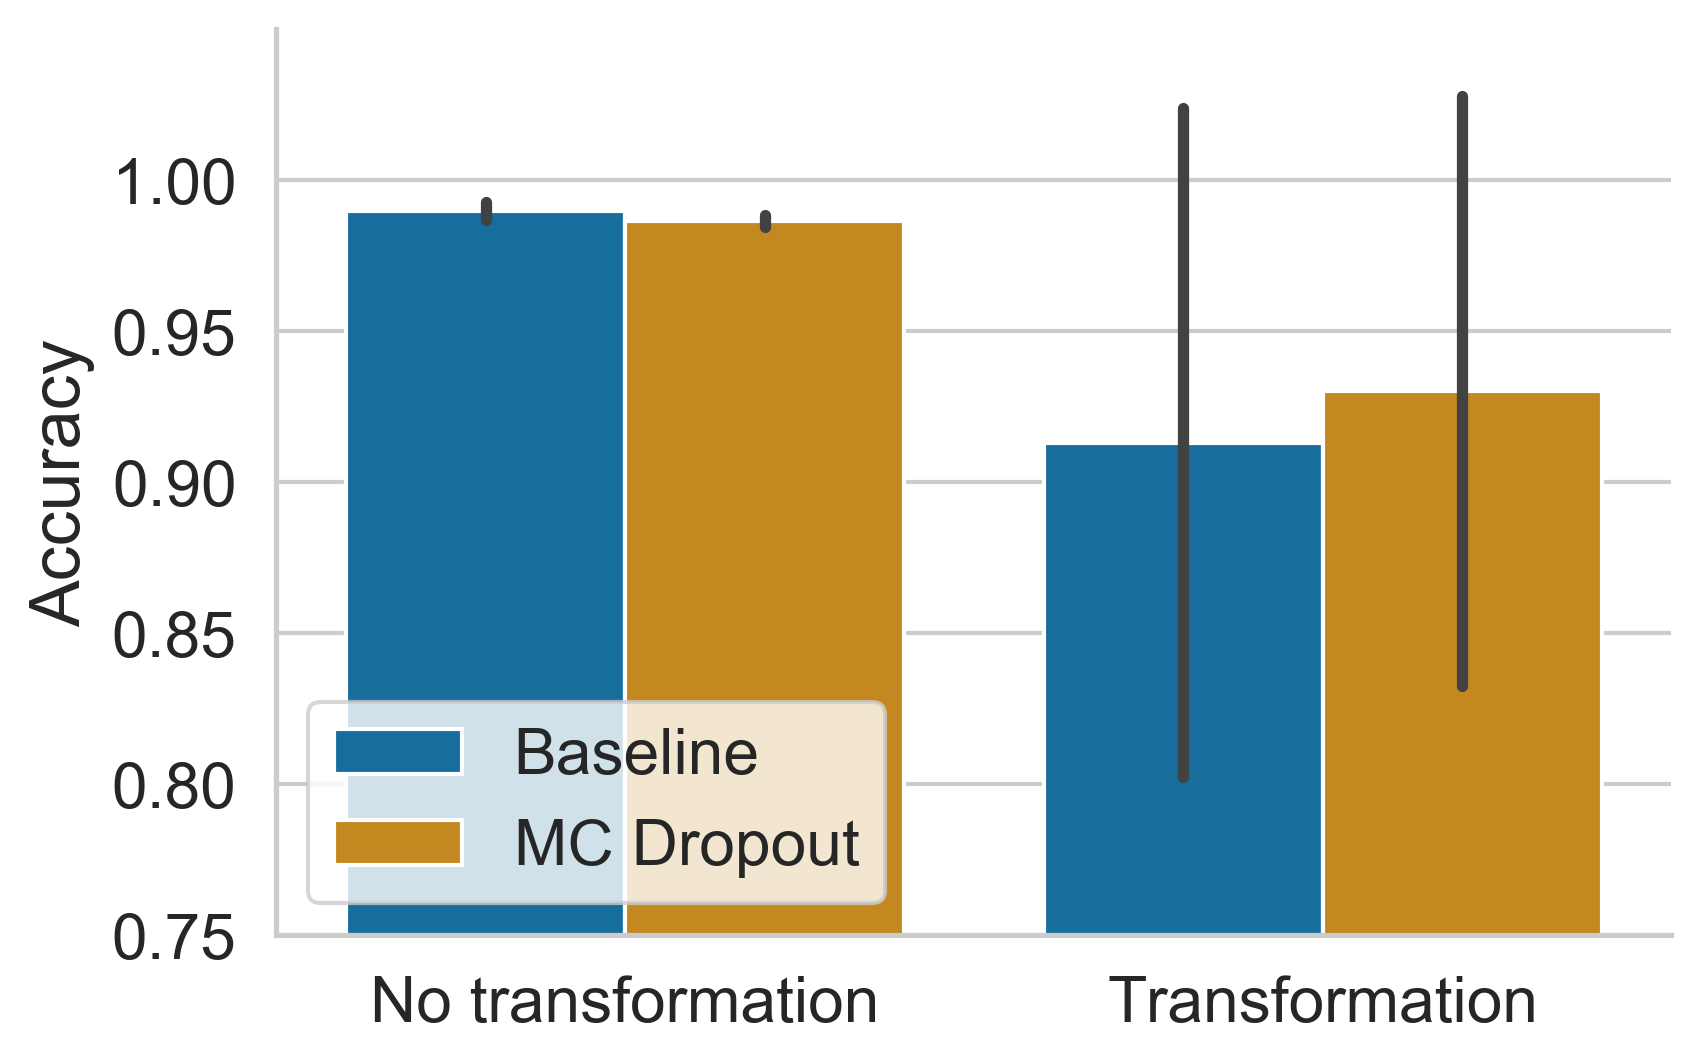

In [22]:
# Compare pipeline to base results
def transform_effect_plot(measure):
    # Effect of transformations
    sns.set(style="whitegrid", font_scale=1.4)
    ax = sns.barplot(x="Transform", y=measure, data=combined_df, hue="Classifier", ci="sd", palette="colorblind", order=["No", "Yes"])
    ax.set_xticklabels(["No transformation", "Transformation"])
    sns.despine()
    plt.legend(loc='lower left')
    ax.set(ylim=(0.75, 1.05), ylabel=measure, xlabel="", yticks=(0.75, 0.8, 0.85, 0.9, 0.95, 1))

transform_effect_plot("Accuracy")

[(0, 0.04), Text(0, 0.5, 'Brier'), Text(0.5, 0, 'Strength')]

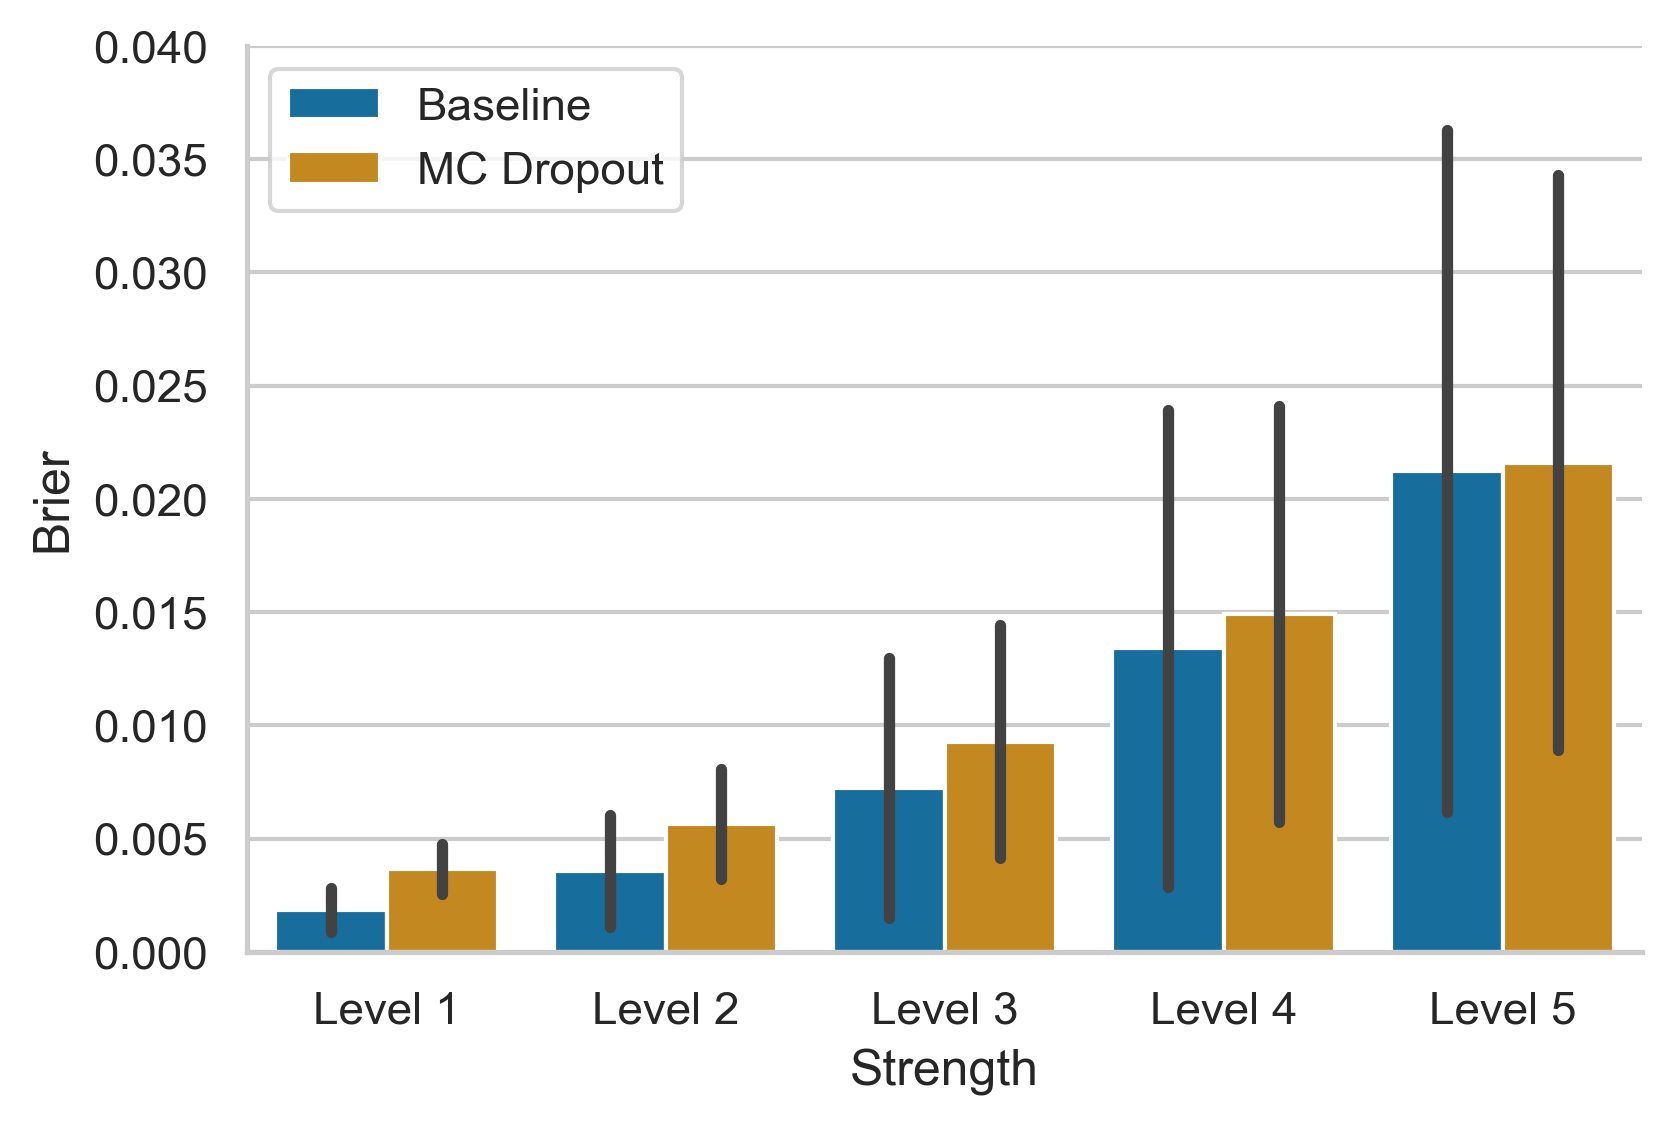

In [16]:
# Compare Classifiers - Levels
sns.set(font_scale=1.1)
sns.set(style="whitegrid")

ax = sns.barplot(x="Measure", y="Brier", data=df, hue="Classifier", ci="sd", palette="colorblind", order=["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"])
ax.set_xticklabels(["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"])
sns.despine()
plt.legend(loc='upper left')
ax.set(ylim=(0, 0.04), ylabel="Brier", xlabel="Strength") #yticks=(0.6, 0.7, 0.8, 0.9, 1)


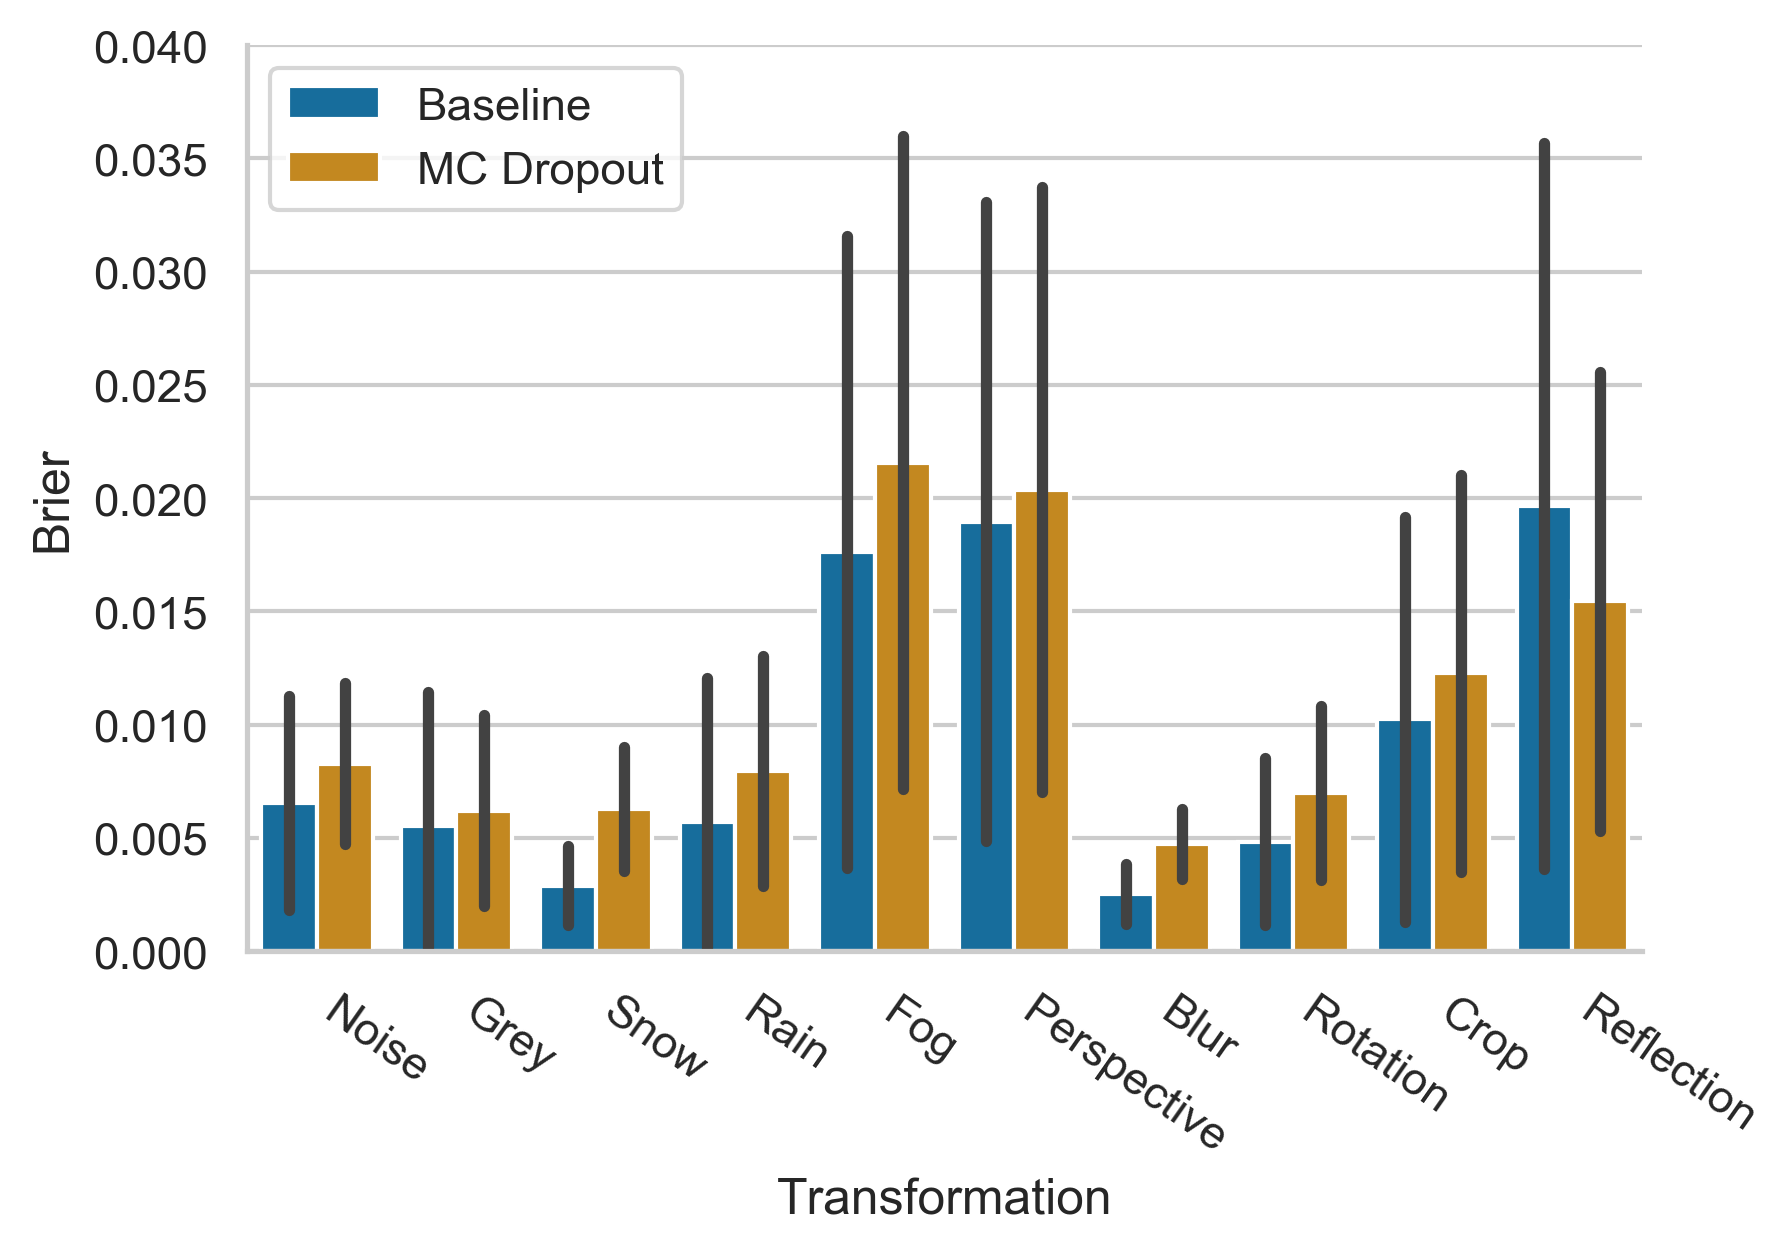

In [20]:
labels = ["Noise", "Grey", "Snow", "Rain", "Fog", "Perspective", "Blur", "Rotation", "Crop", "Reflection"]
ax = sns.barplot(x="Transformation", y="Brier", data=df, ci="sd", order=labels, hue="Classifier", palette="colorblind")
ax.set(ylim=(0, 0.04), ylabel="Brier", xlabel="Transformation")#yticks=(0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1)
ax.set_xticklabels(labels, rotation=-35, ha='left')
sns.despine()
plt.legend(loc='upper left')

ax = sns.barplot(x="Transform", y="Accuracy", hue="Classifier", data=combined_df, ci="sd", palette="colorblind")
plt.legend(loc='lower right')
ax.set_xticklabels(("With transformations", "Without transformations"))
ax.set(ylim=(0.75, 1.05), ylabel="Accuracy", xlabel="", yticks=(0.75, 0.8, 0.85, 0.9, 0.95, 1))

[[<matplotlib.axis.YTick at 0x1a399b02d0>,
 (0.7, 1.05),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Transformation')]

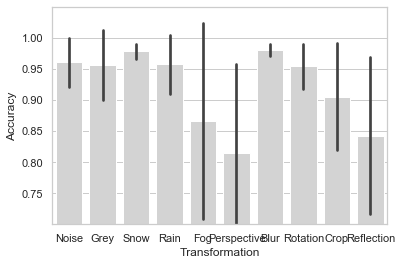

In [90]:
ax = sns.barplot(x="Transformation", y="Accuracy", data=df, ci="sd", color="lightgrey")
ax.set(ylim=(0.7, 1.05), ylabel="Accuracy", xlabel="Transformation", yticks=(0.75, 0.8, 0.85, 0.9, 0.95, 1))

<Figure size 432x288 with 0 Axes>

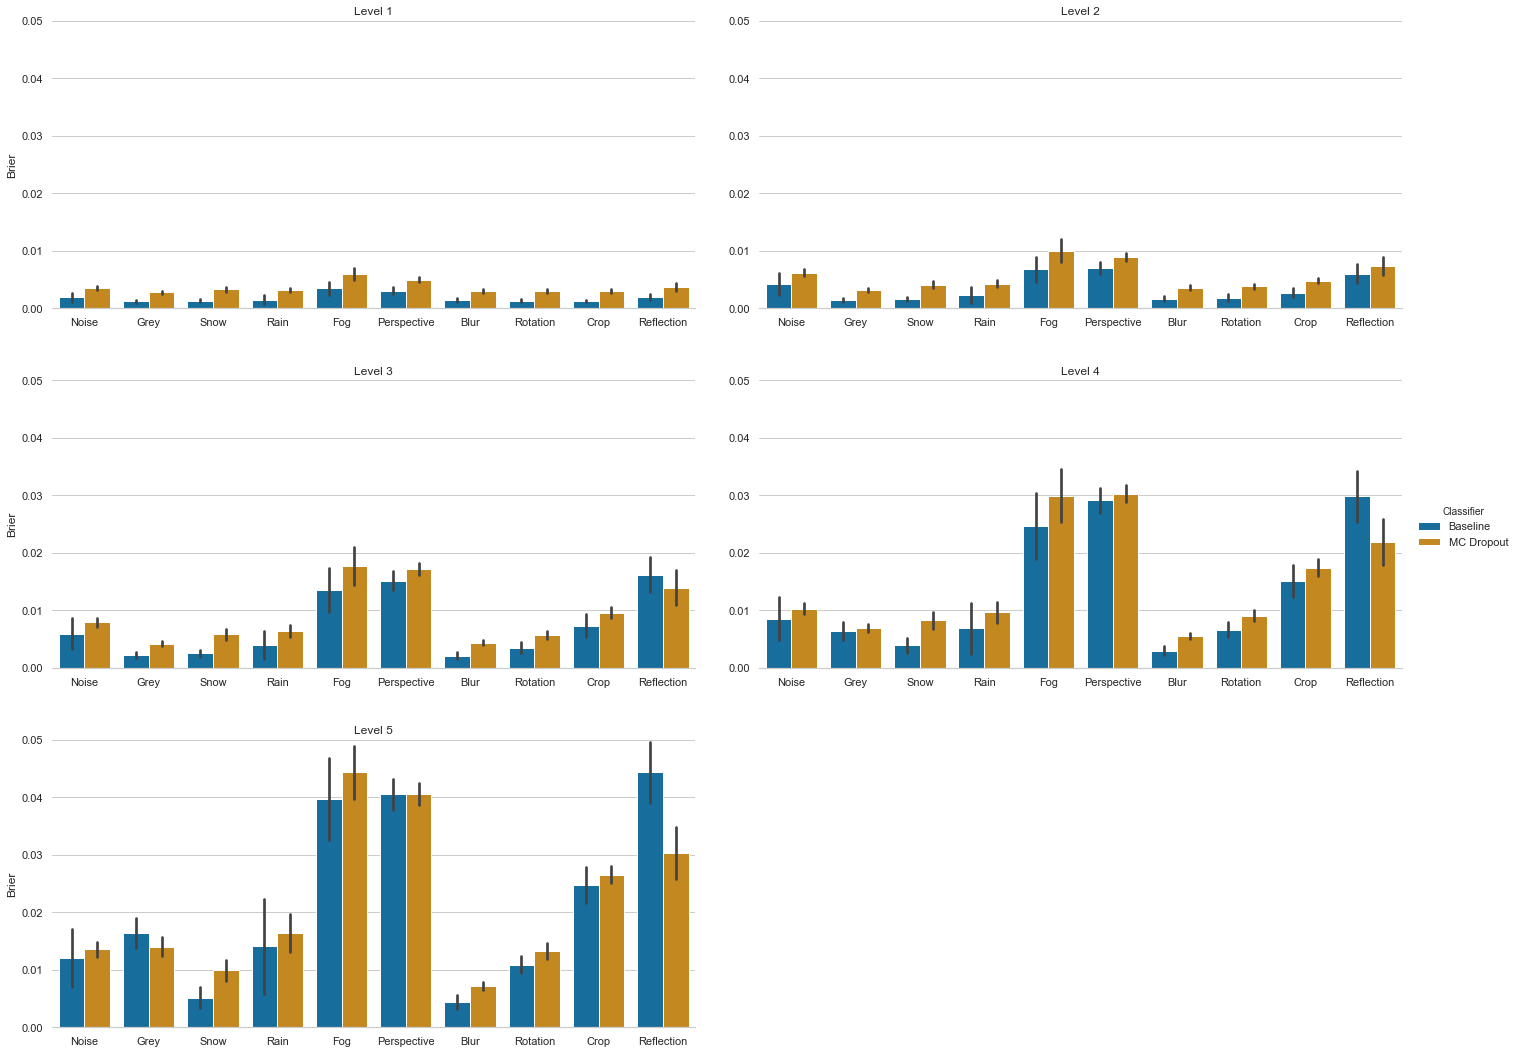

In [14]:
plt.tight_layout()
sns.set(font_scale=2)
sns.set(style="whitegrid")
g = sns.catplot(x="Transformation", y="Brier",
                hue="Classifier", col="Measure", palette = sns.color_palette("colorblind"),
                data=df, kind="bar",
                height=5, aspect=2, col_wrap=2, ci="sd", sharex=False, sharey=False, legend=True);
plt.subplots_adjust(hspace=0.25, wspace=0.1)
(g.set_axis_labels("", "Brier")
  .set_titles("{col_name}")
  .set(ylim=(0, 0.05))
  .despine(left=True))
  #.set(yticks=(0.7, 0.8, 0.9, 1)))  
#plt.legend("lower left")

In [15]:
def gen_plot(res, cols, rows, title):
    values = []
    for row in rows:
        values.append(res.loc[row, tuple(cols)])
    plot_accuracy(values, rows, title)
    
def plot_accuracy_activation(res, classifier, title):
    gen_plot(res, [classifier, "Mean"], ["Accuracy", "Activation correct", "Activation incorrect"], title)
    
def calc_correlation(res):
    cols = list(res.columns.levels[0])
    cors = [(col, pearsonr(list(res.loc["Accuracy", (col, "Mean")]), list(res.loc["Activation", (col, "Mean")]))) for col in cols]
    print("Pearson correlation between accuray and average activation")
    [print(str(cor[0]) + ": " + str(cor[1][0])) for cor in cors]

#### Individual test results

In [10]:
base_res
no_transform = base_res[base_res.index.get_level_values(1).isin(['Level 1'])]
no_transform.index = no_transform.index.droplevel(1)
mean1, sd1= no_transform.loc[("Accuracy", ("Baseline", "Mean"))], no_transform.loc[("Accuracy", ("Baseline", "Std"))]
mean2, sd2= no_transform.loc[("Accuracy", ("MC Dropout", "Mean"))], no_transform.loc[("Accuracy", ("MC Dropout", "Std"))]
print(ttest_ind_from_stats(mean1=mean1, std1=sd1, nobs1=20, mean2=mean2, std2=sd2, nobs2=20))
mean1, sd1= no_transform.loc[("ROC", ("Baseline", "Mean"))], no_transform.loc[("ROC", ("Baseline", "Std"))]
mean2, sd2= no_transform.loc[("ROC", ("MC Dropout", "Mean"))], no_transform.loc[("ROC", ("MC Dropout", "Std"))]
print(ttest_ind_from_stats(mean1=mean1, std1=sd1, nobs1=20, mean2=mean2, std2=sd2, nobs2=20))
mean1, sd1= no_transform.loc[("Brier", ("Baseline", "Mean"))], no_transform.loc[("Brier", ("Baseline", "Std"))]
mean2, sd2= no_transform.loc[("Brier", ("MC Dropout", "Mean"))], no_transform.loc[("Brier", ("MC Dropout", "Std"))]
print(ttest_ind_from_stats(mean1=mean1, std1=sd1, nobs1=20, mean2=mean2, std2=sd2, nobs2=20))
no_transform

Ttest_indResult(statistic=2.4444444444444215, pvalue=0.019257773023153048)
Ttest_indResult(statistic=-2.4054931821815, pvalue=0.021125029686354133)
Ttest_indResult(statistic=-11.627553482998907, pvalue=4.4000019231691696e-14)


Classifier           Baseline         MC Dropout        
Measure                  Mean     Std       Mean     Std
Accuracy               0.9891  0.0036     0.9869  0.0018
Activation             0.9826  0.0031     0.9040  0.0114
Activation correct     0.9869  0.0019     0.9112  0.0109
Activation incorrect   0.5915  0.0566     0.3596  0.0239
ROC                    0.9885  0.0058     0.9918  0.0020
Brier                  0.0012  0.0003     0.0025  0.0004

In [28]:
print_nt = no_transform.loc[["Accuracy", "ROC", "Brier"], [("Baseline", "Std"), ("MC Dropout", "Std")]]
print_nt.columns = ["Baseline", "MC Dropout"]
print(print_nt.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Baseline &  MC Dropout \\
\midrule
Accuracy &    0.0036 &      0.0018 \\
ROC      &    0.0058 &      0.0020 \\
Brier    &    0.0003 &      0.0004 \\
\bottomrule
\end{tabular}



In [23]:
#utils.plot_accuracy_comparison(noise_res)
#utils.plot_accuracy_comparison(noise_res, ["Activation correct", "Activation incorrect"])
#noise_res

In [14]:
#utils.plot_accuracy_comparison(grey_res)
#utils.plot_accuracy_comparison(grey_res, ["Activation correct", "Activation incorrect"])
#grey_res

In [15]:
#utils.plot_accuracy_comparison(snow_res)
#utils.plot_accuracy_comparison(snow_res, ["Activation correct", "Activation incorrect"])
#snow_res

In [16]:
#utils.plot_accuracy_comparison(rain_res)
#utils.plot_accuracy_comparison(rain_res, ["Activation correct", "Activation incorrect"])
#rain_res

In [17]:
#utils.plot_accuracy_comparison(fog_res)
#utils.plot_accuracy_comparison(fog_res, ["Activation correct", "Activation incorrect"])
#fog_res

In [18]:
#utils.plot_accuracy_comparison(perspective_res)
#utils.plot_accuracy_comparison(perspective_res, ["Activation correct", "Activation incorrect"])
#perspective_res

In [19]:
#utils.plot_accuracy_comparison(blur_res)
#utils.plot_accuracy_comparison(blur_res, ["Activation correct", "Activation incorrect"])
#blur_res

In [20]:
#utils.plot_accuracy_comparison(rotation_res)
#utils.plot_accuracy_comparison(rotation_res, ["Activation correct", "Activation incorrect"])
#rotation_res

In [21]:
#utils.plot_accuracy_comparison(reflection_res)
#utils.plot_accuracy_comparison(reflection_res, ["Activation correct", "Activation incorrect"])
#reflection_res

In [22]:
#utils.plot_accuracy_comparison(crop_res)
#utils.plot_accuracy_comparison(crop_res, ["Activation correct", "Activation incorrect"])
#crop_res

#### Aggregation of individual tests

In [16]:
def transform_df(dfs, col, col2, names):
    rows = []
    for i, df in enumerate(dfs):
        data = df.loc[:,(col, col2)].to_frame(names[i])
        data = data.T
        rows.append(data)
    df = pd.concat(rows)
    return df

#transform_df(list(reflection_res), "Baseline", "Mean", "Reflection")
names = ["Noise", "Grey", "Snow", "Rain", "Fog", "Perspective", "Blur", "Rotation", "Crop", "Reflection"]

In [17]:
baseline_classification_means = transform_df(classification_res, "Baseline", "Mean", names)
baseline_classification_means.drop(["Activation", "Activation correct", "Activation incorrect"], axis=1, level=0)

Accuracy                                     ROC                  \
             Level 1 Level 2 Level 3 Level 4 Level 5 Level 1 Level 2 Level 3   
Noise         0.9843  0.9667  0.9509  0.9268  0.8893  0.9796  0.9647  0.9555   
Grey          0.9896  0.9888  0.9848  0.9545  0.8228  0.9873  0.9819  0.9695   
Snow          0.9895  0.9875  0.9817  0.9696  0.9579  0.9859  0.9814  0.9703   
Rain          0.9866  0.9796  0.9641  0.9363  0.8684  0.9845  0.9761  0.9595   
Fog           0.9800  0.9592  0.8950  0.7613  0.5652  0.9769  0.9603  0.9330   
Perspective   0.9737  0.9351  0.8540  0.7212  0.6110  0.9550  0.9260  0.8871   
Blur          0.9877  0.9863  0.9833  0.9770  0.9658  0.9822  0.9769  0.9696   
Rotation      0.9882  0.9842  0.9693  0.9362  0.8924  0.9849  0.9784  0.9636   
Crop          0.9883  0.9772  0.9328  0.8594  0.7689  0.9857  0.9607  0.9175   
Reflection    0.9826  0.9444  0.8493  0.7337  0.6170  0.9802  0.9431  0.8894   

                              Brier                                  
            Level 4 Level 5 Level 1 Level 2 Level 3 Level 4 Level 5  
Noise        0.9418  0.9240  0.0019  0.0042  0.0060  0.0085  0.0121  
Grey         0.9367  0.9489  0.0012  0.0014  0.0022  0.0063  0.0164  
Snow         0.9595  0.9499  0.0013  0.0016  0.0025  0.0039  0.0051  
Rain         0.9372  0.8941  0.0015  0.0023  0.0039  0.0069  0.0141  
Fog          0.8900  0.8506  0.0035  0.0068  0.0135  0.0246  0.0397  
Perspective  0.8183  0.7751  0.0031  0.0070  0.0151  0.0291  0.0405  
Blur         0.9606  0.9479  0.0014  0.0017  0.0021  0.0030  0.0044  
Rotation     0.9419  0.9213  0.0013  0.0019  0.0035  0.0066  0.0109  
Crop         0.8549  0.7995  0.0013  0.0027  0.0073  0.0151  0.0247  
Reflection   0.8242  0.7660  0.0019  0.0060  0.0162  0.0298  0.0443

In [18]:
mc_classification_means = transform_df(classification_res, "MC Dropout", "Mean", names)
mc_classification_means.drop(["Activation", "Activation correct", "Activation incorrect"], axis=1, level=0)

Accuracy                                     ROC                  \
             Level 1 Level 2 Level 3 Level 4 Level 5 Level 1 Level 2 Level 3   
Noise         0.9850  0.9819  0.9790  0.9754  0.9676  0.9919  0.9896  0.9878   
Grey          0.9868  0.9863  0.9854  0.9799  0.8815  0.9919  0.9907  0.9881   
Snow          0.9856  0.9844  0.9803  0.9755  0.9717  0.9910  0.9901  0.9863   
Rain          0.9855  0.9822  0.9769  0.9643  0.9292  0.9898  0.9868  0.9794   
Fog           0.9837  0.9790  0.9645  0.9007  0.6746  0.9900  0.9854  0.9628   
Perspective   0.9738  0.9406  0.8564  0.7071  0.5804  0.9690  0.9422  0.8971   
Blur          0.9859  0.9842  0.9815  0.9773  0.9720  0.9896  0.9867  0.9821   
Rotation      0.9847  0.9816  0.9734  0.9400  0.8927  0.9908  0.9878  0.9731   
Crop          0.9842  0.9779  0.9458  0.8653  0.7553  0.9923  0.9806  0.9383   
Reflection    0.9814  0.9518  0.8845  0.7929  0.6909  0.9871  0.9563  0.9074   

                              Brier                                  
            Level 4 Level 5 Level 1 Level 2 Level 3 Level 4 Level 5  
Noise        0.9840  0.9747  0.0035  0.0062  0.0079  0.0103  0.0135  
Grey         0.9748  0.9651  0.0028  0.0032  0.0042  0.0069  0.0140  
Snow         0.9797  0.9720  0.0033  0.0041  0.0059  0.0082  0.0099  
Rain         0.9670  0.9348  0.0031  0.0043  0.0064  0.0096  0.0164  
Fog          0.8992  0.8080  0.0060  0.0100  0.0177  0.0299  0.0443  
Perspective  0.8399  0.8038  0.0050  0.0089  0.0172  0.0302  0.0406  
Blur         0.9731  0.9582  0.0031  0.0036  0.0044  0.0055  0.0072  
Rotation     0.9535  0.9322  0.0030  0.0039  0.0057  0.0091  0.0132  
Crop         0.8830  0.8448  0.0030  0.0048  0.0095  0.0174  0.0265  
Reflection   0.8528  0.8030  0.0037  0.0074  0.0139  0.0218  0.0303

In [35]:
# Accuracy table
def to_latex(measure):
    b_acc = baseline_classification_means[measure]
    mc_acc = mc_classification_means[measure]
    acc = pd.concat([b_acc, mc_acc], axis=1, keys=["Baseline", 'MC Dropout'])
    print(acc.to_latex())

to_latex("Brier")

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{5}{l}{Baseline} & \multicolumn{5}{l}{MC Dropout} \\
{} &  Level 1 & Level 2 & Level 3 & Level 4 & Level 5 &    Level 1 & Level 2 & Level 3 & Level 4 & Level 5 \\
\midrule
Noise       &   0.0019 &  0.0042 &  0.0060 &  0.0085 &  0.0121 &     0.0035 &  0.0062 &  0.0079 &  0.0103 &  0.0135 \\
Grey        &   0.0012 &  0.0014 &  0.0022 &  0.0063 &  0.0164 &     0.0028 &  0.0032 &  0.0042 &  0.0069 &  0.0140 \\
Snow        &   0.0013 &  0.0016 &  0.0025 &  0.0039 &  0.0051 &     0.0033 &  0.0041 &  0.0059 &  0.0082 &  0.0099 \\
Rain        &   0.0015 &  0.0023 &  0.0039 &  0.0069 &  0.0141 &     0.0031 &  0.0043 &  0.0064 &  0.0096 &  0.0164 \\
Fog         &   0.0035 &  0.0068 &  0.0135 &  0.0246 &  0.0397 &     0.0060 &  0.0100 &  0.0177 &  0.0299 &  0.0443 \\
Perspective &   0.0031 &  0.0070 &  0.0151 &  0.0291 &  0.0405 &     0.0050 &  0.0089 &  0.0172 &  0.0302 &  0.0406 \\
Blur        &   0.0014 &  0.0017 &  0.0021 &  0.0030 &  0.0

In [39]:
baseline_classification_sd = transform_df(classification_res, "Baseline", "Std", names)
baseline_classification_sd.drop(["Activation", "Activation correct", "Activation incorrect"], axis=1, level=0)

mc_classification_sd = transform_df(classification_res, "MC Dropout", "Std", names)
mc_classification_sd.drop(["Activation", "Activation correct", "Activation incorrect"], axis=1, level=0)

def to_latex_std(measure):
    b_acc = baseline_classification_sd[measure]
    mc_acc = mc_classification_sd[measure]
    acc = pd.concat([b_acc, mc_acc], axis=1, keys=["Baseline", 'MC Dropout'])
    print(acc.to_latex())

to_latex_std("Accuracy")

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{5}{l}{Baseline} & \multicolumn{5}{l}{MC Dropout} \\
{} &  Level 1 & Level 2 & Level 3 & Level 4 & Level 5 &    Level 1 & Level 2 & Level 3 & Level 4 & Level 5 \\
\midrule
Noise       &   0.0081 &  0.0201 &  0.0309 &  0.0438 &  0.0616 &     0.0021 &  0.0028 &  0.0043 &  0.0061 &  0.0088 \\
Grey        &   0.0035 &  0.0040 &  0.0051 &  0.0170 &  0.0306 &     0.0017 &  0.0016 &  0.0015 &  0.0028 &  0.0267 \\
Snow        &   0.0023 &  0.0030 &  0.0061 &  0.0126 &  0.0188 &     0.0023 &  0.0022 &  0.0028 &  0.0051 &  0.0082 \\
Rain        &   0.0082 &  0.0134 &  0.0251 &  0.0456 &  0.0788 &     0.0027 &  0.0040 &  0.0051 &  0.0104 &  0.0319 \\
Fog         &   0.0090 &  0.0209 &  0.0541 &  0.0916 &  0.1284 &     0.0025 &  0.0044 &  0.0119 &  0.0638 &  0.1483 \\
Perspective &   0.0056 &  0.0096 &  0.0159 &  0.0226 &  0.0302 &     0.0036 &  0.0077 &  0.0157 &  0.0159 &  0.0238 \\
Blur        &   0.0031 &  0.0039 &  0.0058 &  0.0093 &  0.0

In [46]:
# Statistical analysis accuracy - COMPARING CLASSIFIERS
baseline_classification_sd = transform_df(classification_res, "Baseline", "Std", names)
baseline_classification_sd.drop(["Activation", "Activation correct", "Activation incorrect"], axis=1, level=0)

mc_classification_sd = transform_df(classification_res, "MC Dropout", "Std", names)
mc_classification_sd.drop(["Activation", "Activation correct", "Activation incorrect"], axis=1, level=0)


for measure in ("Accuracy", "ROC", "Brier"):
    print("\n\nMEASURE:", measure)
    for transformation in list(mc_classification_sd.index):
        print("\nTransformation:", transformation)
        for level in ("Level 1", "Level 2", "Level 3", "Level 4", "Level 5"):
            print("LEVEL:", level)
            mean1 = baseline_classification_means.loc[transformation, (measure, level)]
            sd1 = baseline_classification_sd.loc[transformation, (measure, level)]
            mean2 = mc_classification_means.loc[transformation, (measure, level)]
            sd2 = mc_classification_sd.loc[transformation, (measure, level)]
            print("Comparing:", mean1, sd1, mean2, sd2)
            print(ttest_ind_from_stats(mean1=mean1, std1=sd1, nobs1=20, mean2=mean2, std2=sd2, nobs2=20))



MEASURE: Accuracy

Transformation: Noise
LEVEL: Level 1
Comparing: 0.9843 0.0081 0.985 0.0021
Ttest_indResult(statistic=-0.37411229788035655, pvalue=0.7104002366919787)
LEVEL: Level 2
Comparing: 0.9667 0.0201 0.9819 0.0028
Ttest_indResult(statistic=-3.349569941537265, pvalue=0.0018375458053326045)
LEVEL: Level 3
Comparing: 0.9509 0.0309 0.979 0.0043
Ttest_indResult(statistic=-4.028078782586295, pvalue=0.00025979353144281995)
LEVEL: Level 4
Comparing: 0.9268 0.0438 0.9754 0.0061
Ttest_indResult(statistic=-4.914798317580576, pvalue=1.7318650286804252e-05)
LEVEL: Level 5
Comparing: 0.8893 0.0616 0.9676 0.0088
Ttest_indResult(statistic=-5.6274168361632775, pvalue=1.8469848036798681e-06)

Transformation: Grey
LEVEL: Level 1
Comparing: 0.9896 0.0035 0.9868 0.0017
Ttest_indResult(statistic=3.218178222226574, pvalue=0.002639339226861232)
LEVEL: Level 2
Comparing: 0.9888 0.004 0.9863 0.0016
Ttest_indResult(statistic=2.5951712454294342, pvalue=0.013362631737598484)
LEVEL: Level 3
Comparing: 0.

Ttest_indResult(statistic=-3.8161246674946994, pvalue=0.00048530274616104057)
LEVEL: Level 4
Comparing: 0.89 0.0555 0.8992 0.0509
Ttest_indResult(statistic=-0.546349693905337, pvalue=0.5880193507030993)
LEVEL: Level 5
Comparing: 0.8506 0.0802 0.808 0.0663
Ttest_indResult(statistic=1.8308631686689911, pvalue=0.07497112495369249)

Transformation: Perspective
LEVEL: Level 1
Comparing: 0.955 0.0142 0.969 0.0073
Ttest_indResult(statistic=-3.9213224929545456, pvalue=0.00035638251165829064)
LEVEL: Level 2
Comparing: 0.926 0.0127 0.9422 0.0087
Ttest_indResult(statistic=-4.706241019330395, pvalue=3.308937915745152e-05)
LEVEL: Level 3
Comparing: 0.8871 0.018 0.8971 0.0117
Ttest_indResult(statistic=-2.0831299126099747, pvalue=0.04401929475458725)
LEVEL: Level 4
Comparing: 0.8183 0.0189 0.8399 0.0187
Ttest_indResult(statistic=-3.633203786641953, pvalue=0.0008243602934280514)
LEVEL: Level 5
Comparing: 0.7751 0.0184 0.8038 0.0191
Ttest_indResult(statistic=-4.83954992145808, pvalue=2.188791483044484e

In [21]:
dfs = [baseline_classification_means, mc_classification_means]

def subplots_by_measure(measure, maxval=1):
    plt.clf()
    level = ["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"]
    filename = DRIVE_PATH+"Results/classification"+measure+"final.png"
    analysis.make_radar_subplots((measure, level), dfs, ["Baseline", "MC Dropout"], title=measure, filename=filename, maxval=maxval)

<Figure size 432x288 with 0 Axes>

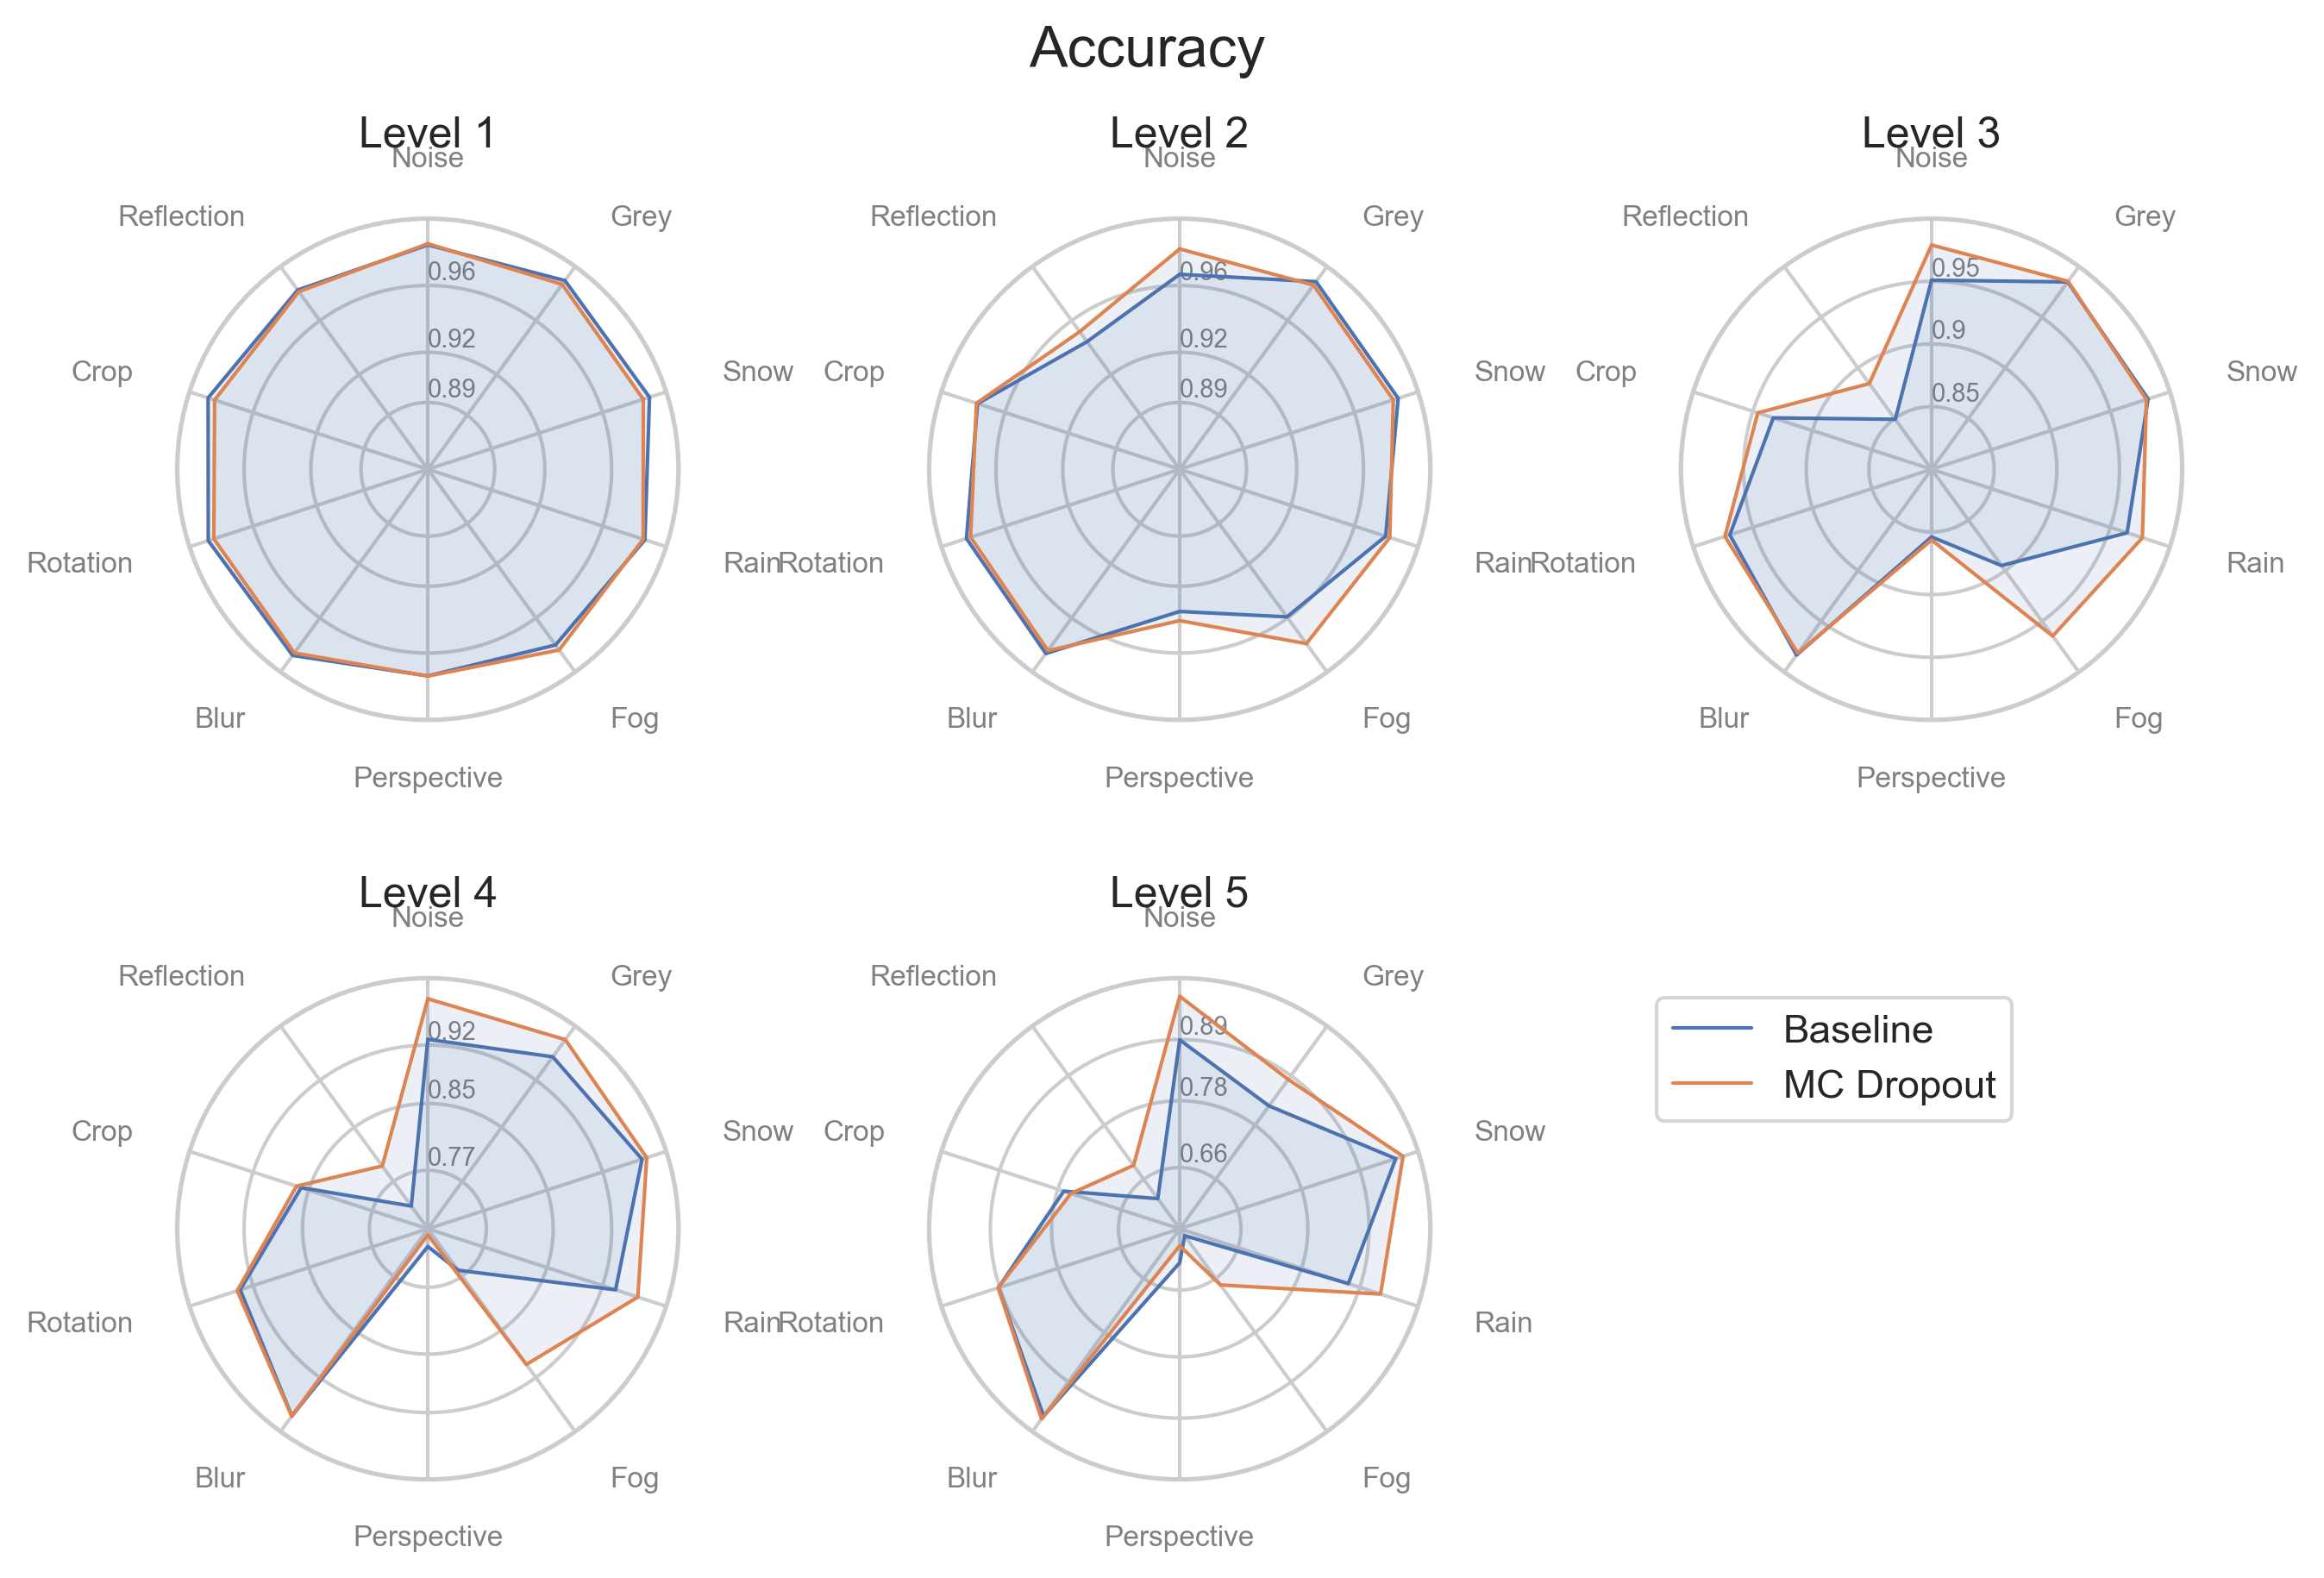

In [22]:
subplots_by_measure("Accuracy")

<Figure size 432x288 with 0 Axes>

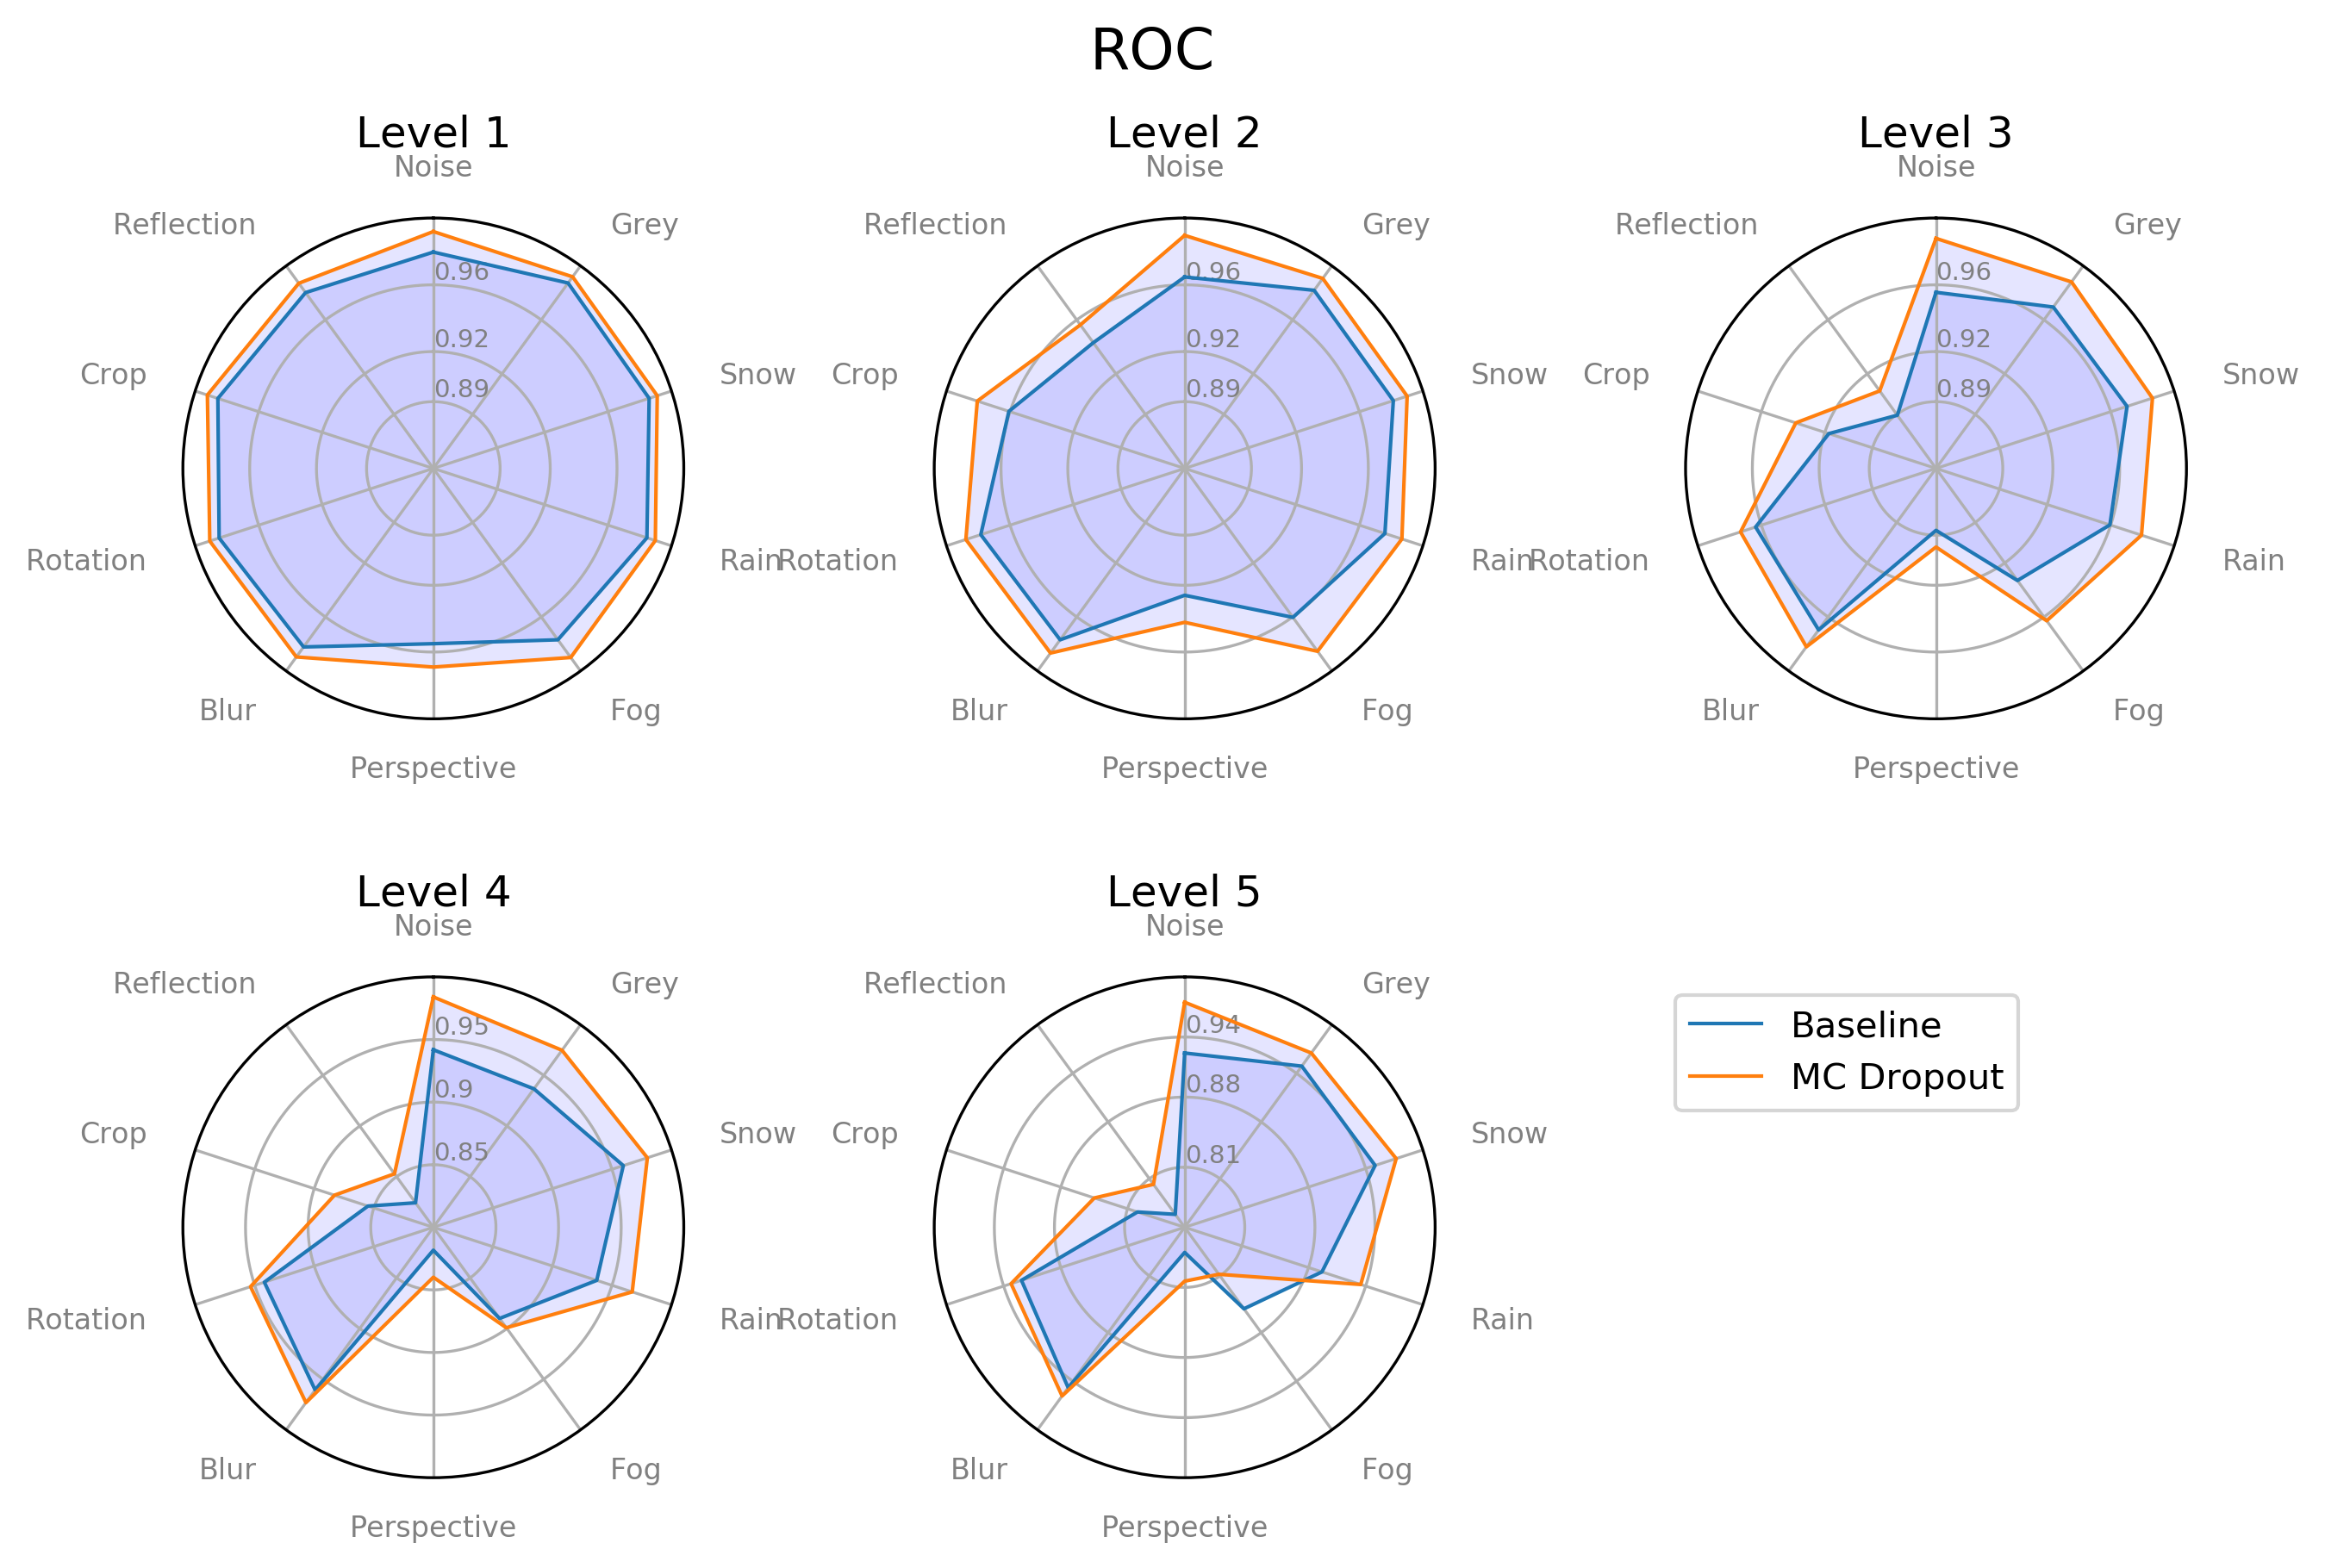

In [21]:
subplots_by_measure("ROC")

<Figure size 432x288 with 0 Axes>

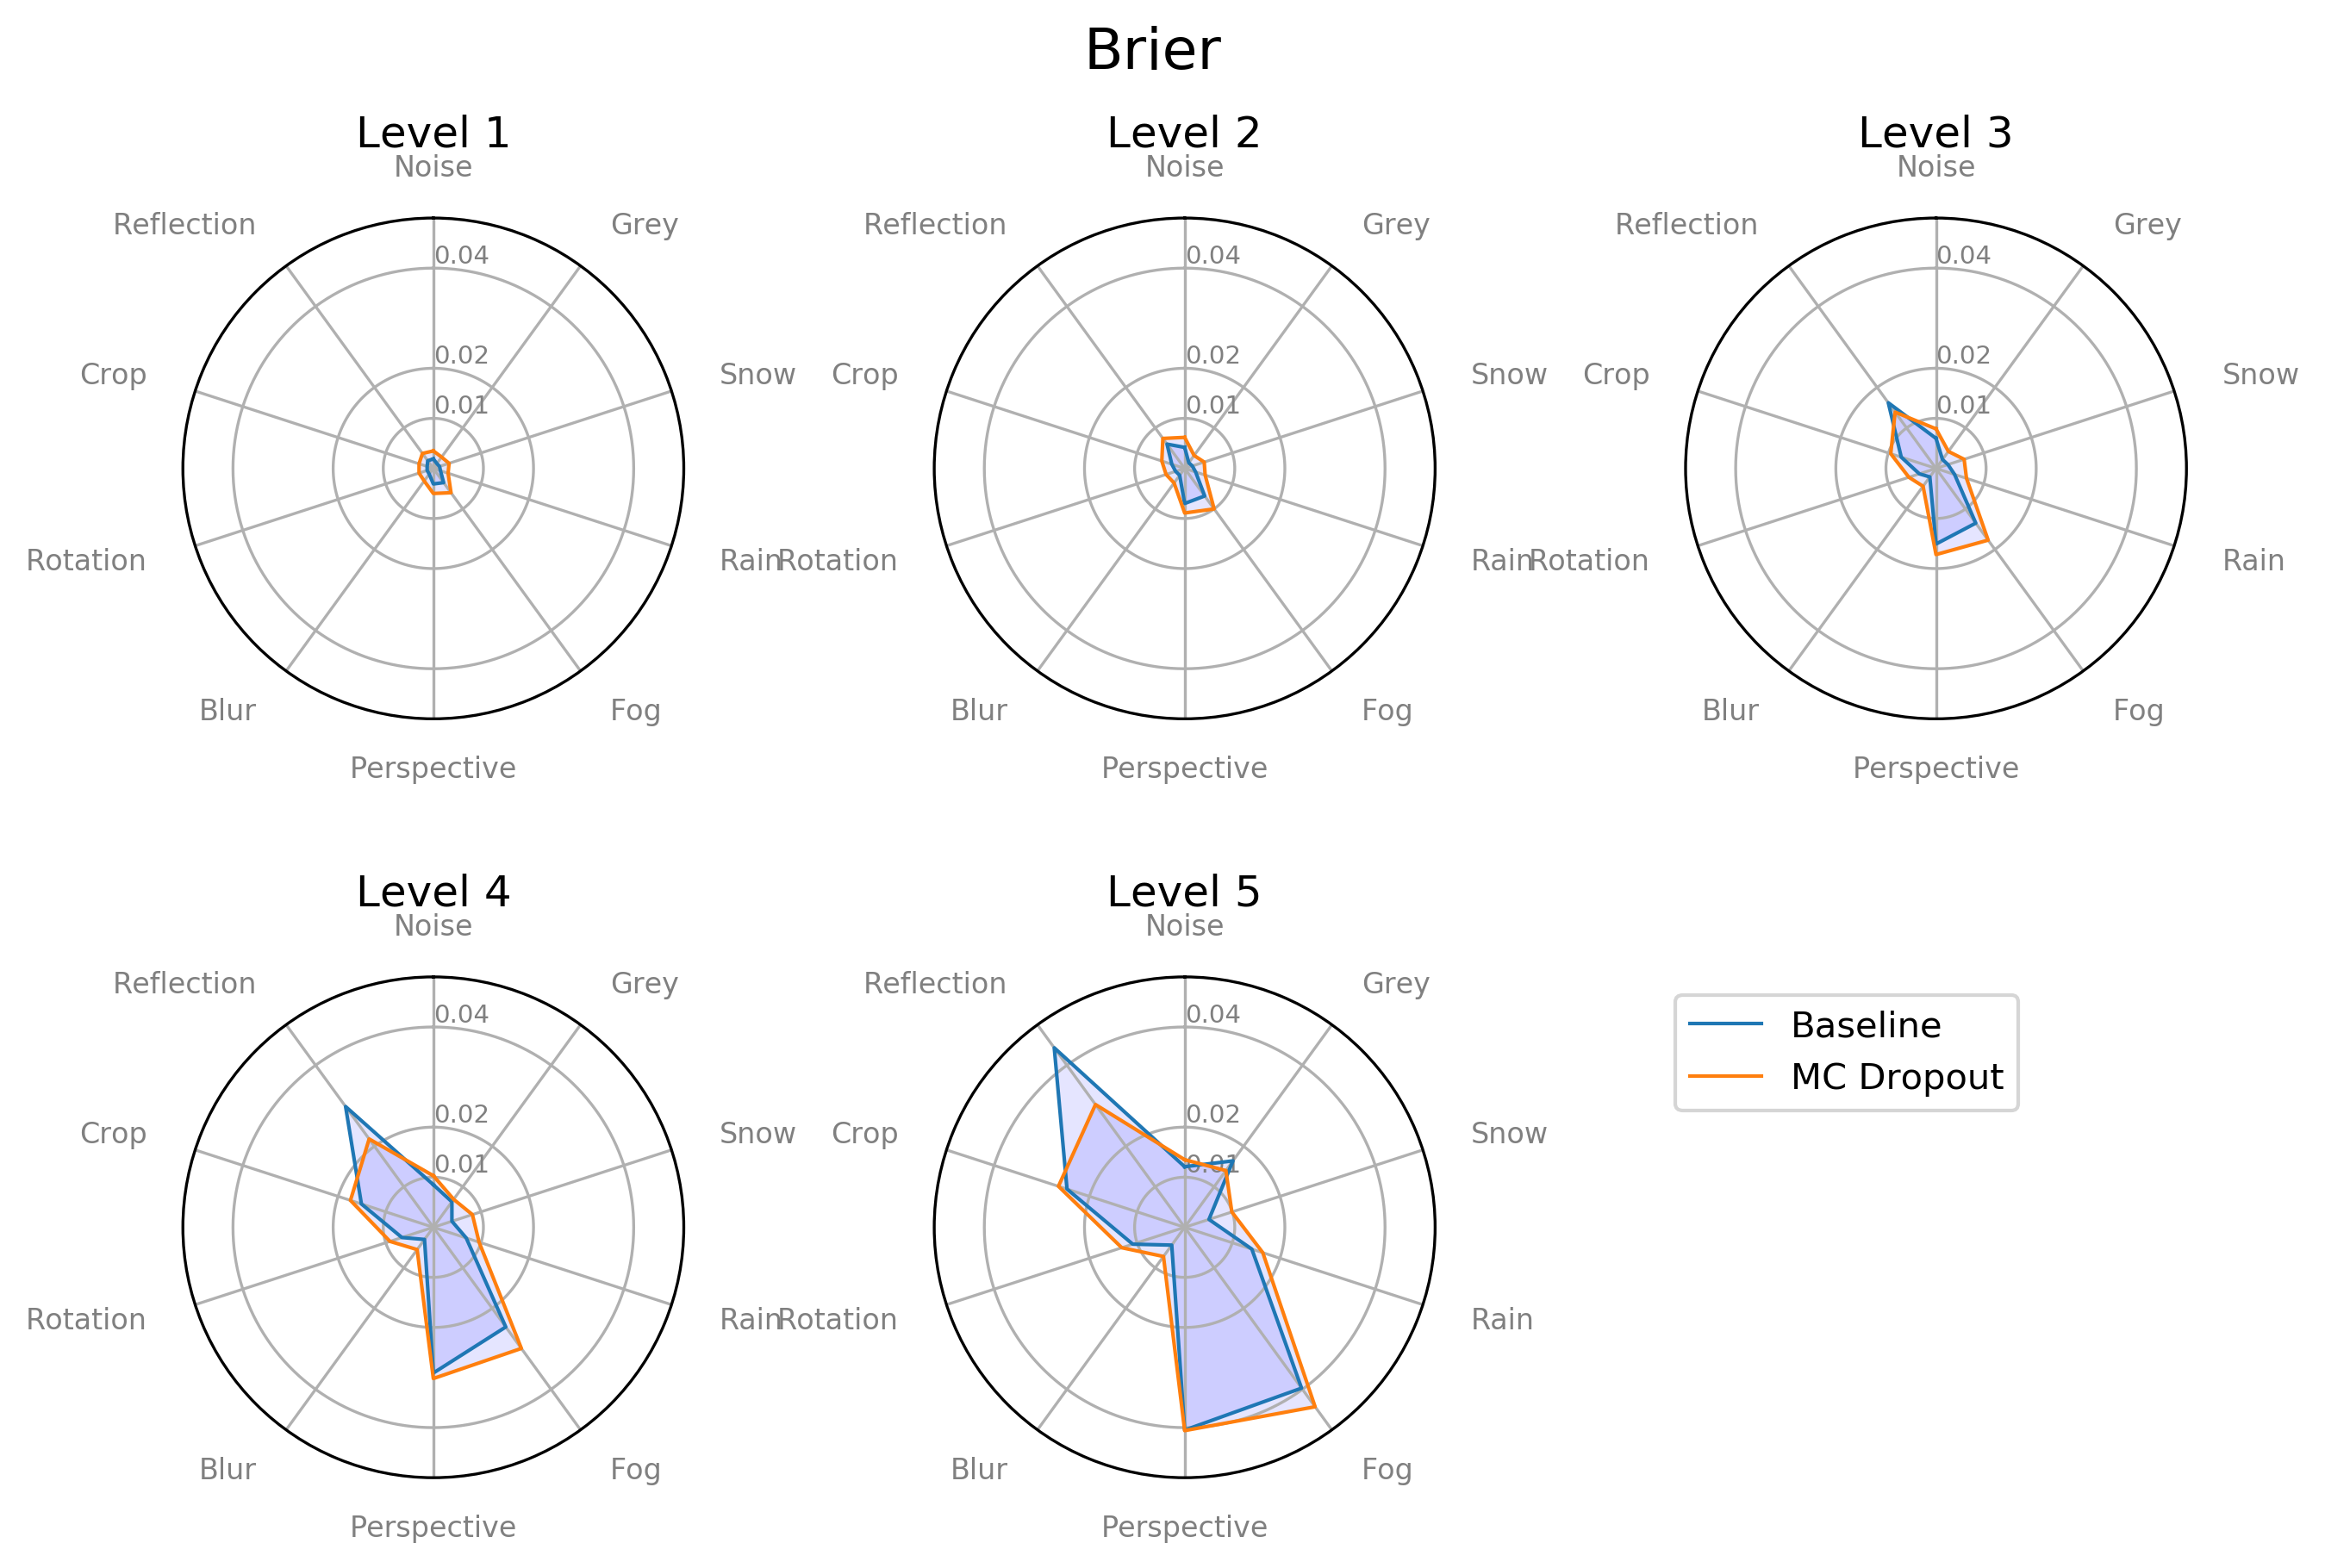

In [22]:
subplots_by_measure("Brier", maxval=0.05)

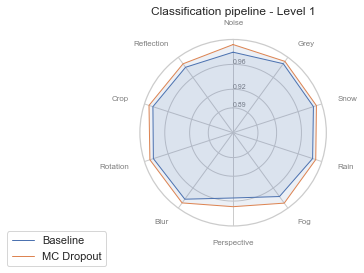

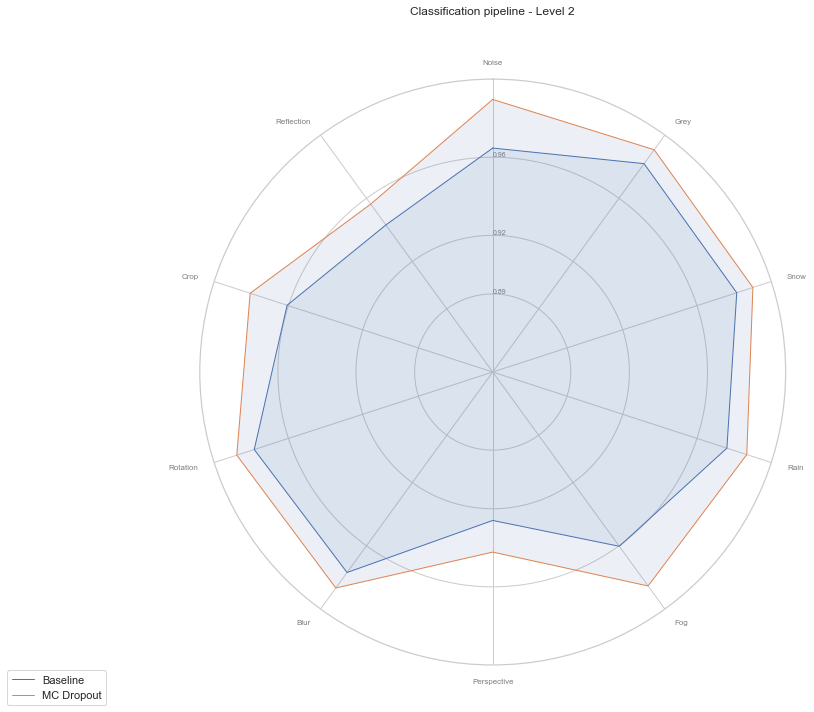

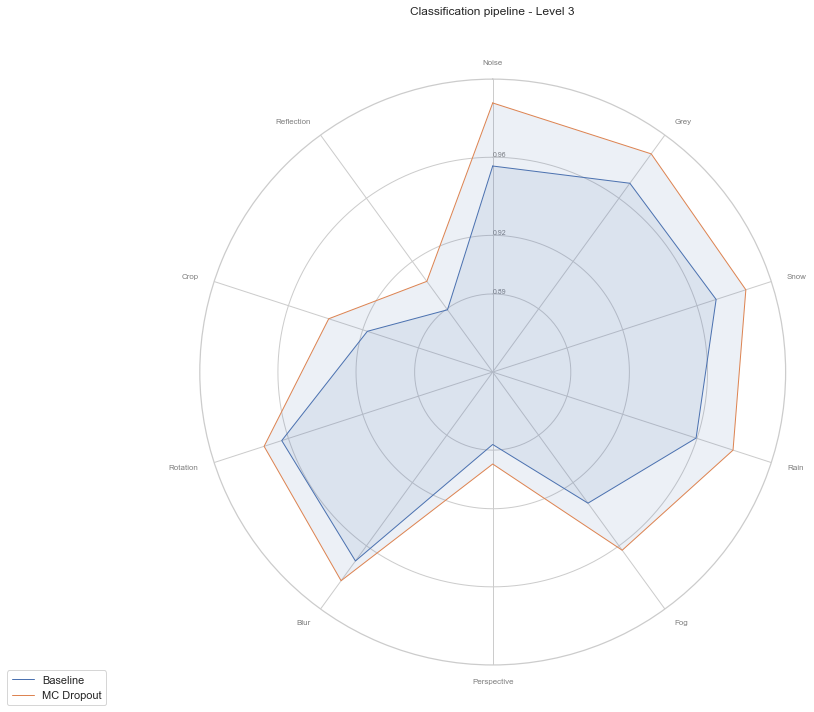

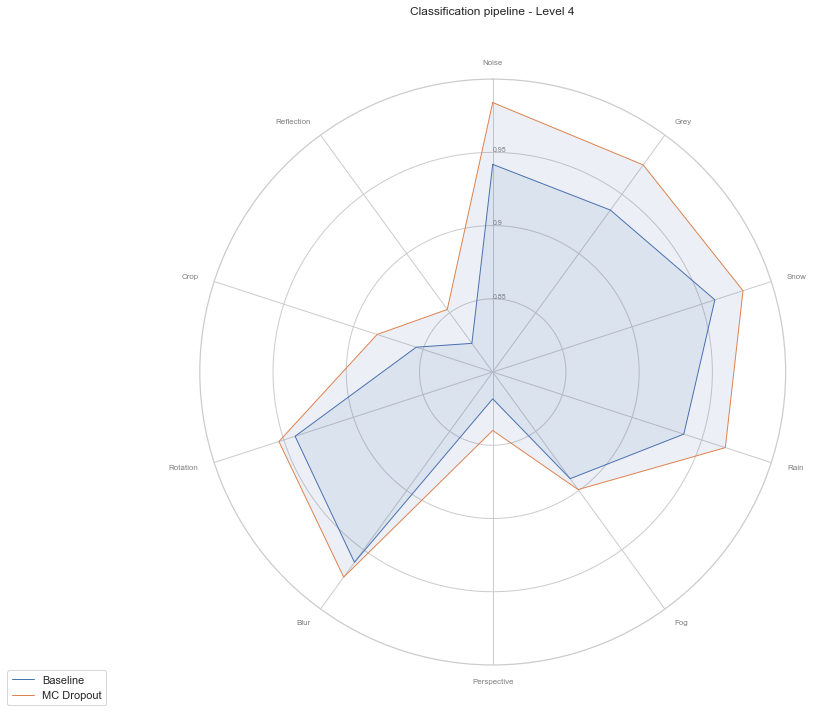

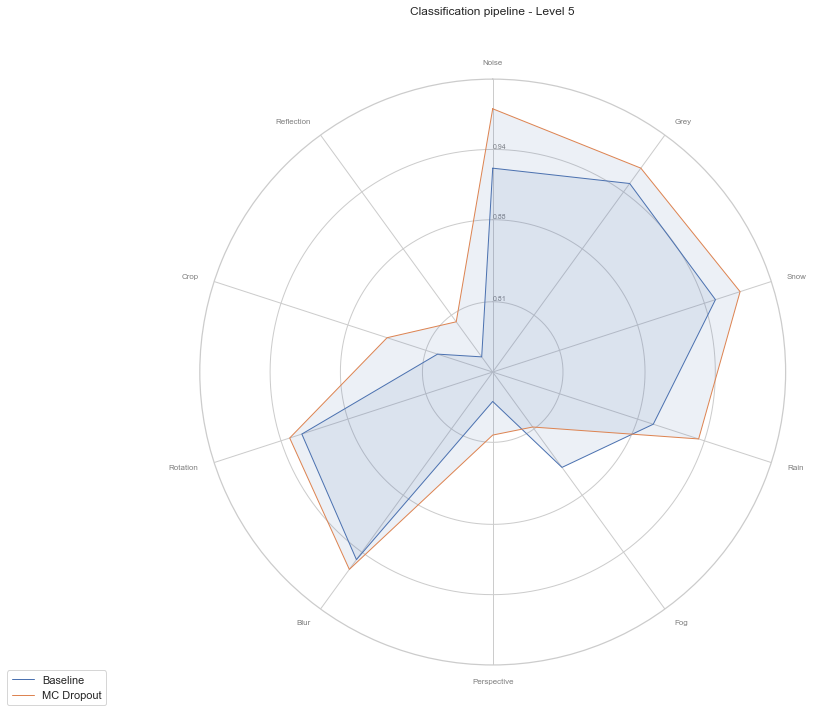

<Figure size 1440x720 with 0 Axes>

In [20]:
dfs = [baseline_classification_means, mc_classification_means]
for level in ["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"]:  
    filename = DRIVE_PATH+"Results/classification_ROC_level_"+level[-1]+".png"
    analysis.make_radar_plot(("ROC", level), dfs, ["Baseline", "MC Dropout"], title="Classification pipeline - Level "+level[-1], filename=filename)

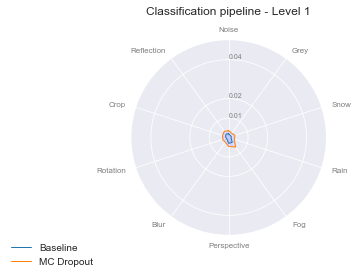

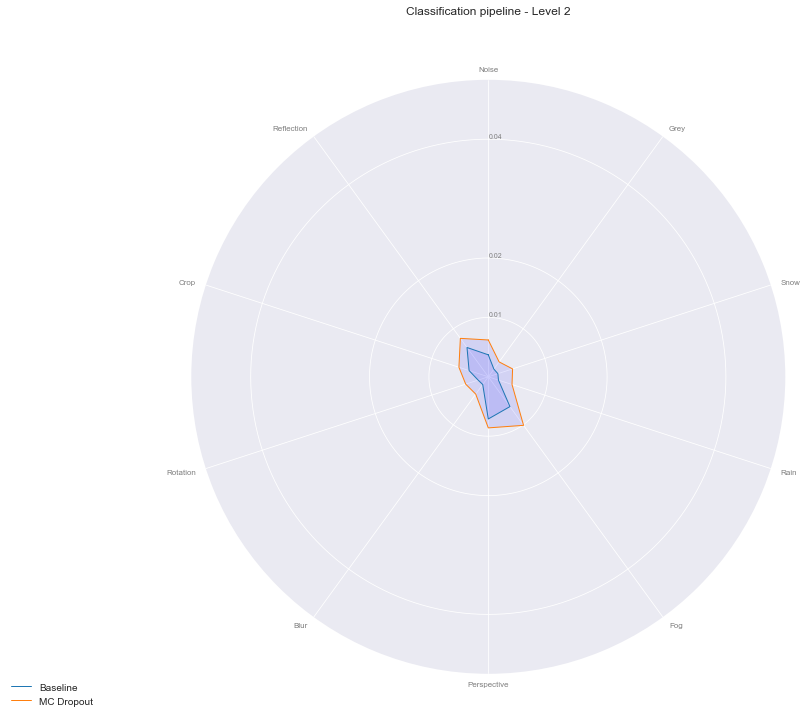

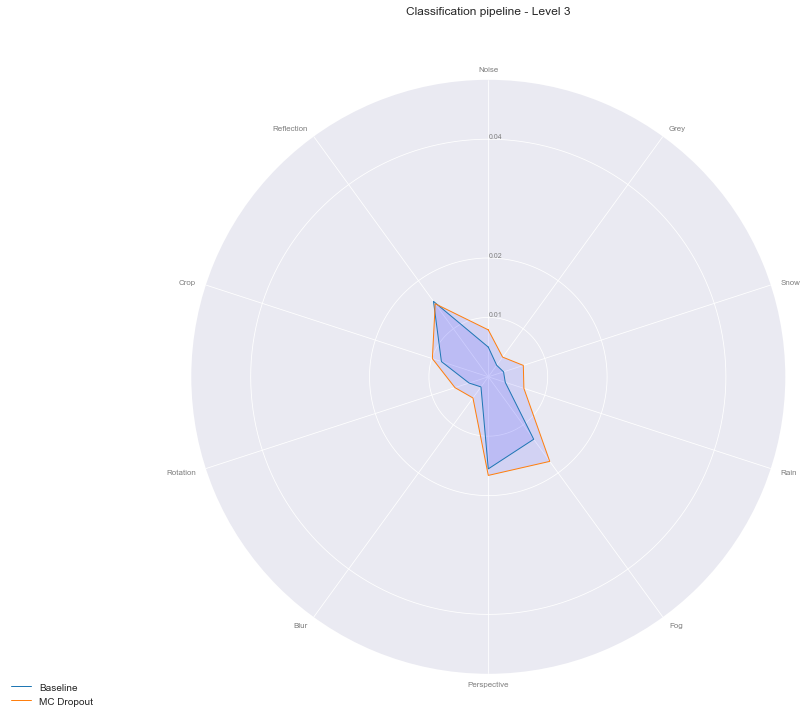

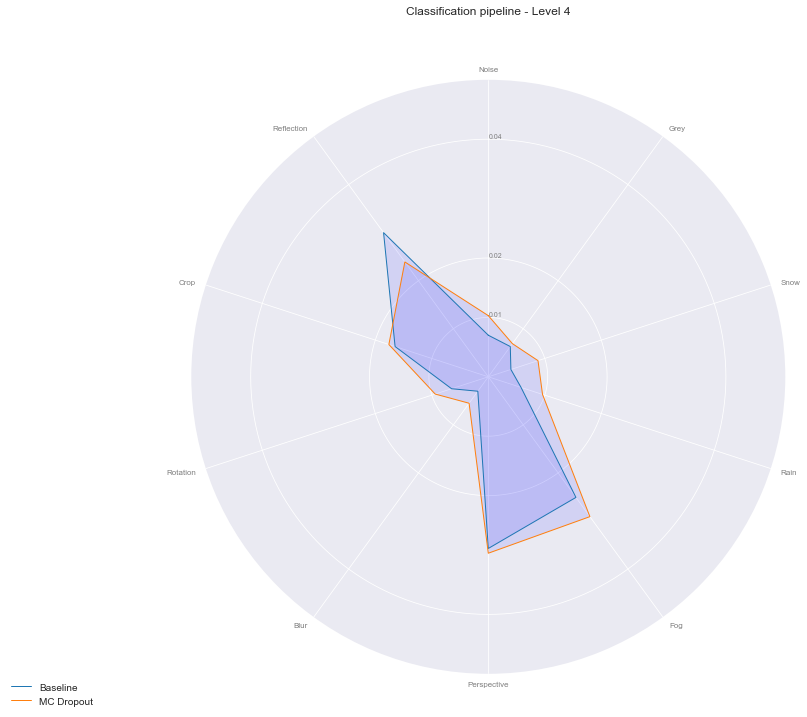

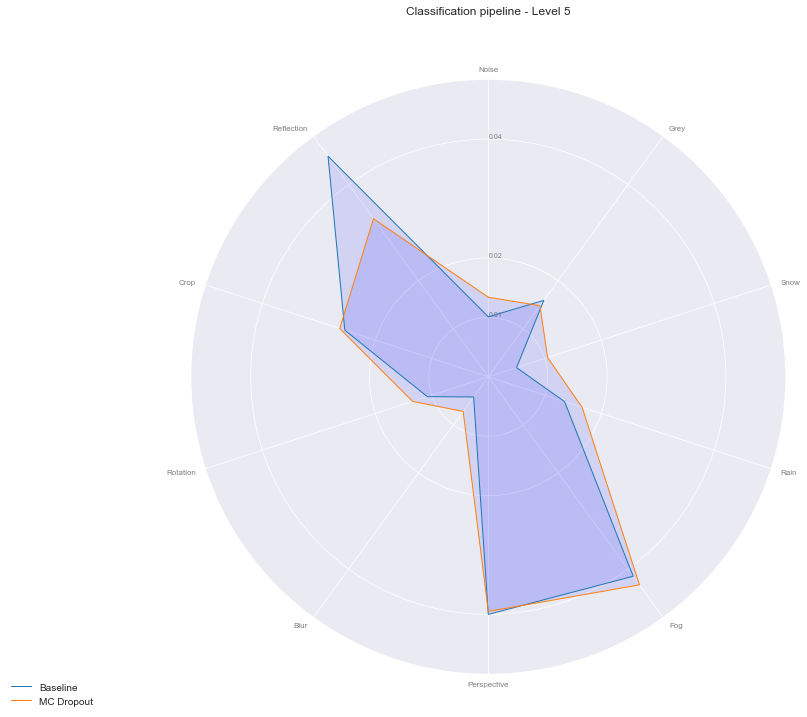

<Figure size 1440x720 with 0 Axes>

In [73]:
dfs = [baseline_classification_means, mc_classification_means]
for level in ["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"]:  
    filename = DRIVE_PATH+"Results/classification_Brier_level_"+level[-1]+".png"
    analysis.make_radar_plot(("Brier", level), dfs, ["Baseline", "MC Dropout"], 
                             title="Classification pipeline - Level "+level[-1], filename=filename, max=0.05)

#Unused

In [42]:
classification_thresholds = [0.98, 0.96, 0.94, 0.92, 0.90]

def calculate_levels(thresholds, df, colname):
    res = {}
    for i in range(len(df)):
        row = df.iloc[i]["Accuracy"]
        name = row.name
        values = row.values.tolist()
        score = 0
        for t, v in zip(thresholds, values):
            score += v>t
        res[name] = score
    df = pd.DataFrame.from_dict(res, orient='index', columns=[colname])
    return df
    
classification_score = calculate_levels(classification_thresholds, baseline_classification_means, "Baseline")
mc_score = calculate_levels(classification_thresholds, mc_classification_means, "MC Dropout")
score = pd.concat([classification_score, mc_score], axis=1)
score.sort_values(["MC Dropout", "Baseline"], ascending=False, inplace=True)
score

Baseline  MC Dropout
Snow                5           5
Blur                5           5
Noise               4           5
Rain                4           5
Grey                4           4
Rotation            4           4
Crop                2           3
Fog                 0           1
Reflection          1           0
Perspective         0           0

In [43]:
print(score.columns.values)

['Baseline' 'MC Dropout']


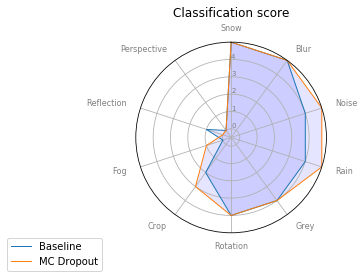

In [44]:
analysis.make_score_plot(score, "Classification score", DRIVE_PATH+"Results/classification_score.png")